In [2]:
import os
import pickle as pkl
from joblib import load, dump
import cv2
import matplotlib
import tensorflow as tf
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from tqdm import tqdm
from tensorflow.python.client import device_lib
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(device_lib.list_local_devices())

Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9912881257198494442
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4930941747
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4808013786784256336
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:

MODEL_LIST = []
MODEL_NAMES = ['skin_disease_resnet_No_AUG_88acc', 'resnet_model1_cifar10']

for i in range(len(MODEL_NAMES)):
    ### Loading DNN models 
    with open('Models/'+ MODEL_NAMES[i]+'.json', 'r') as j_file:
        loaded_model_json = j_file.read()
    model = tf.keras.models.model_from_json(loaded_model_json)
    model.load_weights("Models/"+MODEL_NAMES[i]+".h5")
    if (MODEL_NAMES[i] == 'skin_disease_resnet_No_AUG_88acc'):
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy',
                      metrics=['acc'])
    else:
        model.compile(optimizer = tf.keras.optimizers.Adam(0.001),
                      loss = "categorical_crossentropy",  metrics= ['accuracy'])
    MODEL_LIST.append(model)



# Cifar 10

In [4]:
### Cifar model benchmark
def loadPreprocessCifar10():
    ### Load In Data
    (trainX, trainY), (testX, testY) = tf.keras.datasets.cifar10.load_data()
    trainY = tf.keras.utils.to_categorical(trainY)
    testY = tf.keras.utils.to_categorical(testY)
    return [trainX/255, trainY, testX/255, testY]

trainX, trainY, testX, testY = loadPreprocessCifar10()
MODEL_LIST[1].evaluate(testX, testY)

10000/10000 [==============================] - 65s 7ms/sample - loss: 0.2515 - accuracy: 0.9306


[0.25150533339977266, 0.9306]

In [5]:
print("Performing predictions....")
print("May take a while")
pred0 = []
pred1 = []
for i in tqdm(range(len(testX))):
    tmp = np.expand_dims(cv2.resize(testX[i], (200,200)), axis = 0)
    pred0.append(MODEL_LIST[0].predict(tmp))
    pred1.append(MODEL_LIST[1].predict(np.expand_dims(testX[i], axis = 0)))    

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

Performing predictions....
May take a while


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [16:33<00:00, 10.06it/s]


In [6]:
n = 0
correct_model_predictions_idx = []
for i in range(len(pred0)):
    if(np.amax(pred0[i])>np.amax(pred1[i])):
        n = n+1
    else:
        correct_model_predictions_idx.append(i)
print("{} samples were passed to the wrong model.".format(n))
print("This is because the wrong model had a higher confidence value.")
pidx = np.argmax(np.vstack(pred1), axis = 1)[correct_model_predictions_idx]
groundTruth = np.argmax(testY[correct_model_predictions_idx],axis = 1)
from sklearn.metrics import accuracy_score
acc = accuracy_score(groundTruth,pidx)
print("Accuracy",acc)

549 samples were passed to the wrong model.
This is because the wrong model had a higher confidence value.
Accuracy 0.953232462173315


In [8]:
pidx.shape

(9451,)

In [12]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import roc_curve, log_loss
f1 = f1_score(groundTruth, pidx, average = "macro")
acc = accuracy_score(groundTruth,pidx)
recall = recall_score(groundTruth, pidx, average = "macro")
precision =precision_score(groundTruth, pidx, average = "macro")
loss = log_loss(testY[correct_model_predictions_idx], 
                tf.keras.utils.to_categorical(pidx, num_classes = 10))
print("Loss: {}".format(loss))
print("Accuracy: {}".format(acc))
print("F1 Score: {}".format(f1))
print("recall Score: {}".format(recall))
print("Precision Score: {}".format(precision))

Loss: 1.6152935316670876
Accuracy: 0.953232462173315
F1 Score: 0.9528114336312768
recall Score: 0.9525675839537422
Precision Score: 0.9534616479848342


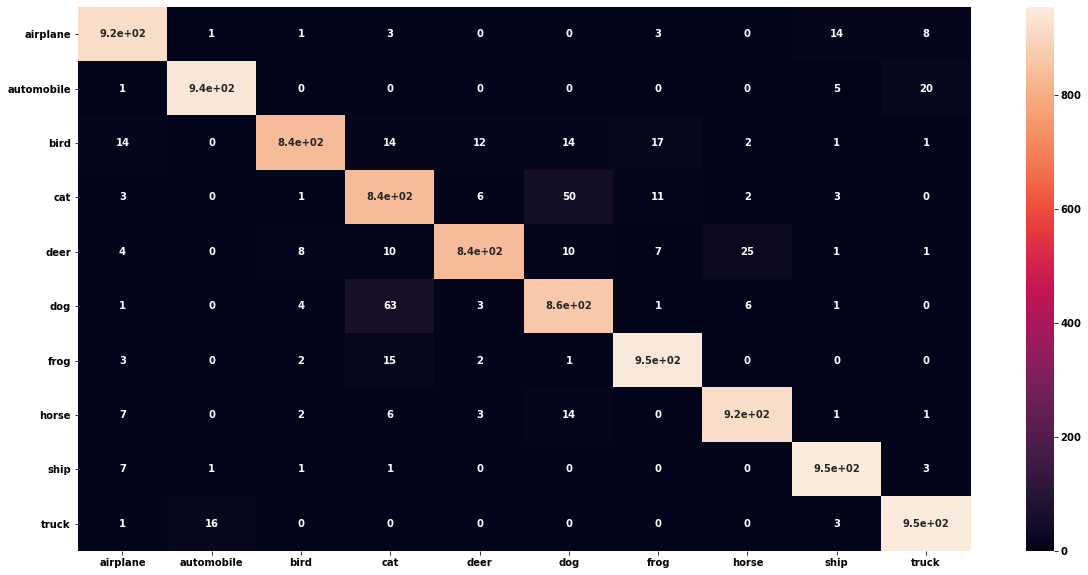

In [99]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
conf = tf.math.confusion_matrix(groundTruth,pidx)
font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 10}
matplotlib.rc('font', **font)
labels_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship',
                'truck']
df_cm = pd.DataFrame(np.array(conf), index = [i for i in labels_names],
                  columns = [i for i in labels_names])
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)

c:\users\user\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


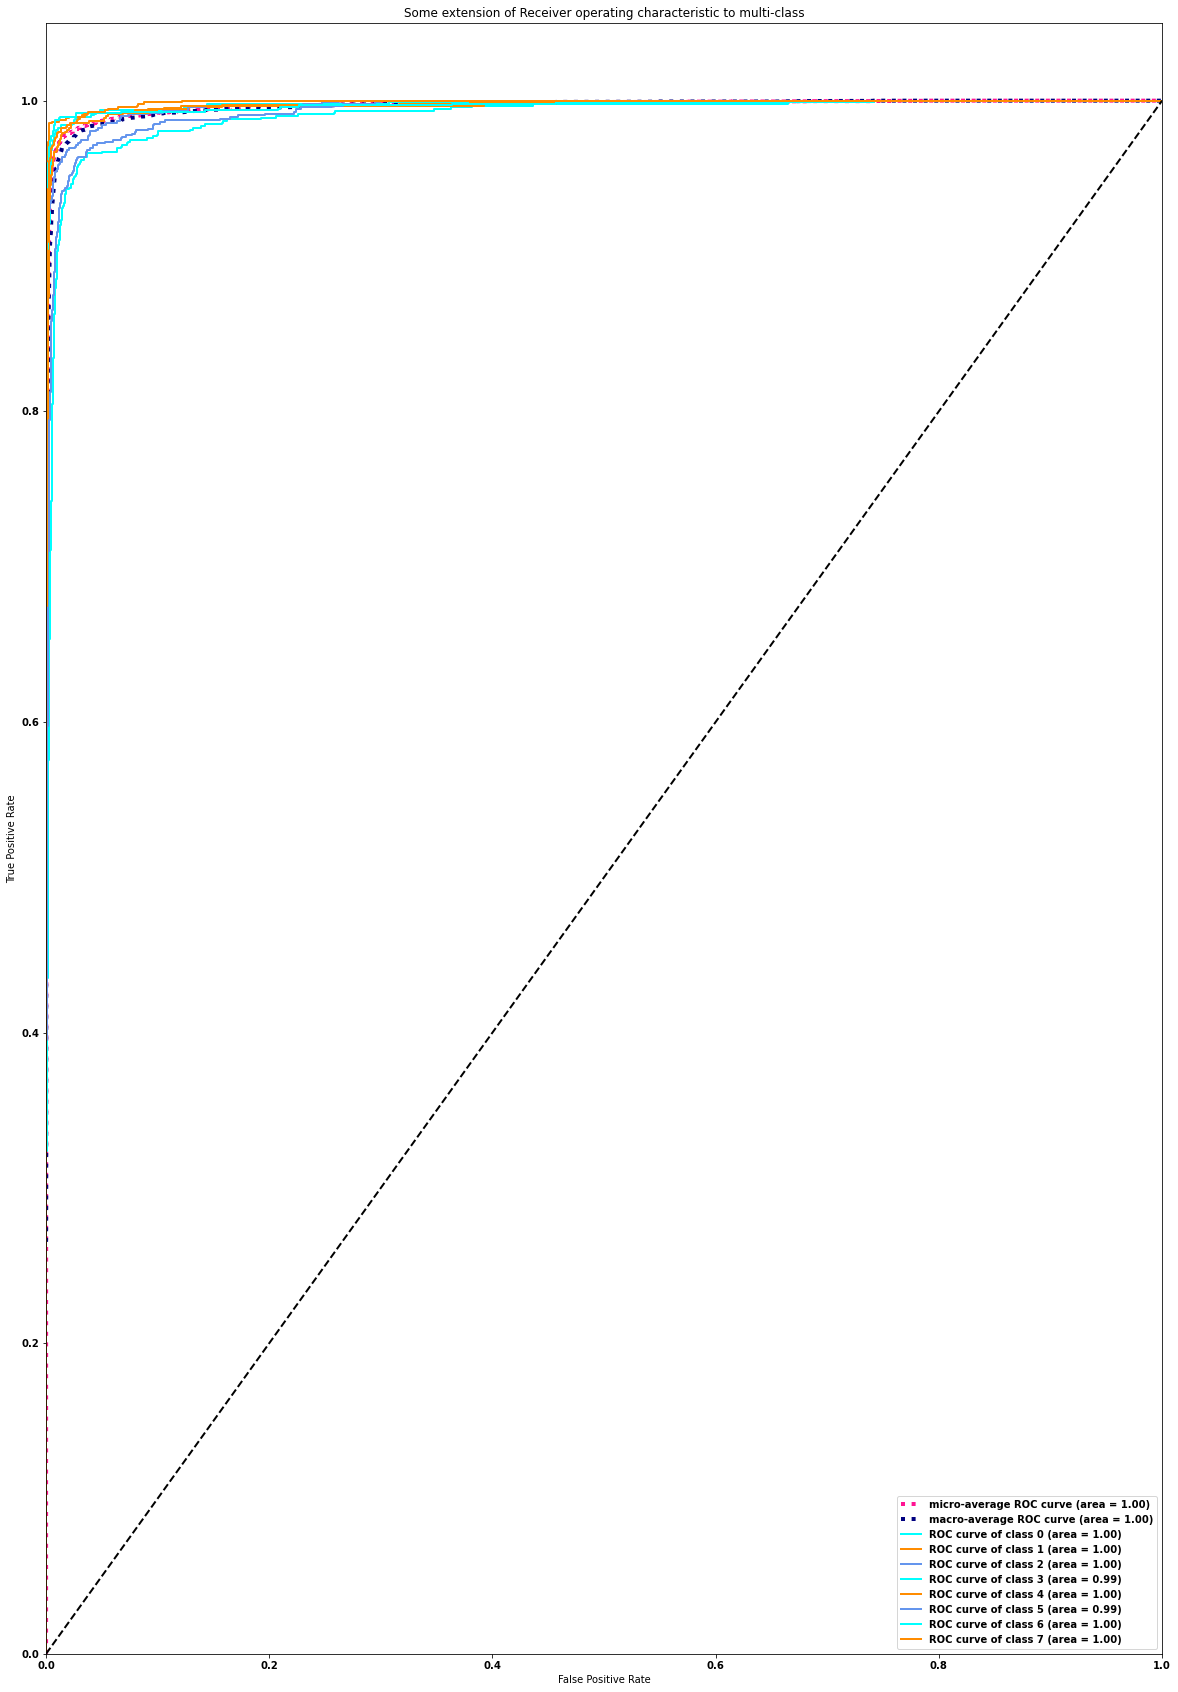

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
y_test = np.copy(testY[correct_model_predictions_idx])
y_score = np.copy(np.vstack(pred1)[correct_model_predictions_idx])
n_classes =  8
lw =2
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (20, 30))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [14]:
%matplotlib inline
def plot_class_predictions(preds,idx, classes):
    
    print("Class #{}".format(idx))
    c, f = np.unique(preds, return_counts = True)
    fig = plt.figure( figsize = (30,20))
    font = {'family' : 'sans',
            'weight' : 'bold',
            'size'   : 40}
    matplotlib.rc('font', **font)
    ax = fig.add_axes([0,0,1,1 ])
    ax.set_title("{} Predictions".format(classes[idx]))
    ax.set_xlabel("Clases")
    ax.set_ylabel("Frequecy Of Predictions")
    ax.set_xticks(c)
    ax.bar(c,f)
def returnClassIndex(trainY,class_index):
    labels = np.argmax(trainY, axis = 1)
    return [ i for i in range(len(labels)) if labels[i] == class_index]

In [15]:
cclasses = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship',
               'truck']

Class #0


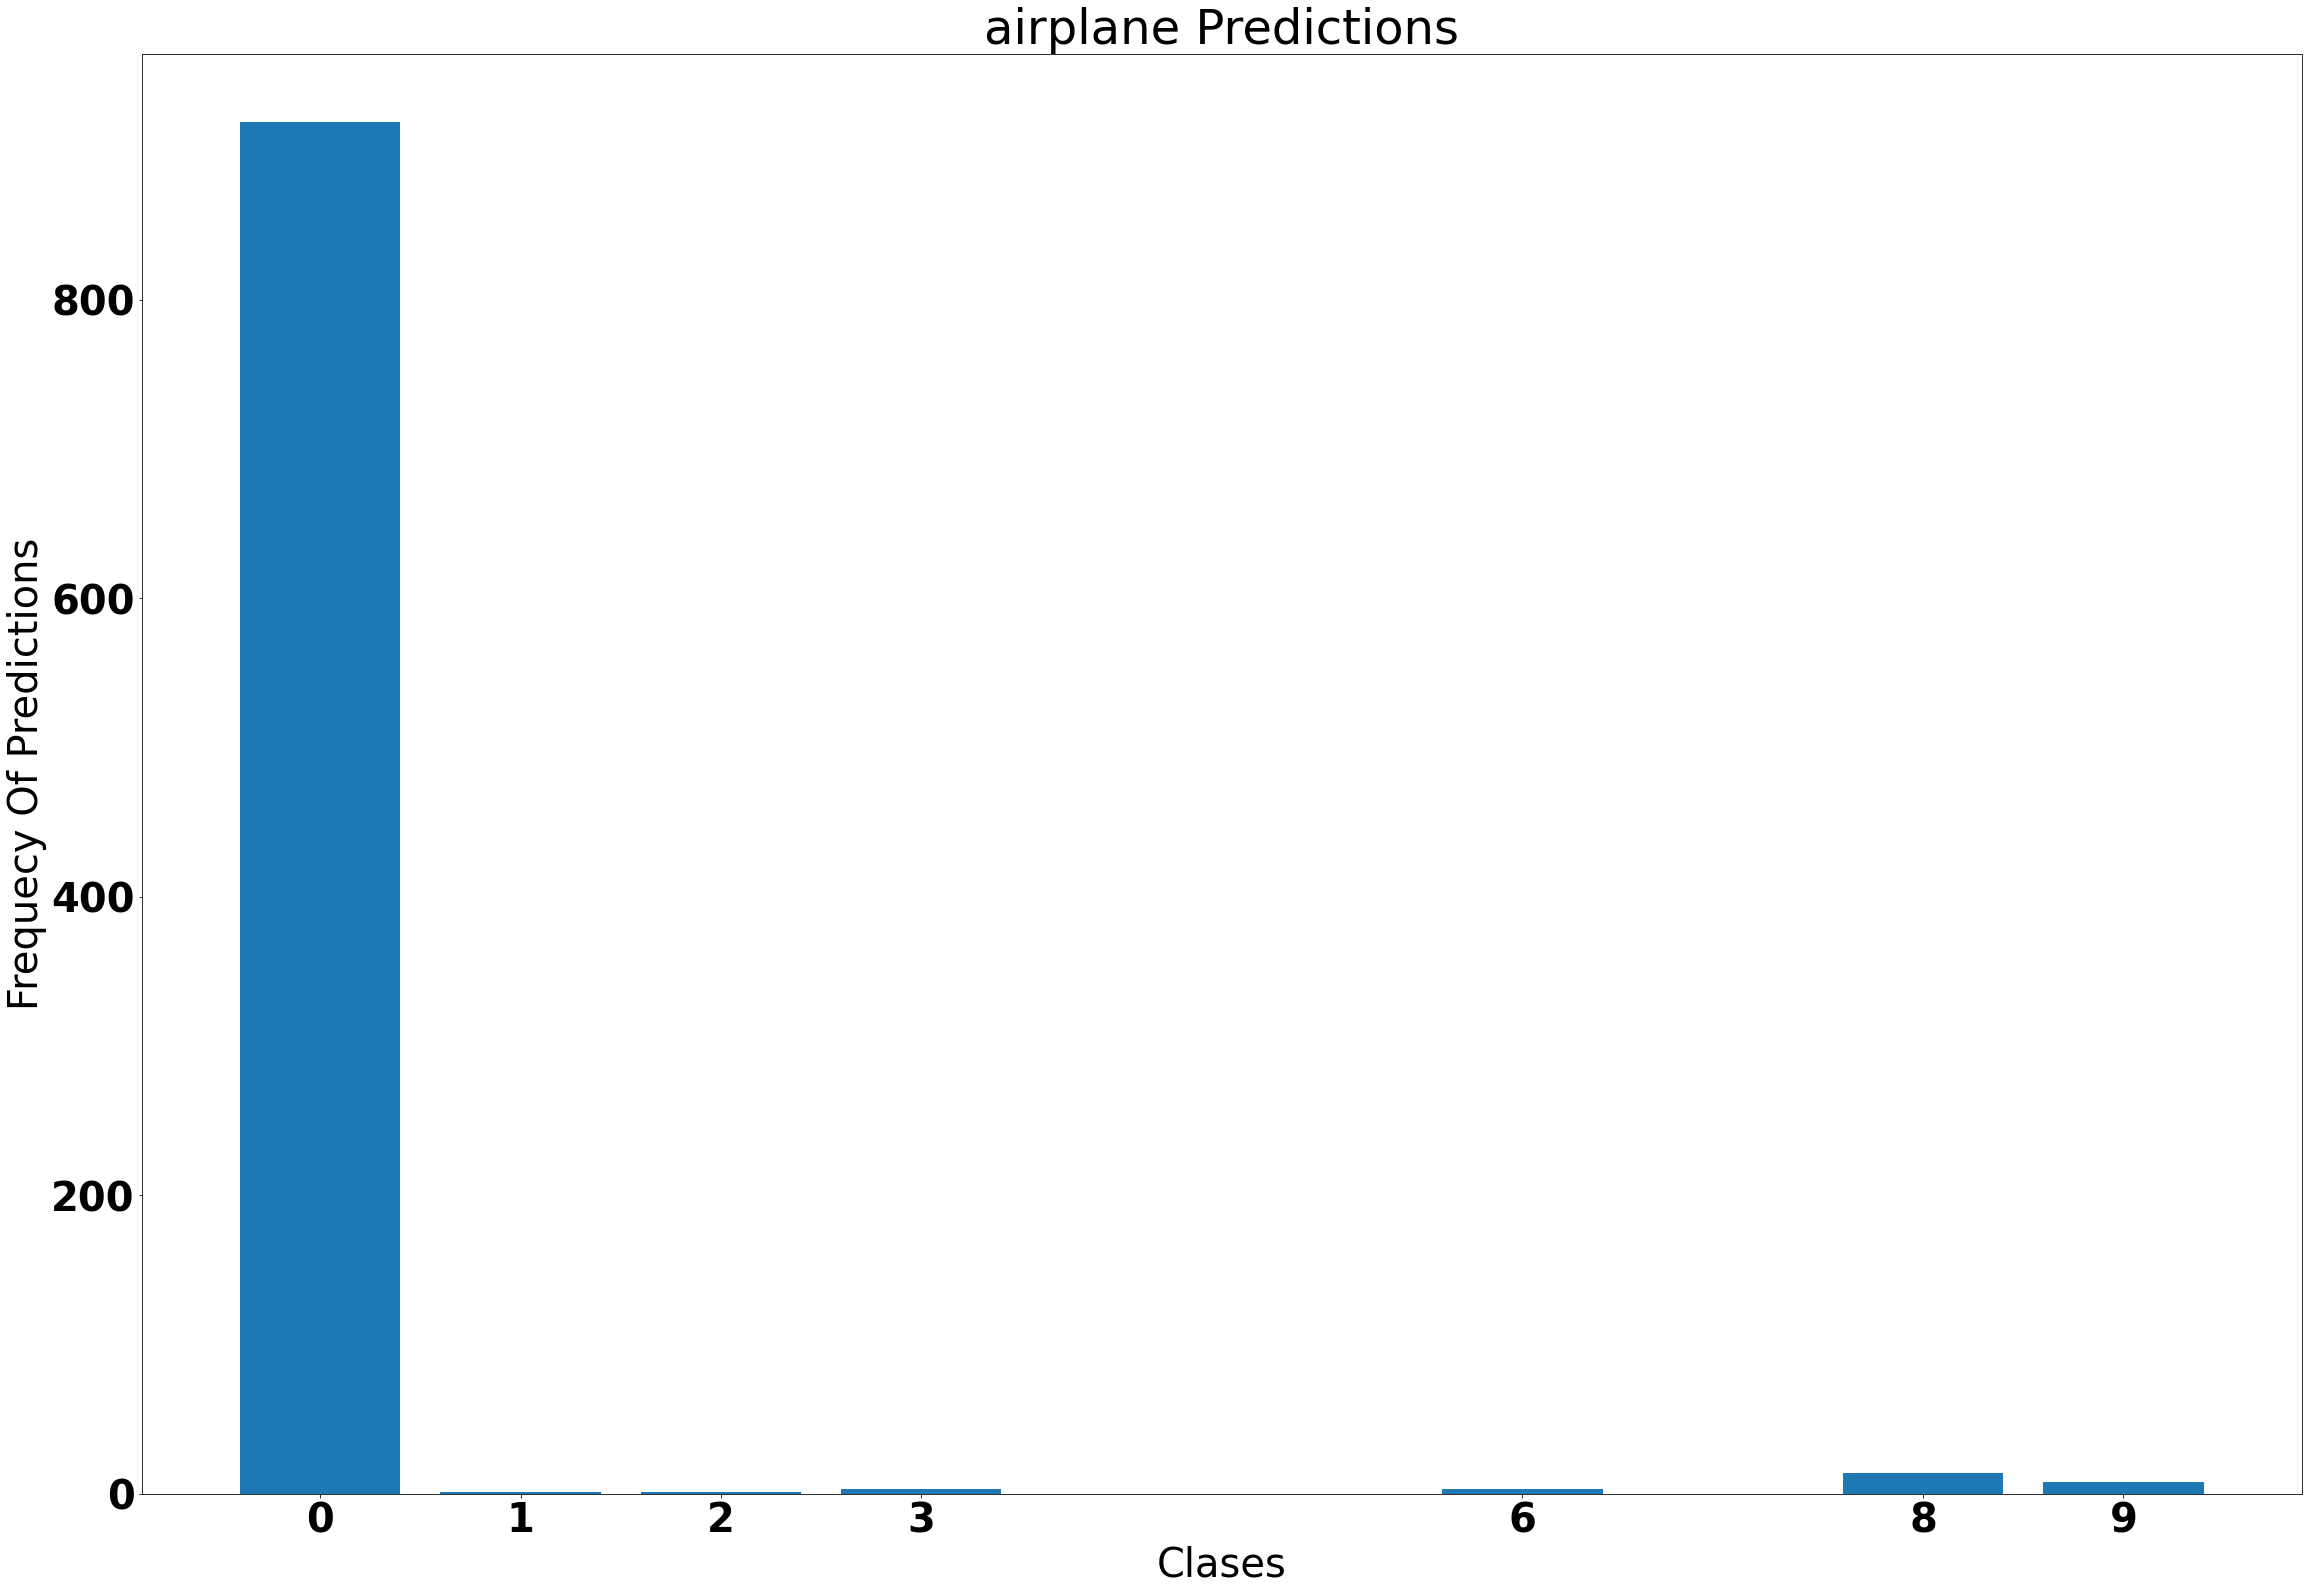

In [17]:
idx = 0
c = returnClassIndex(testY[correct_model_predictions_idx],idx)
plot_class_predictions(pidx[c], idx,cclasses)

Class #1


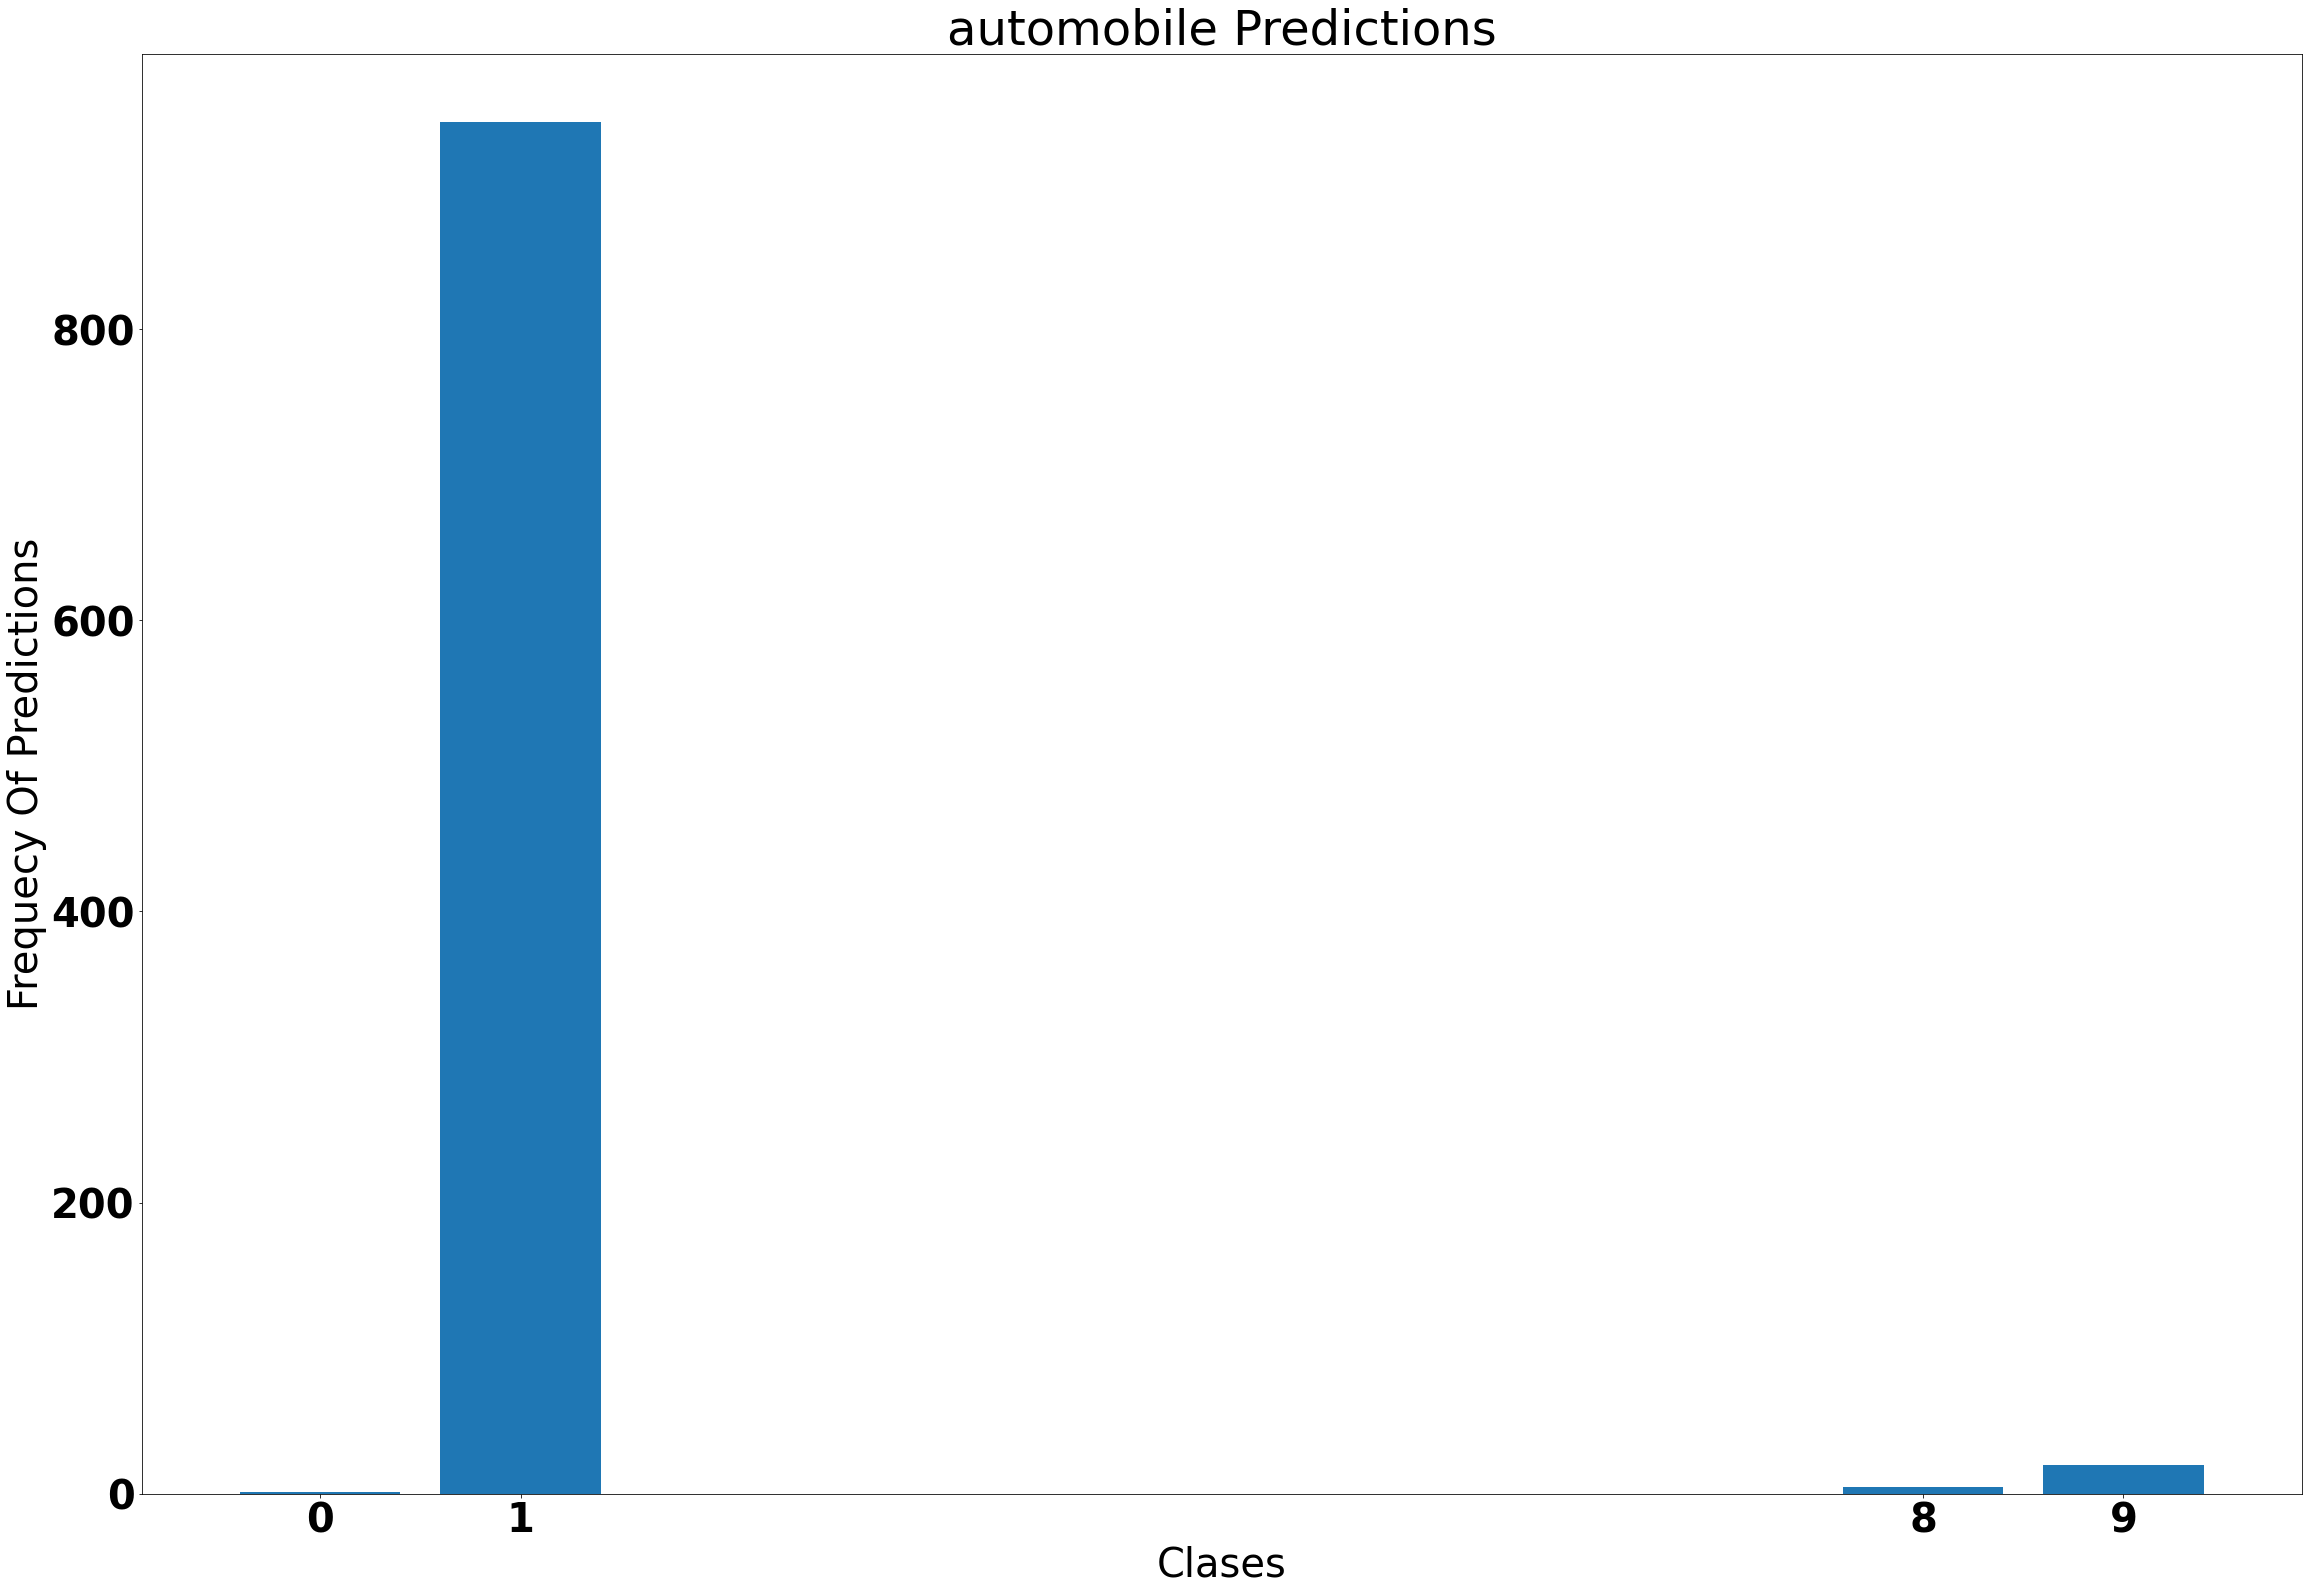

In [18]:
idx = 1
c = returnClassIndex(testY[correct_model_predictions_idx],idx)
plot_class_predictions(pidx[c], idx,cclasses)

Class #2


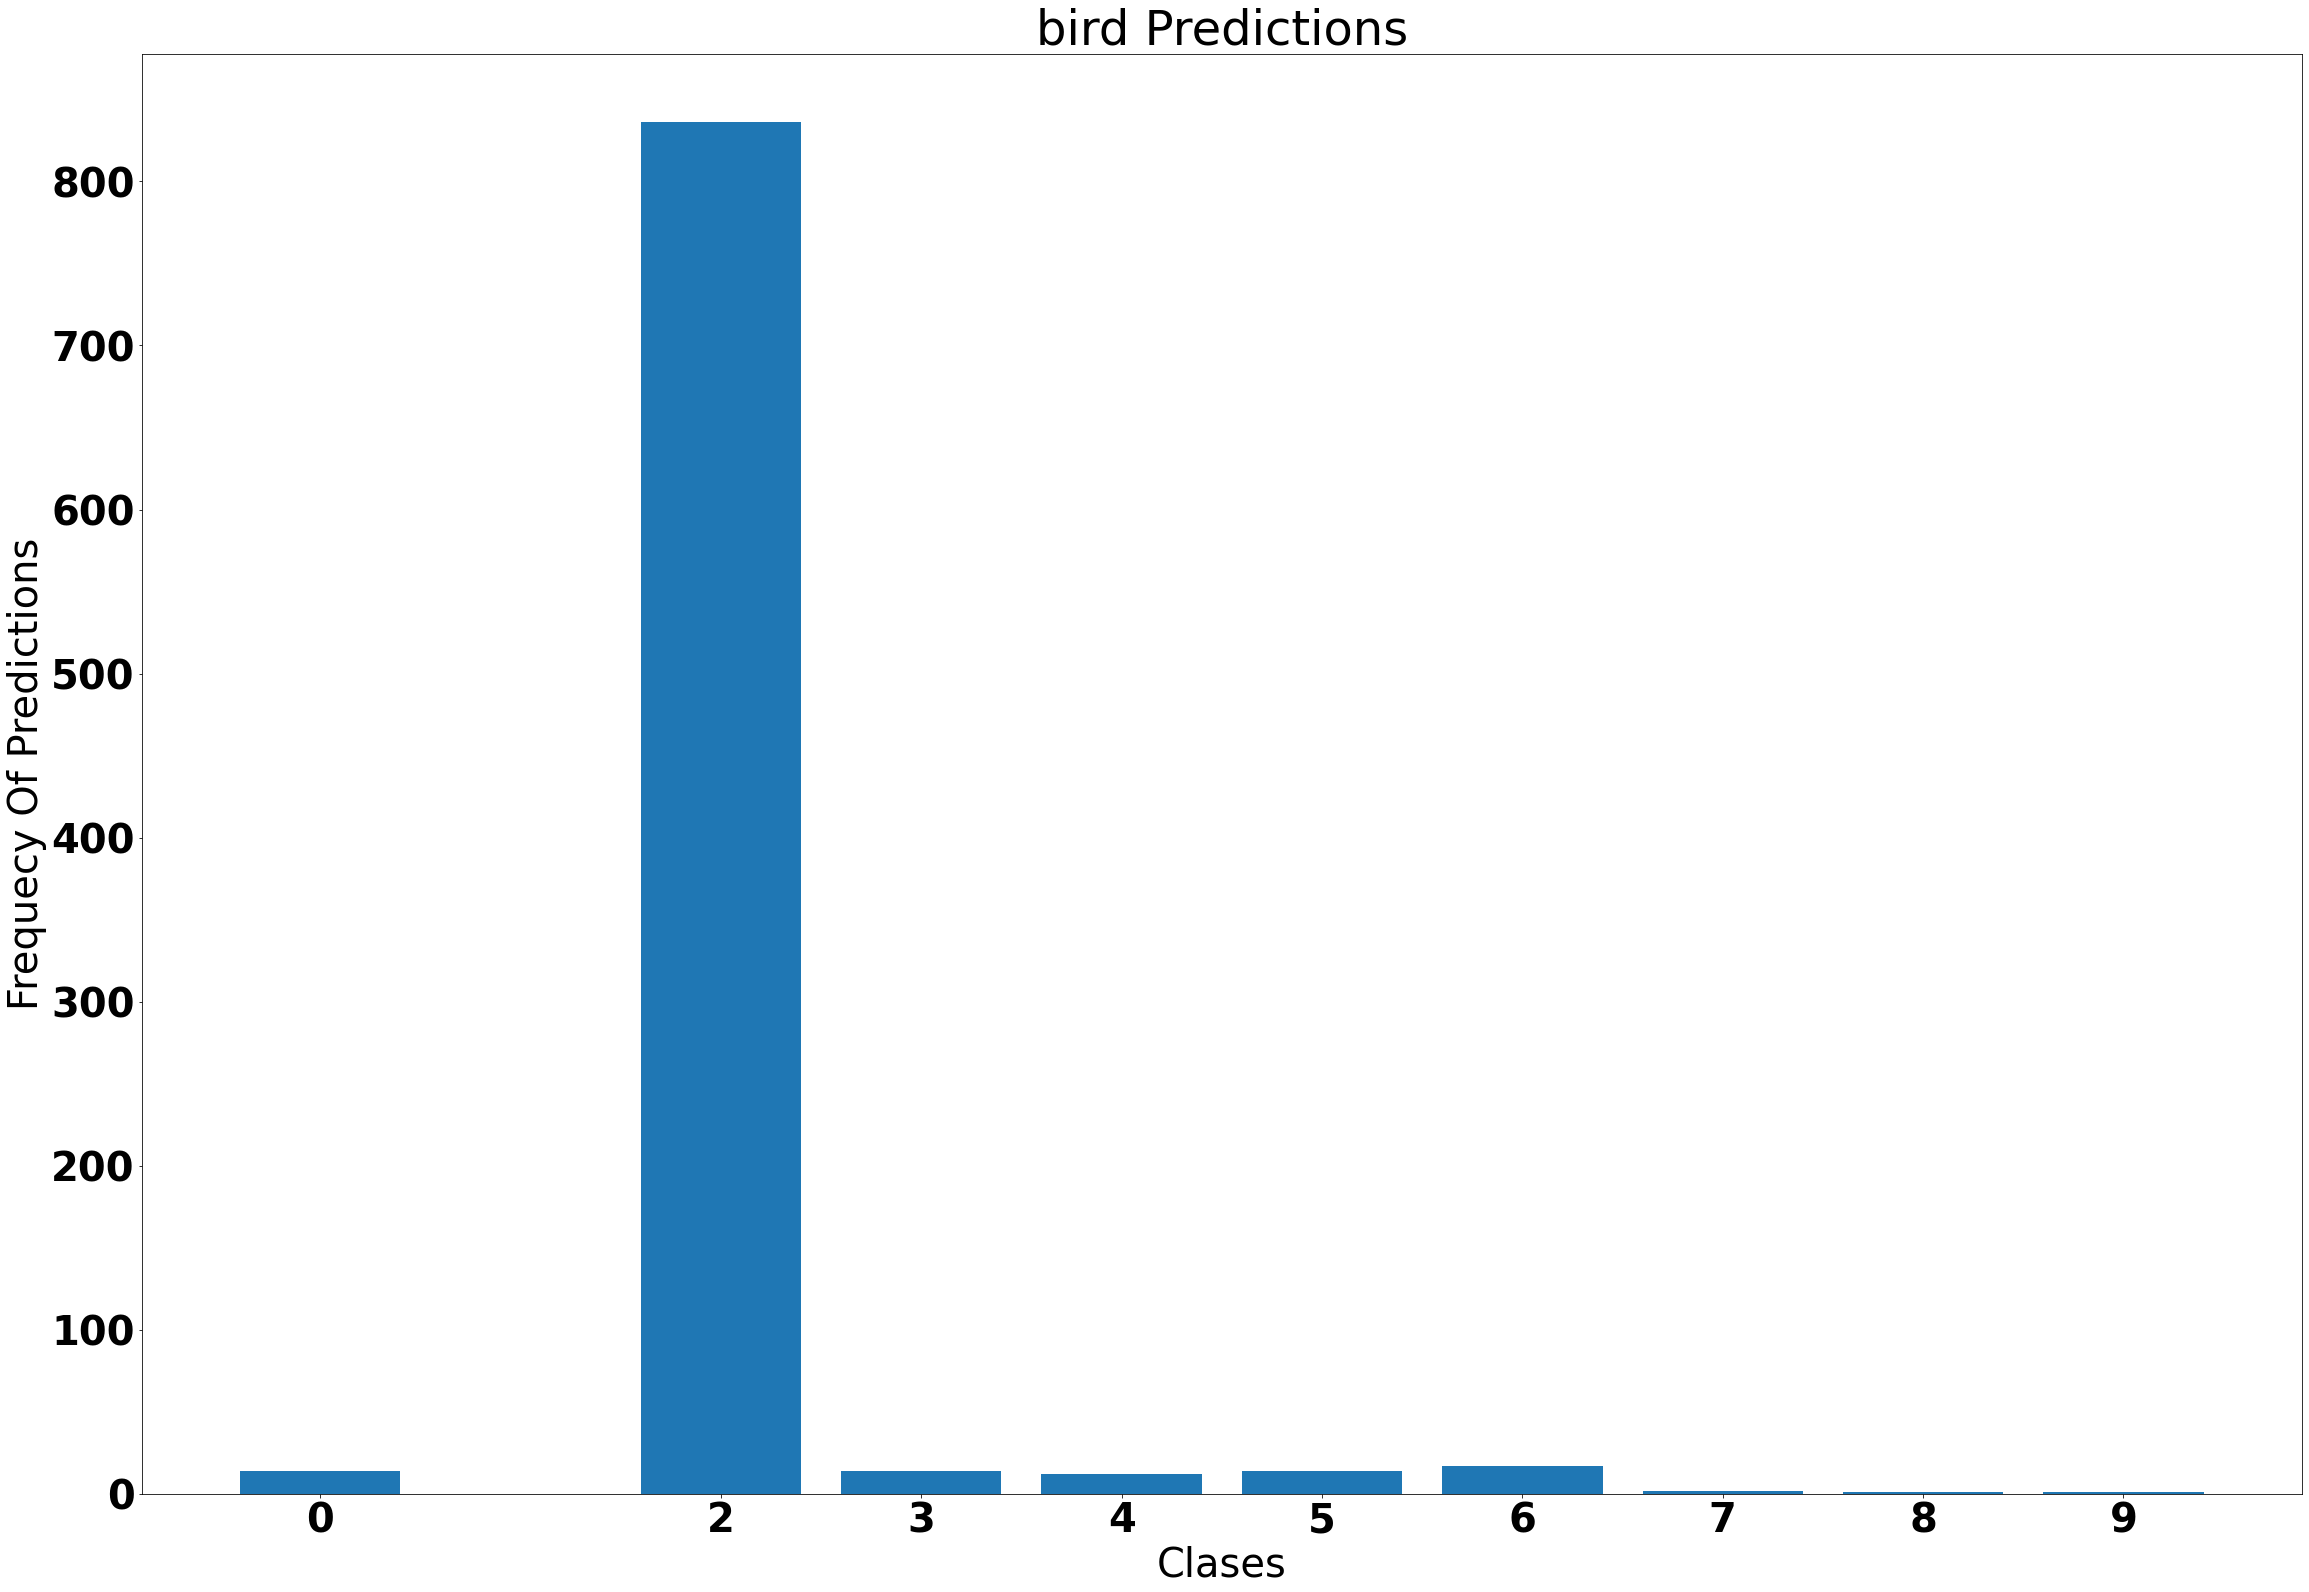

In [19]:
idx = 2
c = returnClassIndex(testY[correct_model_predictions_idx],idx)
plot_class_predictions(pidx[c], idx,cclasses)

Class #3


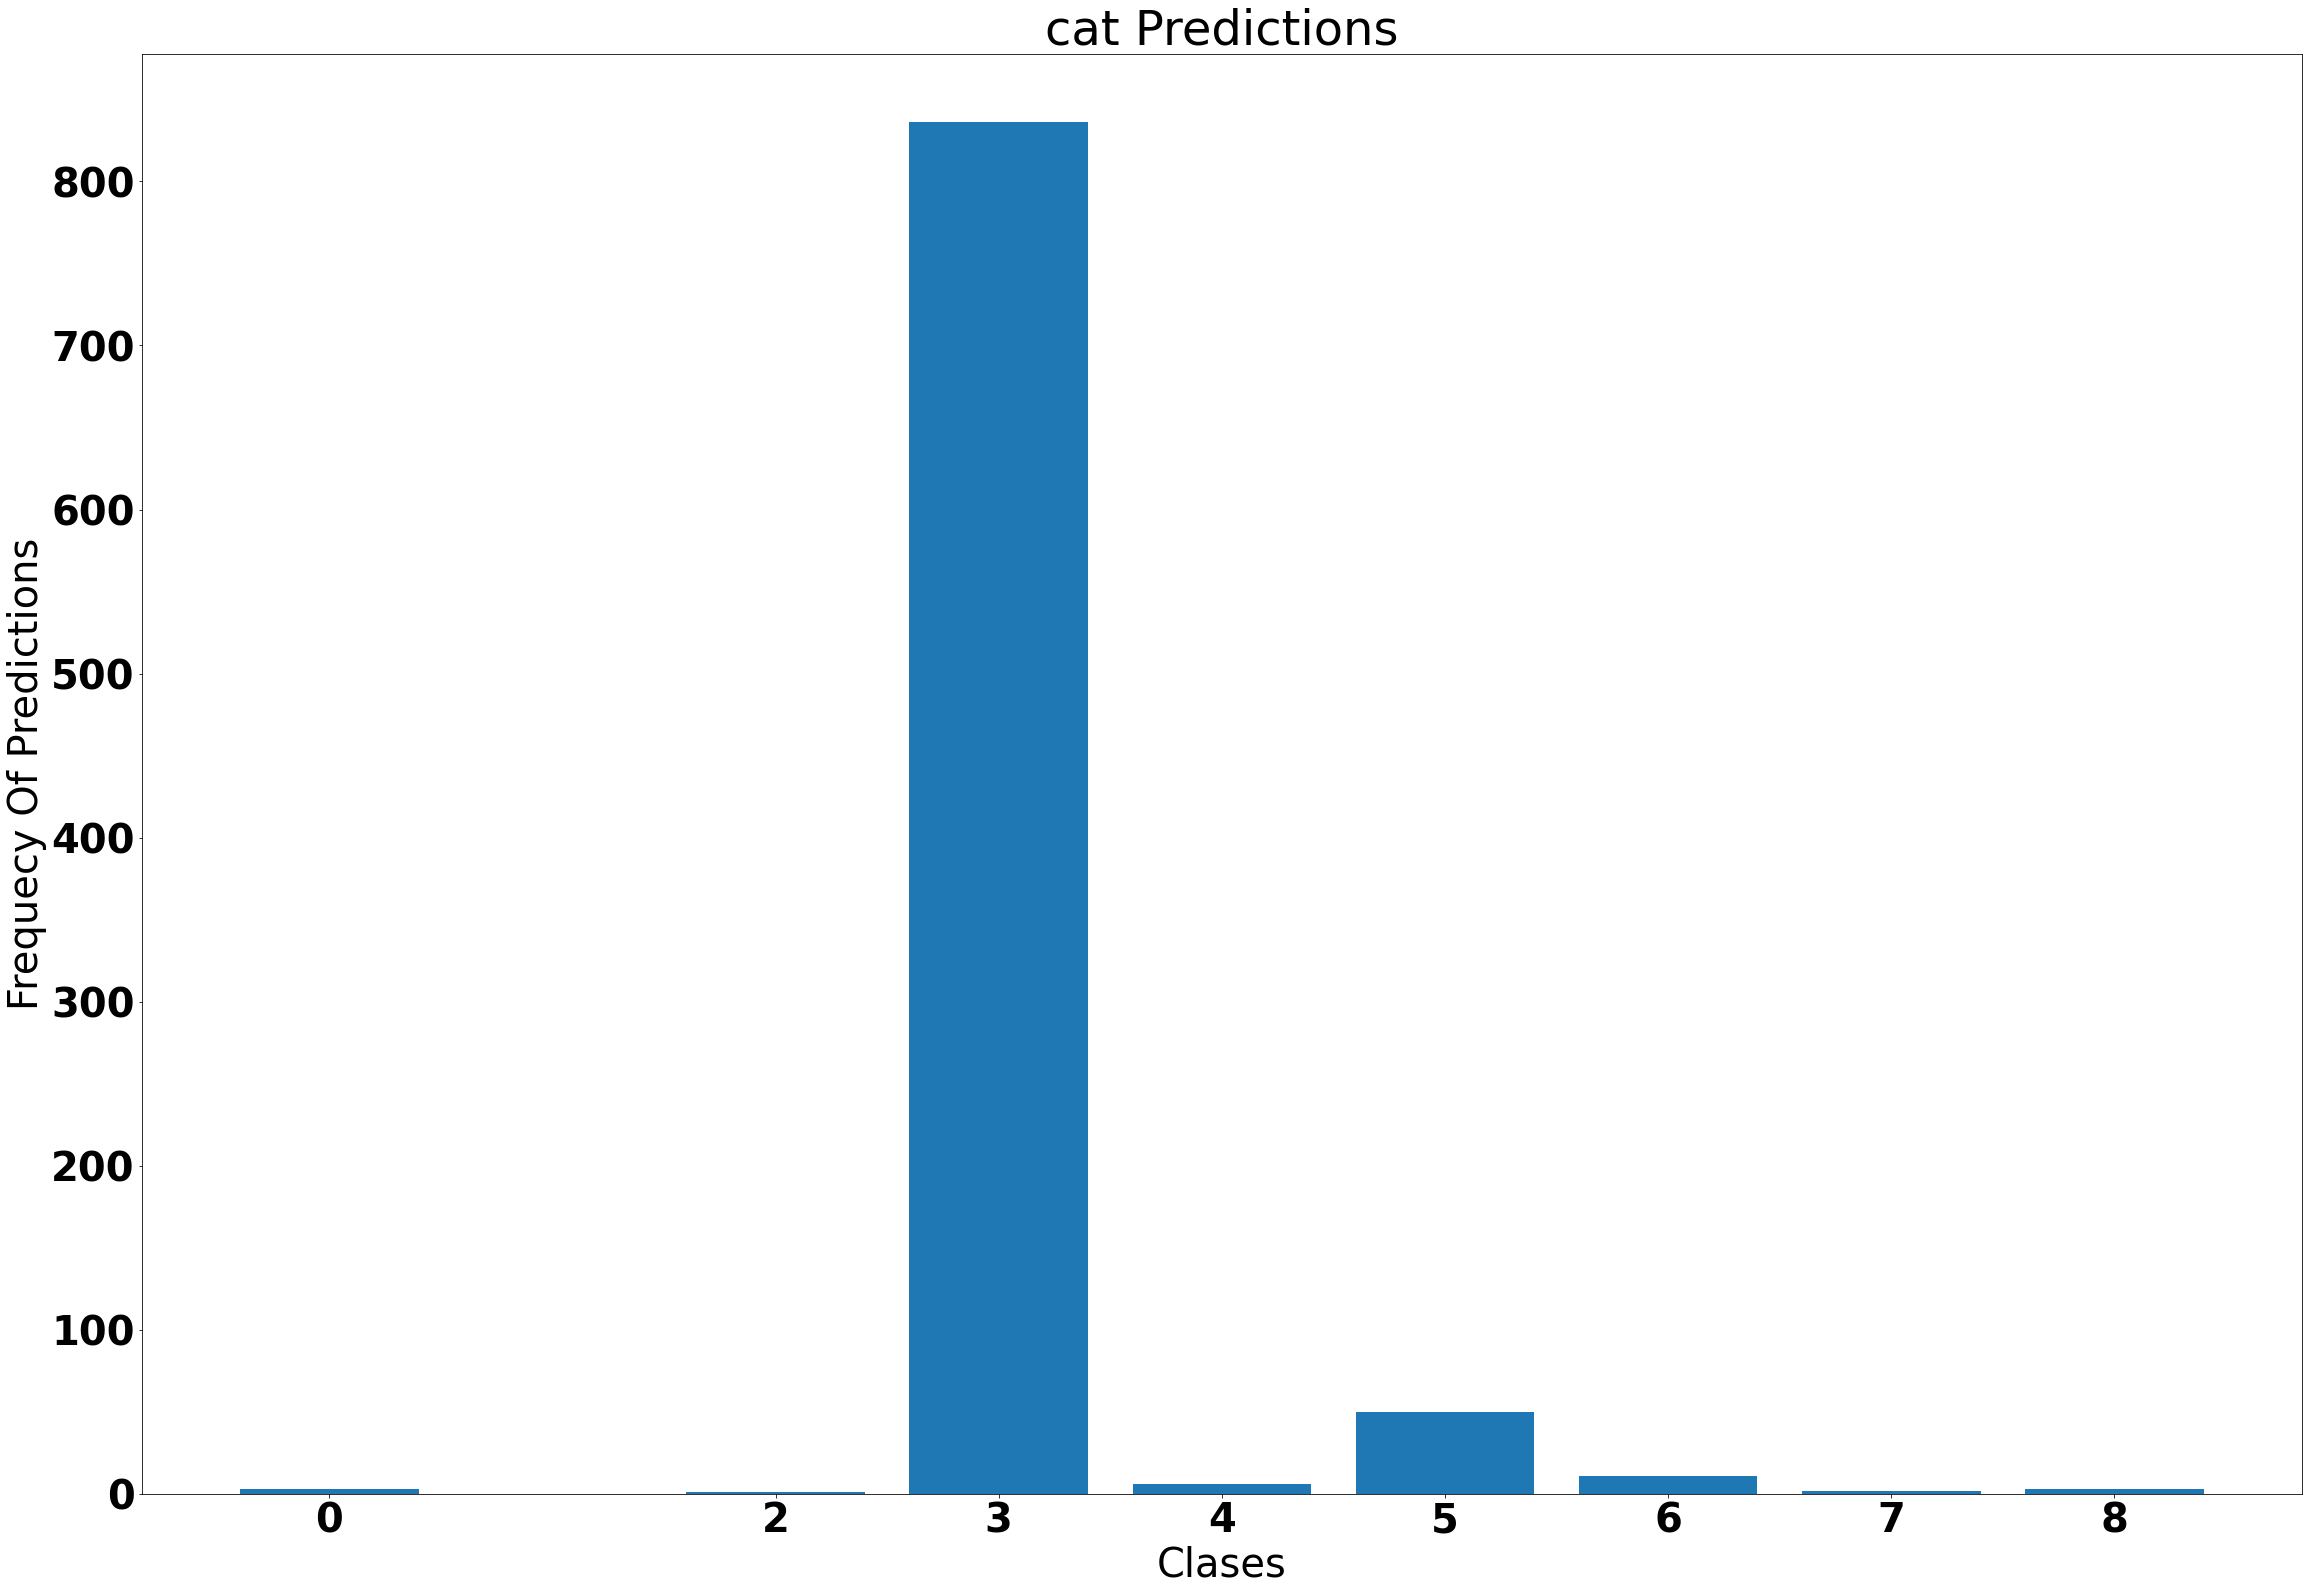

In [20]:
idx = 3
c = returnClassIndex(testY[correct_model_predictions_idx],idx)
plot_class_predictions(pidx[c], idx,cclasses)

Class #4


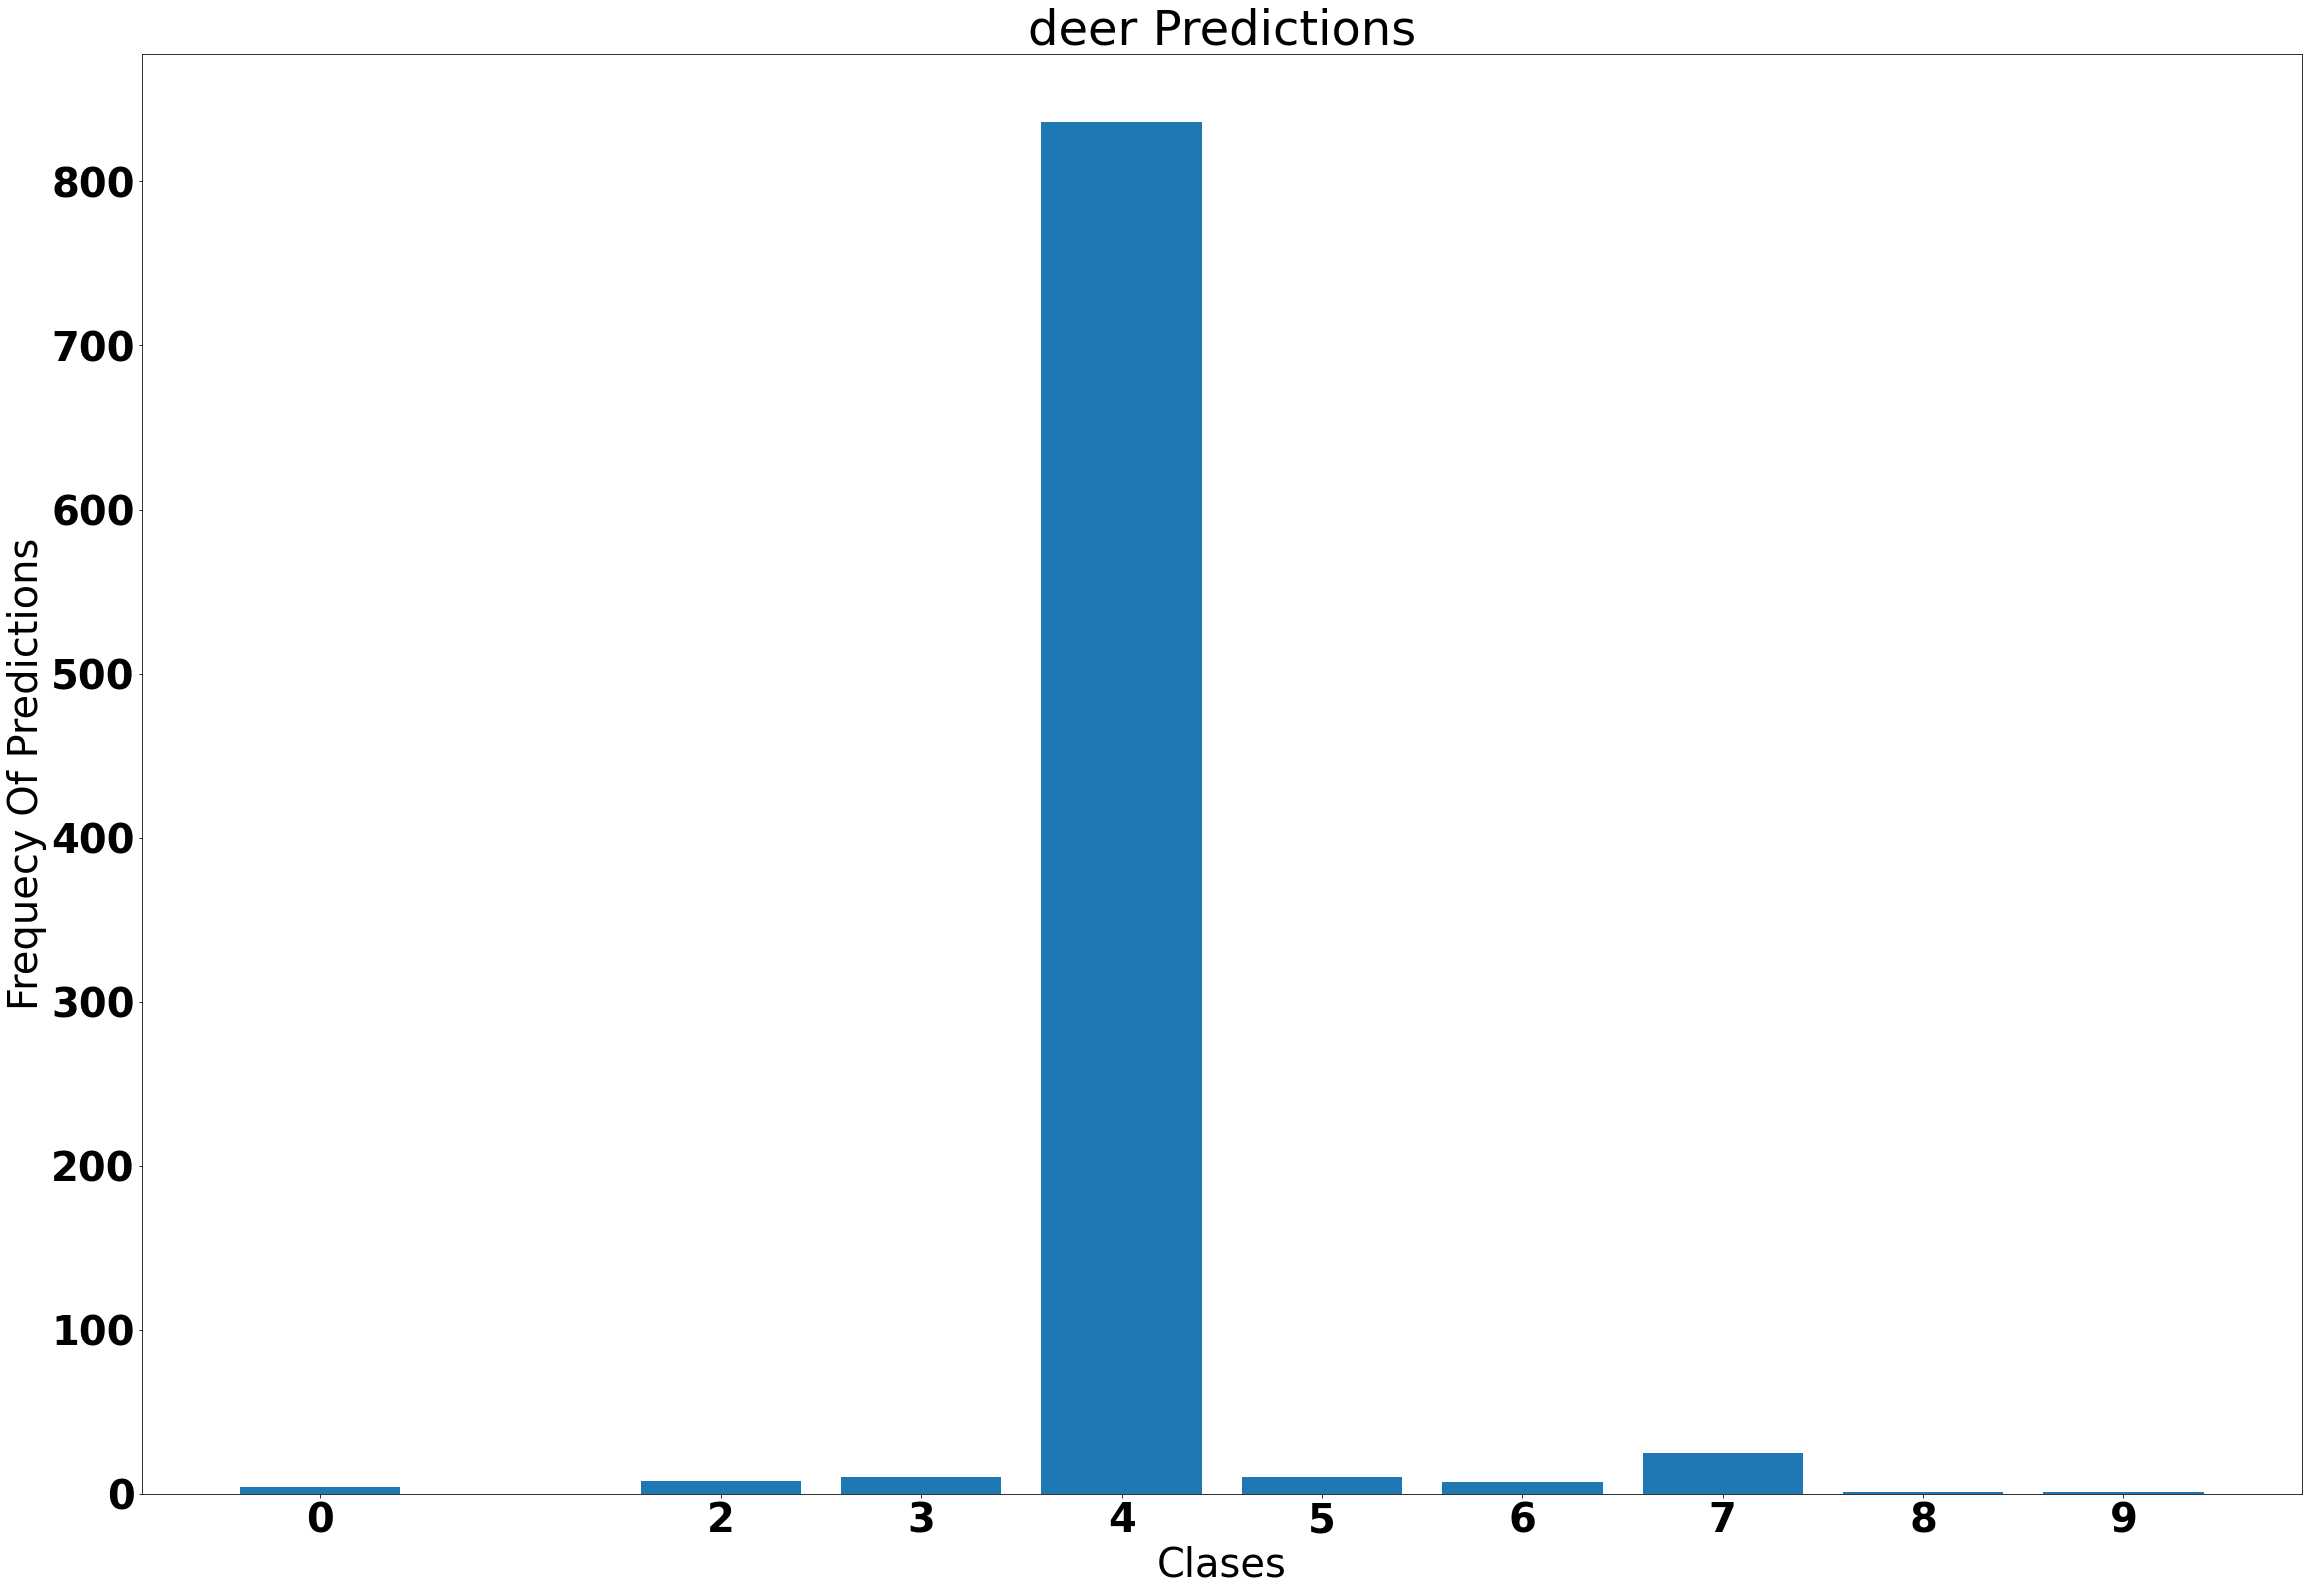

In [21]:
idx = 4
c = returnClassIndex(testY[correct_model_predictions_idx],idx)
plot_class_predictions(pidx[c], idx,cclasses)

Class #5


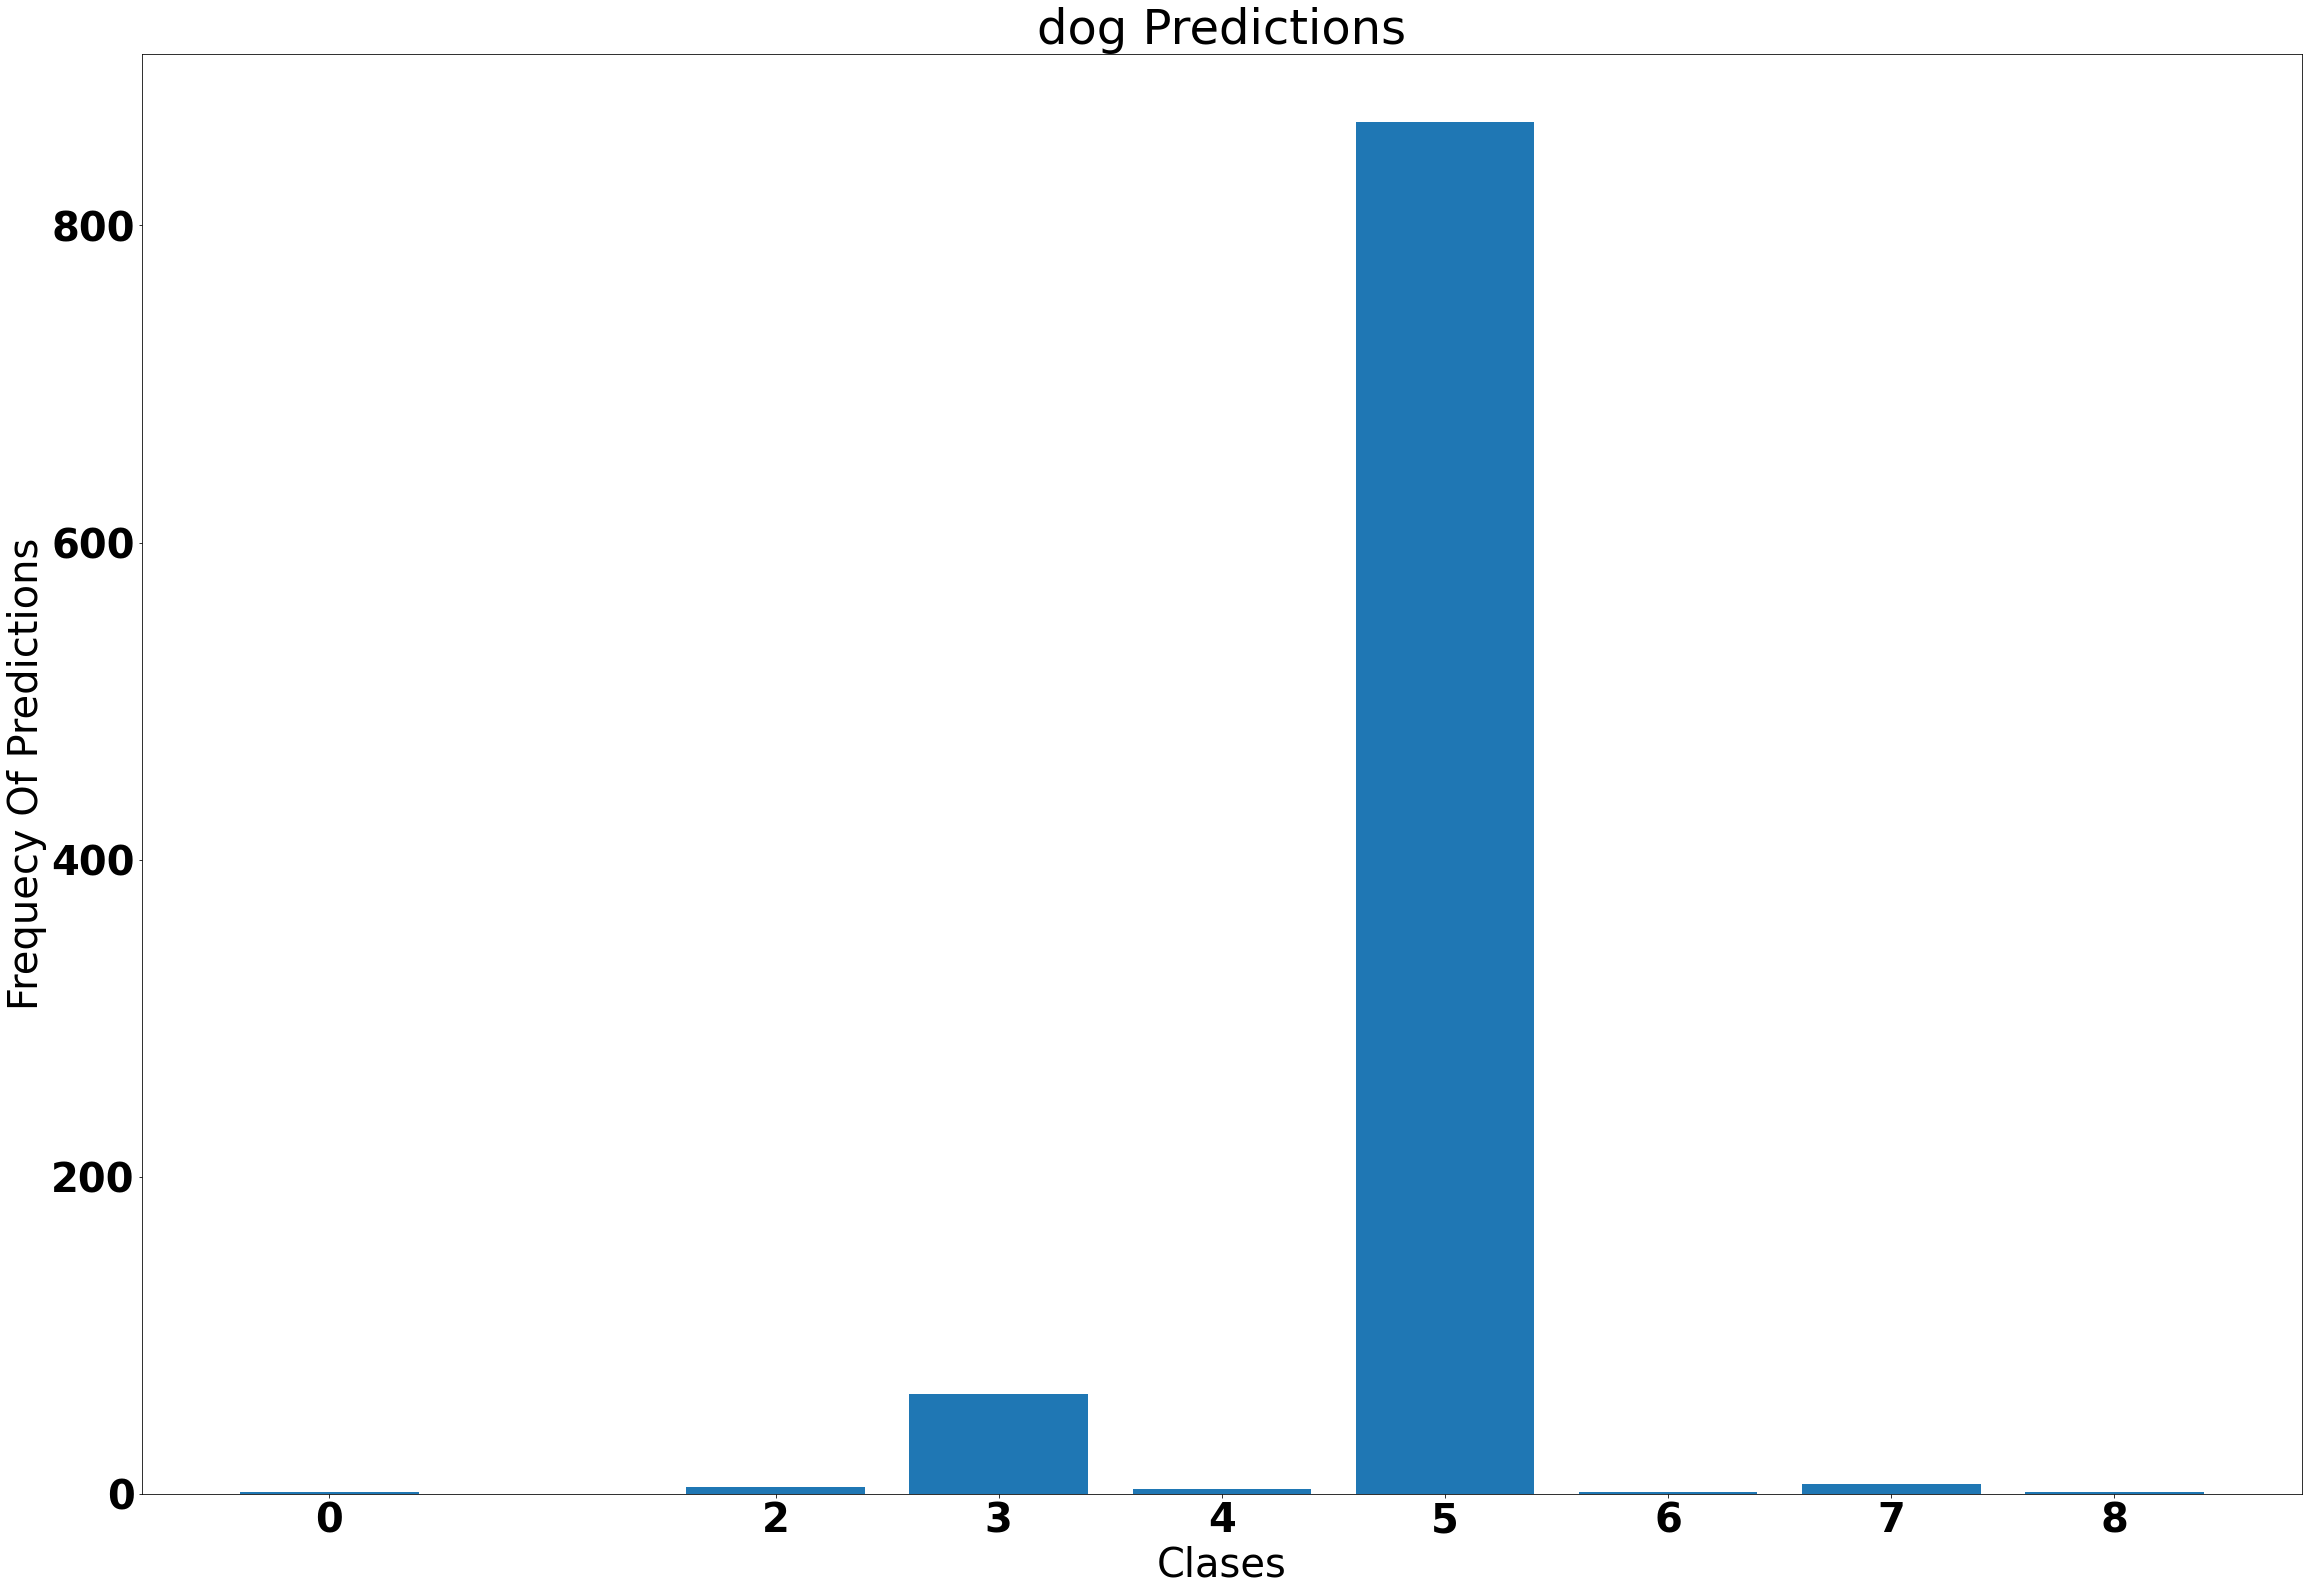

In [22]:
idx = 5
c = returnClassIndex(testY[correct_model_predictions_idx],idx)
plot_class_predictions(pidx[c], idx,cclasses)

Class #6


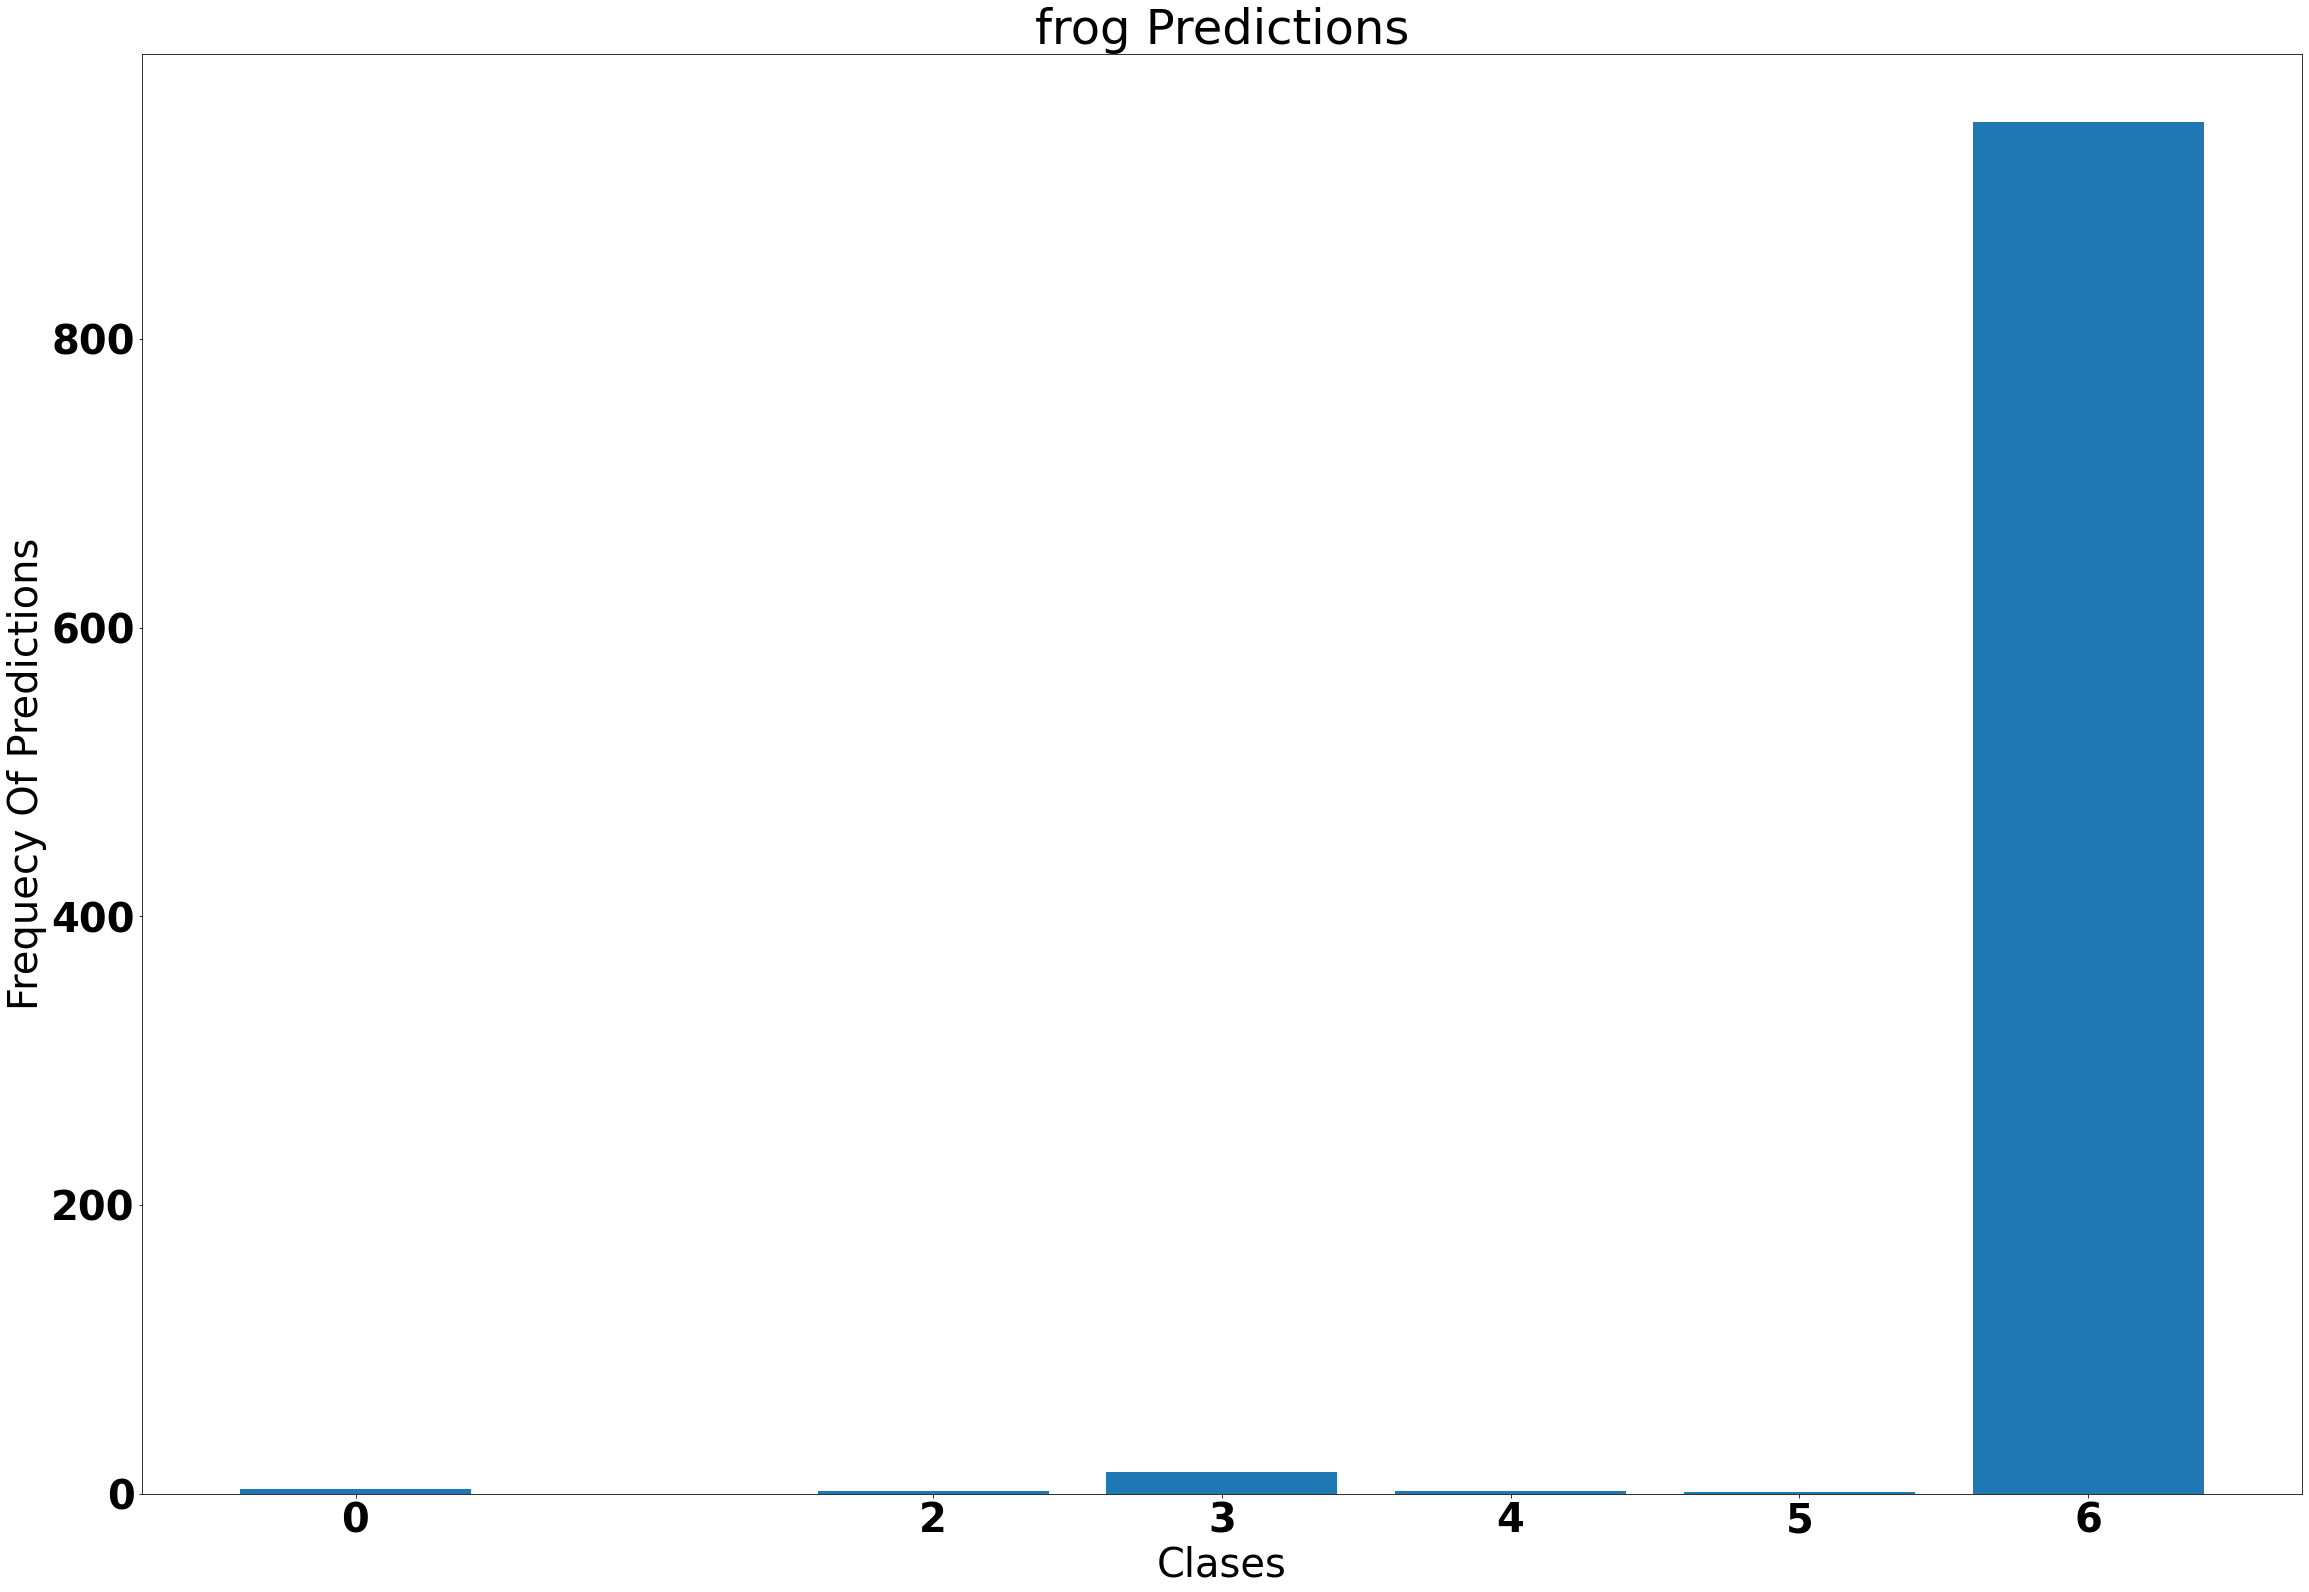

In [23]:
idx = 6
c = returnClassIndex(testY[correct_model_predictions_idx],idx)
plot_class_predictions(pidx[c], idx,cclasses)

Class #7


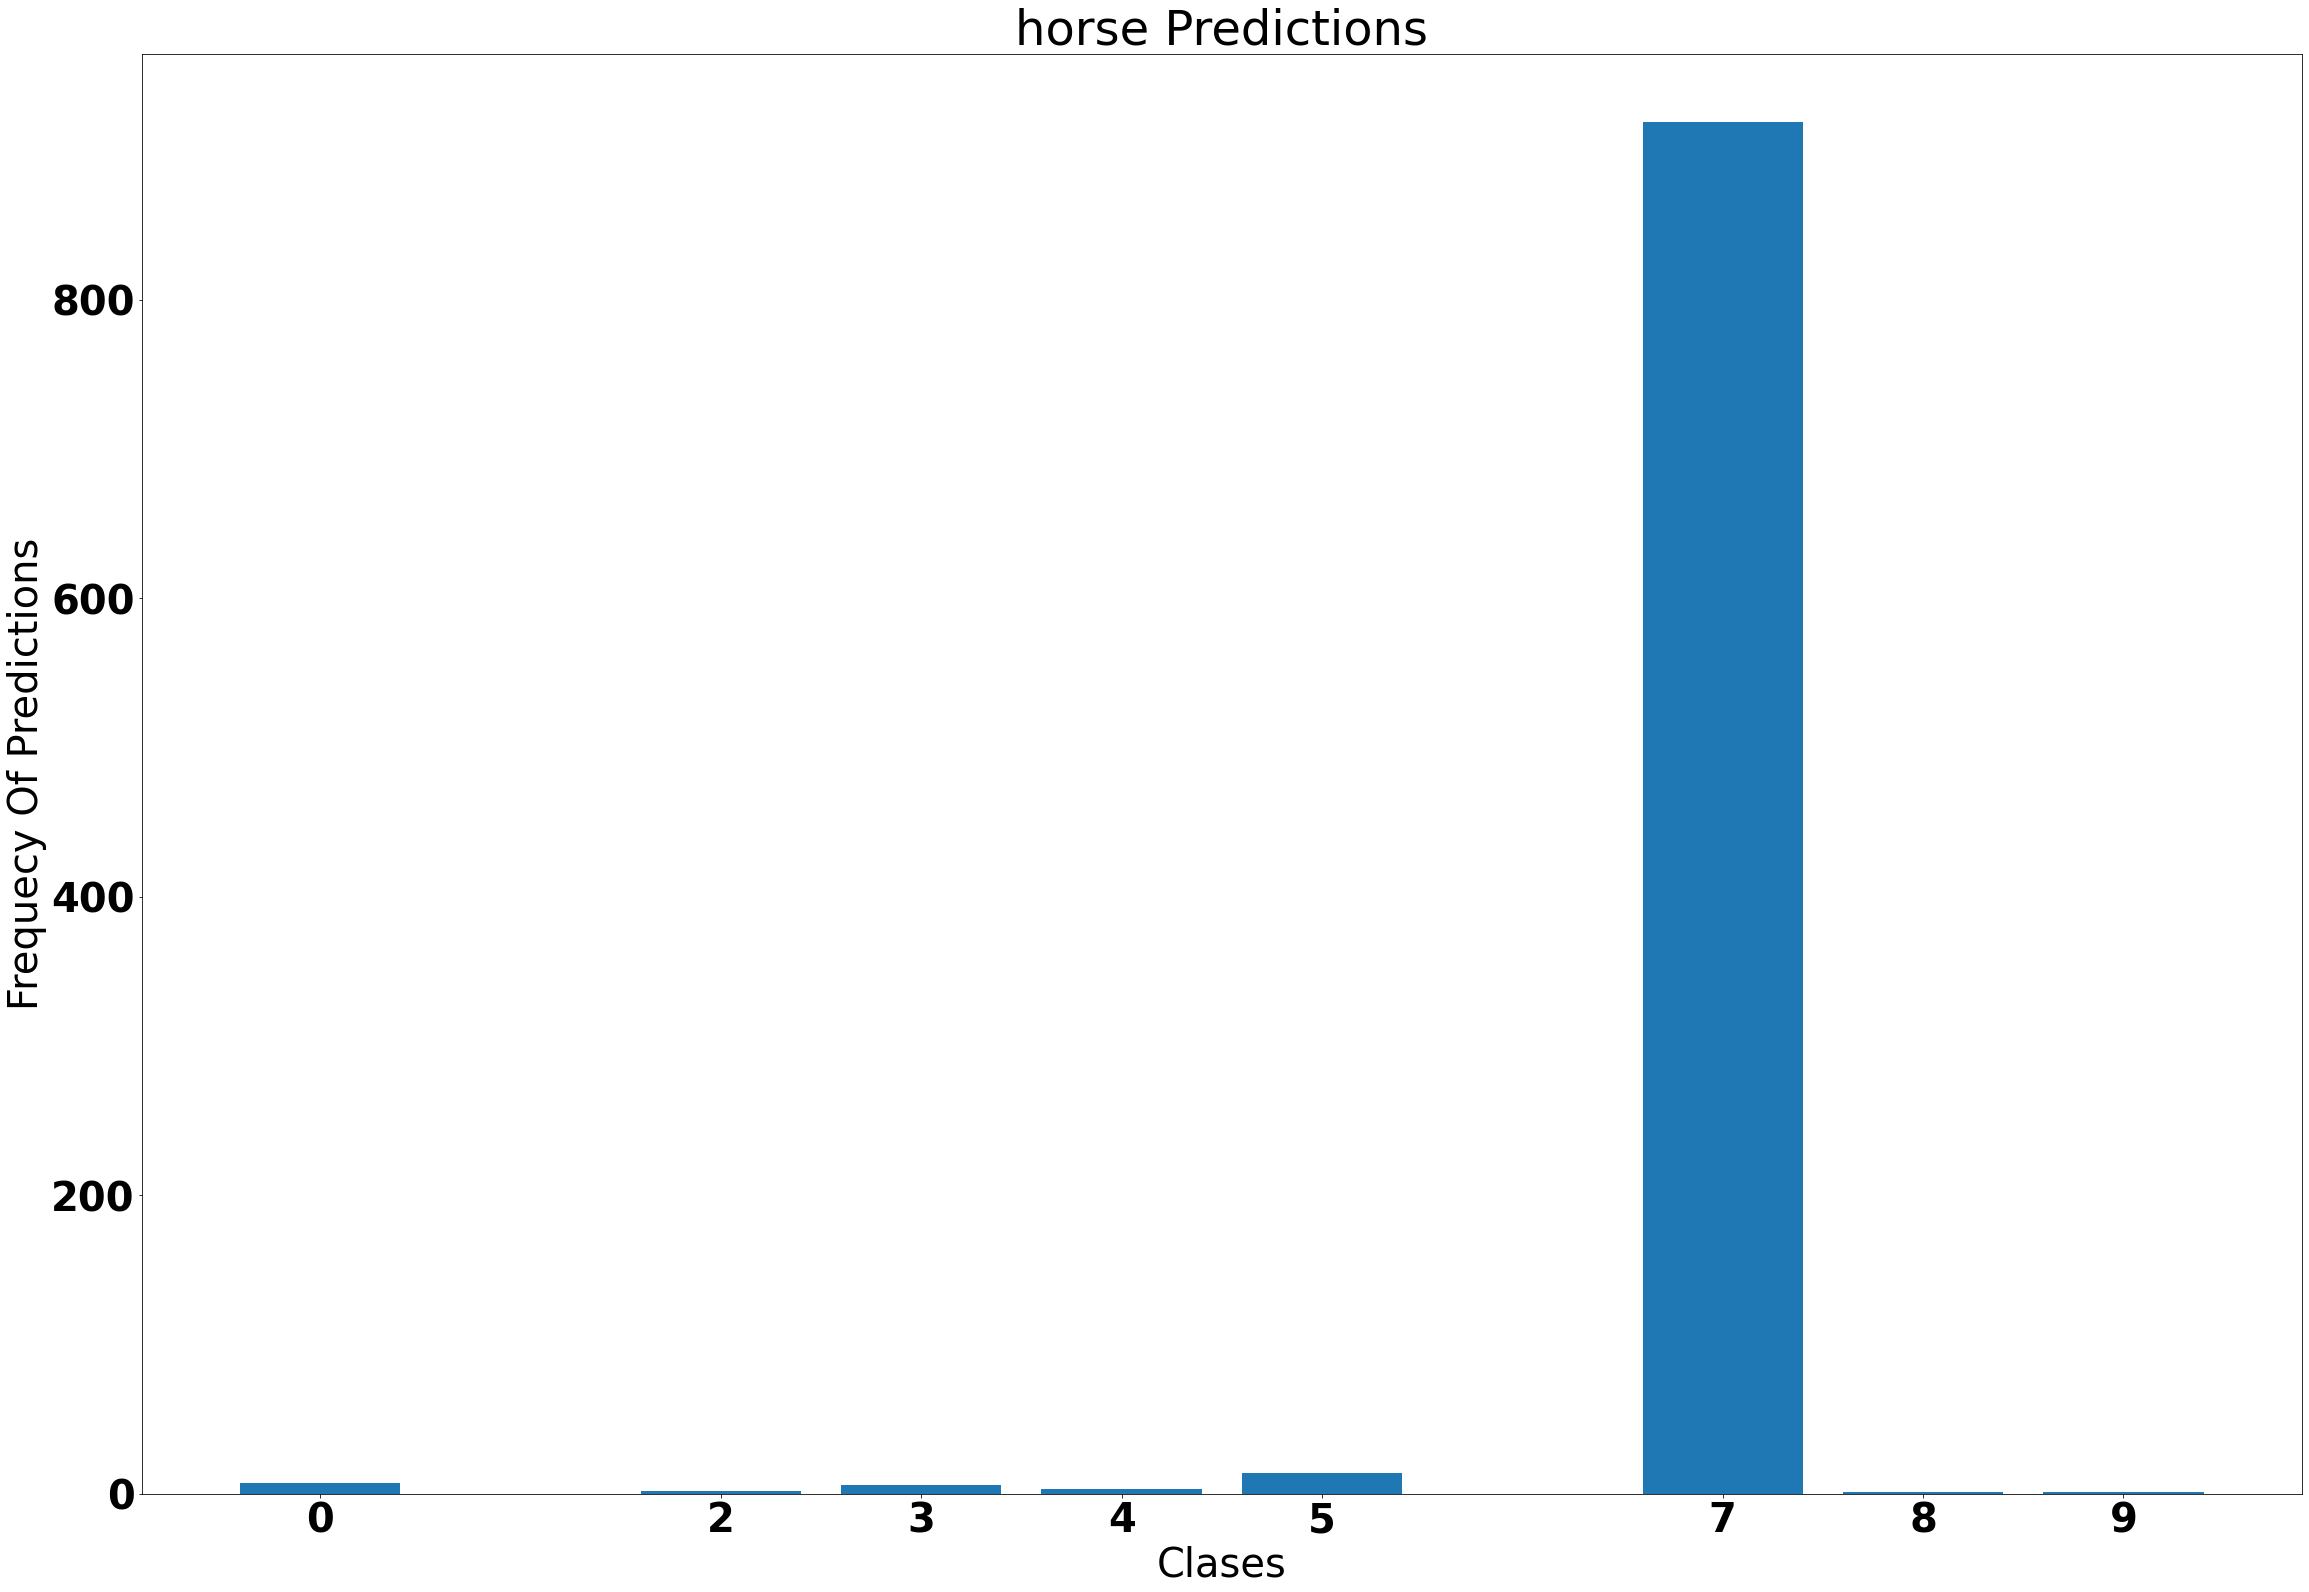

In [24]:
idx = 7
c = returnClassIndex(testY[correct_model_predictions_idx],idx)
plot_class_predictions(pidx[c], idx,cclasses)

Class #8


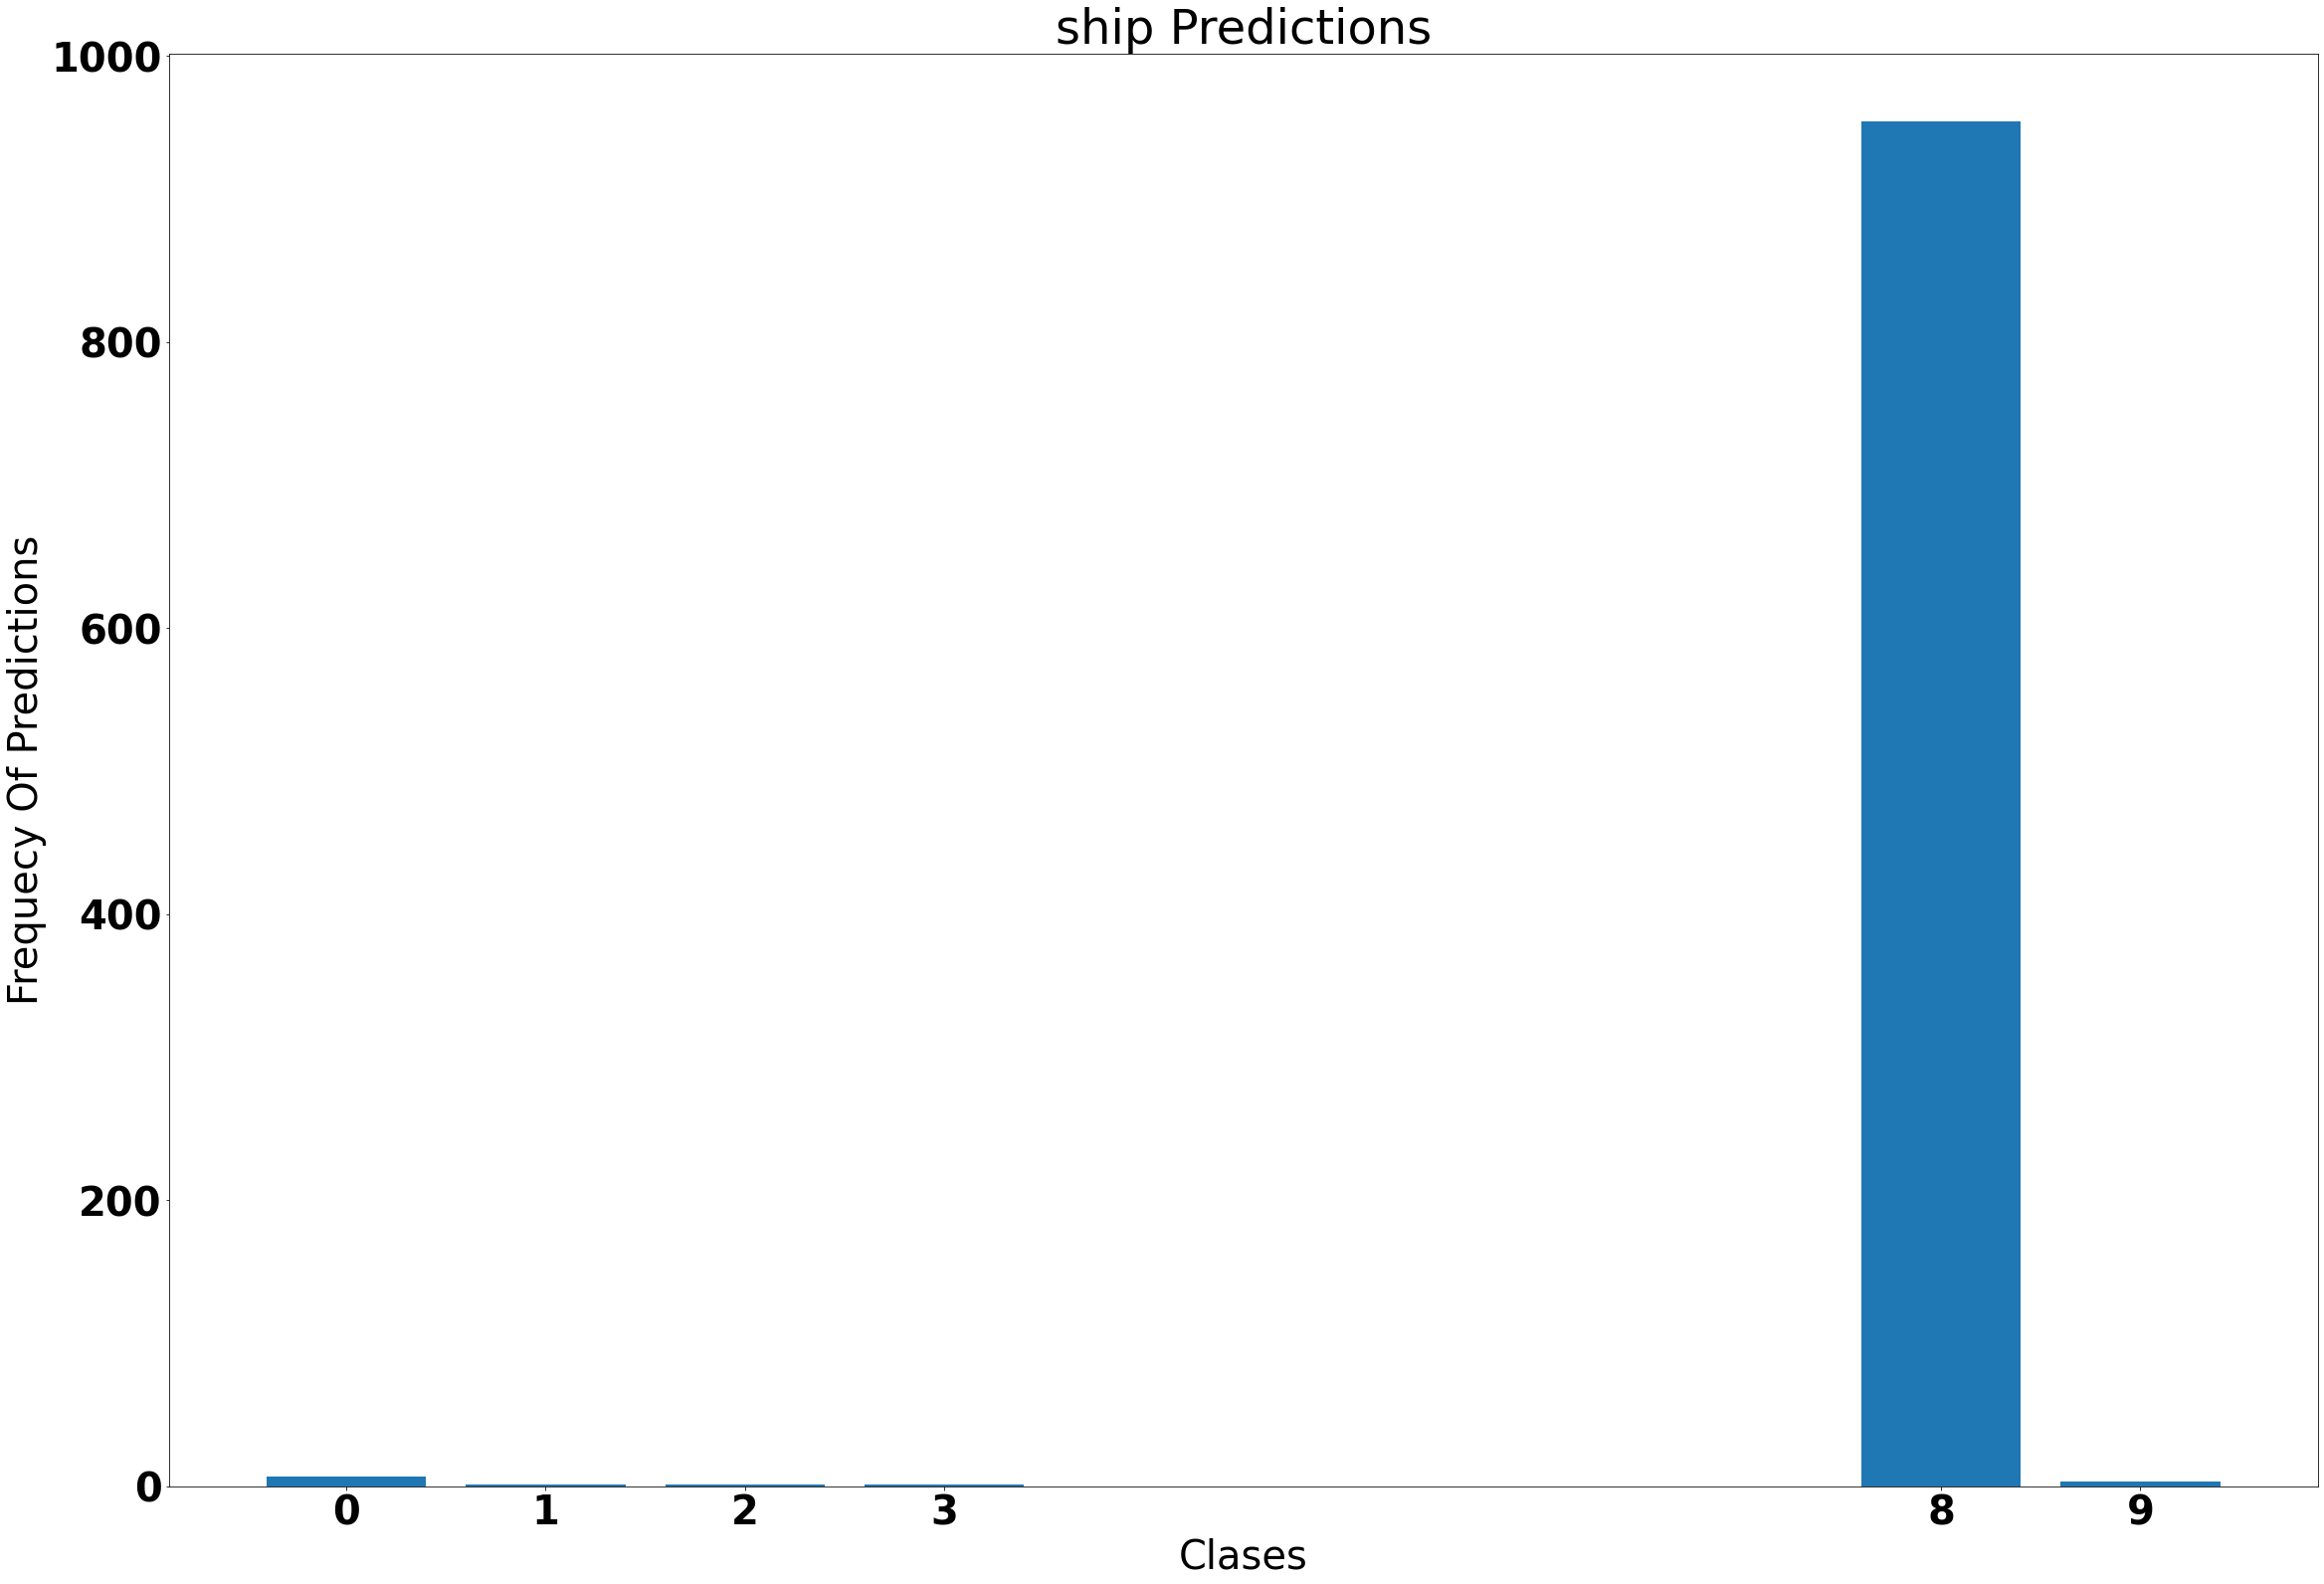

In [25]:
idx = 8
c = returnClassIndex(testY[correct_model_predictions_idx],idx)
plot_class_predictions(pidx[c], idx,cclasses)

# FADL on The Skin Disease Dataset

In [26]:
gnd_truth = pd.read_csv("data\SkinDiseaseDataset\ISIC_2019_Training_GroundTruth.csv")
#aug_df = pd.read_csv("data/augmentImageNameLabels.csv")
gnd_truth.head()

IMG_NAMES = gnd_truth['image']
TRAIN_IMG_RT_PATH = 'data/ISIC_2019_Training_Input/'
TEST_IMG_RT_PATH = 'data/ISIC_2019_Test_Input'
### No Examples of UNK so drop it
labels = np.array(gnd_truth.drop(columns = ["image", "UNK"]))


# of occurences
[ 4522 12875  3323   867  2624   239   253   628]
Classes
[0 1 2 3 4 5 6 7]


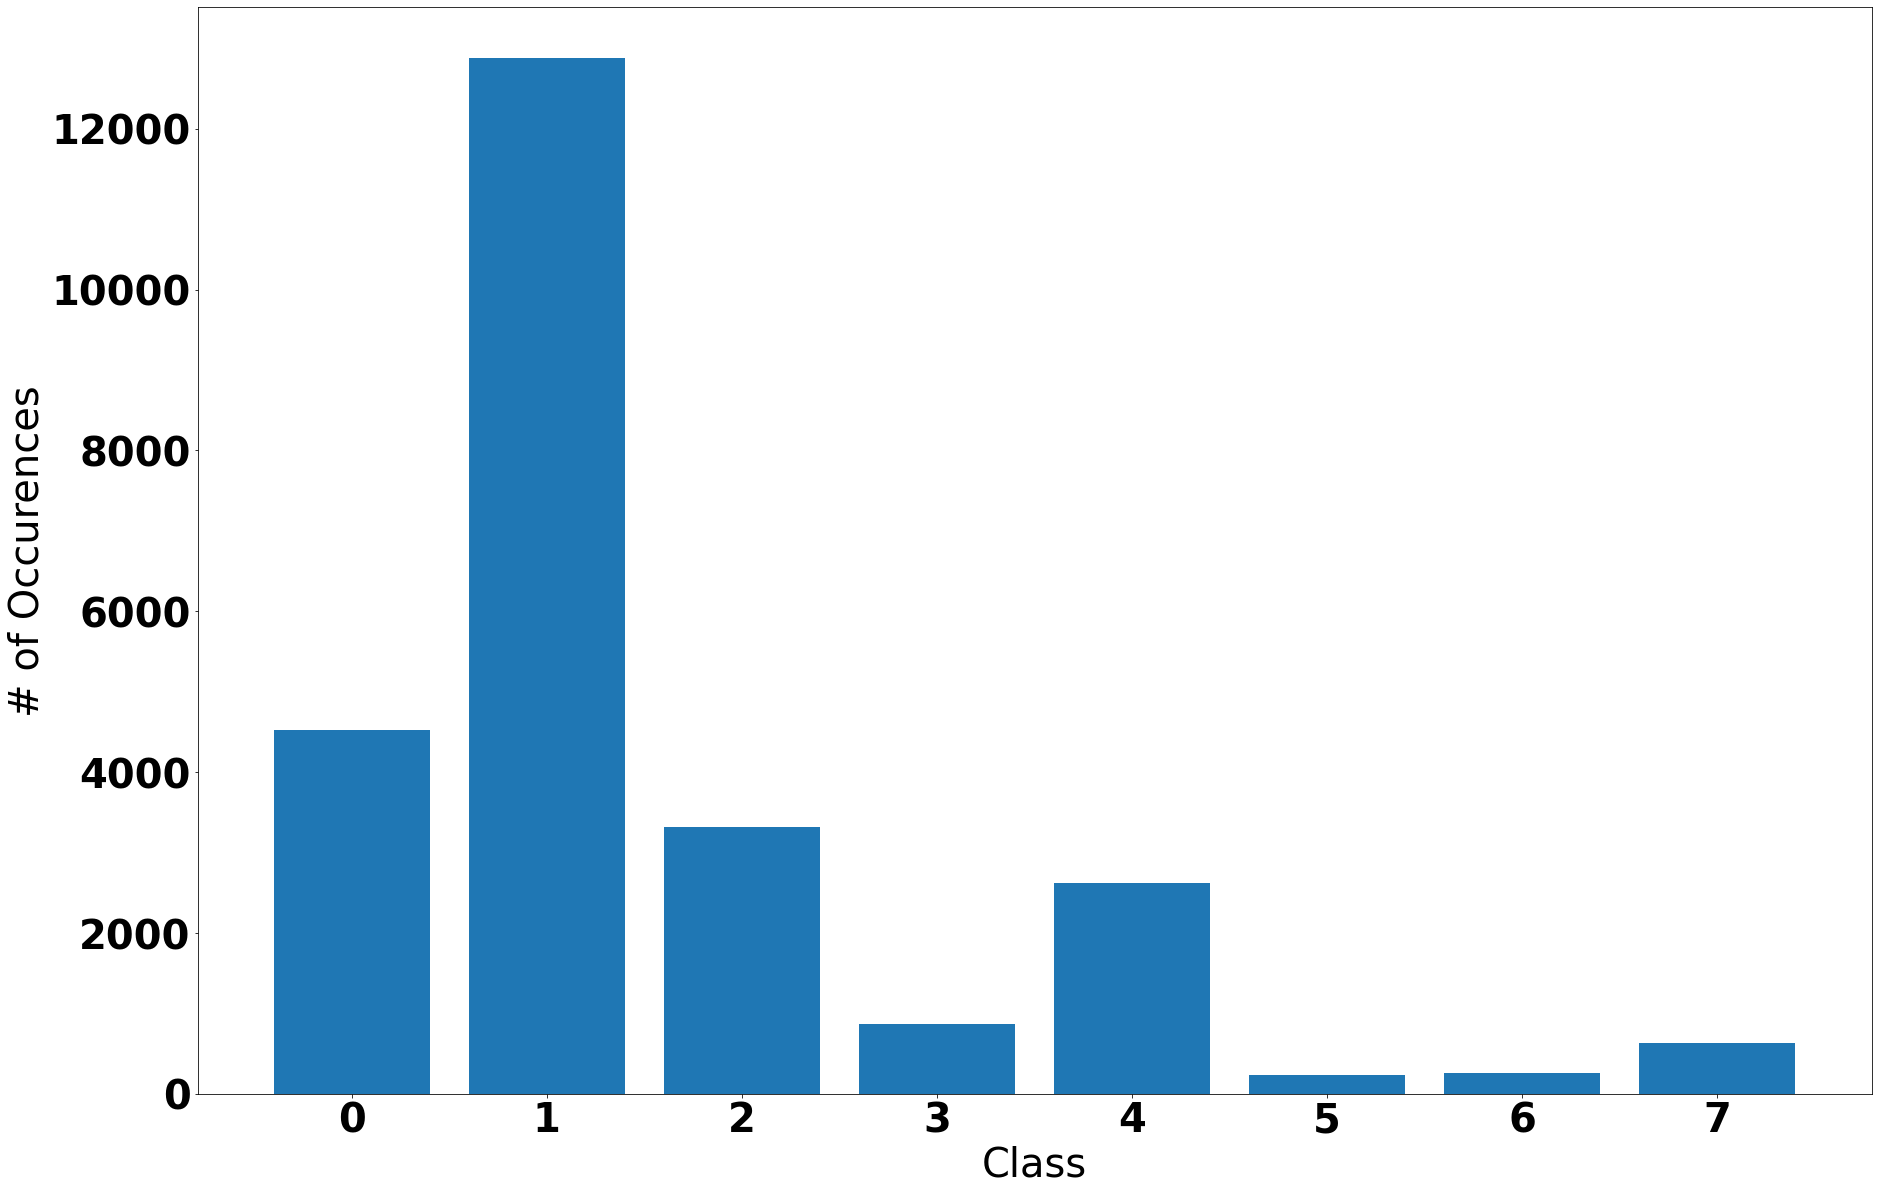

In [28]:
c, freq = np.unique(np.argmax(labels, axis= 1), return_counts = True)
fig = plt.figure( figsize = (30,20))
font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 40}
matplotlib.rc('font', **font)
plt.xlabel("Class")
plt.ylabel("# of Occurences")
plt.bar(c,freq)
print("# of occurences")
print(freq)
print("Classes")
print(c)

In [29]:
def returnClassIndex(trainY,class_index):
    labels = np.argmax(trainY, axis = 1)
    return [ i for i in range(len(labels)) if labels[i] == class_index]


### Randomly Balance Sample from classes  
smpl_test_idxs = []
smpl_train_idxs = []
for i in range(len(labels[1])):
    idxs = np.array(returnClassIndex(labels, i))
    sel = np.random.RandomState(seed = 42).permutation(len(idxs))
    #print(len(idxs))
    ### Shuffle
    train_sel = list(sel[:int(0.75*len(idxs))])
    test_sel = list(sel[int(0.75*len(idxs)):])
    smpl_train_idxs += list(idxs[train_sel])
    smpl_test_idxs += list(idxs[test_sel])

paths = np.array([TRAIN_IMG_RT_PATH + m +'.jpg' for m in IMG_NAMES ])

In [30]:
im_size =200
channels = 3
num_classes = 8
lr = 0.001 ### learning rate
input_shape = ( im_size, im_size, channels)
l1_lambda = 0 ### L1 regularization lambda parameter
l2_lambda = 0
keep_prob =  0
batch_size = 16

In [31]:
### Dataframes for Generator
train_df = pd.DataFrame({"filename":paths[smpl_train_idxs],
                        "class": np.argmax(labels, axis = 1)[smpl_train_idxs].astype(str)})
test_df = pd.DataFrame({"filename":paths[smpl_test_idxs],
                        "class": np.argmax(labels, axis = 1)[smpl_test_idxs].astype(str)})

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1.0/255,
        samplewise_center = True,
        samplewise_std_normalization = True, 
        horizontal_flip=True,
        vertical_flip = True,
        shear_range=0.5,
        zoom_range=0.5,
        rotation_range = 30
)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    class_mode = 'categorical',
    y_col="class",
    batch_size = batch_size, 
    target_size = (im_size, im_size)
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    class_mode = 'categorical',
    y_col="class",
    batch_size = batch_size,
    target_size = (im_size, im_size)
)

Found 18996 validated image filenames belonging to 8 classes.
Found 6335 validated image filenames belonging to 8 classes.


In [32]:
MODEL_LIST[0].evaluate(test_generator)

  ...
    to  
  ['...']
396/396 [==============================] - 85s 216ms/step - loss: 0.3081 - acc: 0.8896


[0.3080813630738042, 0.8895817]

In [33]:
print("Performing predictions....")
print("May take a while")
pred1 = []
pred0 = []
labels = []
for i in tqdm(range(len(test_generator) -1)):
    tmp = next(test_generator)
    for i0 in range(16):
        pred1.append(MODEL_LIST[1].predict(
            np.expand_dims(cv2.resize(tmp[0][i0], (32, 32)), axis = 0)))
    pred0.append(MODEL_LIST[0].predict(tmp[0]))
    labels.append(tmp[1])
p0 = np.vstack(pred0)
p1 = np.vstack(pred1)
test_labels = np.vstack(labels)

  0%|                                                                                          | 0/395 [00:00<?, ?it/s]

Performing predictions....
May take a while


100%|████████████████████████████████████████████████████████████████████████████████| 395/395 [07:03<00:00,  1.07s/it]


In [34]:
p0 = np.vstack(pred0)
p1 = np.vstack(pred1)
test_labels = np.vstack(labels)

In [35]:
n = 0
correct_model_predictions_idx = []
for i in tqdm(range(len(p0))):
    if(np.amax(p1[i])>np.amax(p0[i])):
        n = n+1
    else:
        correct_model_predictions_idx.append(i)
print("{} samples were passed to the wrong model.".format(n))
print("This is because the wrong model had a higher confidence value.")
pidx = np.argmax(p0, axis = 1)[correct_model_predictions_idx]
groundTruth = np.argmax(test_labels, axis = 1)[correct_model_predictions_idx]
from sklearn.metrics import accuracy_score
acc = accuracy_score(groundTruth,pidx)
print("Accuracy",acc)

100%|██████████████████████████████████████████████████████████████████████████| 6320/6320 [00:00<00:00, 112836.50it/s]

1945 samples were passed to the wrong model.
This is because the wrong model had a higher confidence value.
Accuracy 0.6066285714285714


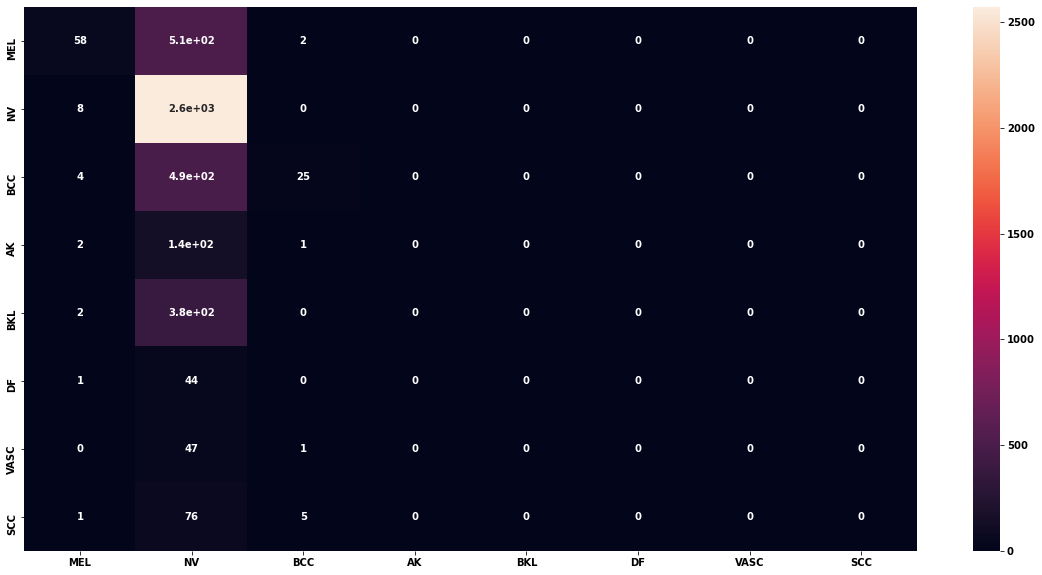

In [36]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
conf = tf.math.confusion_matrix(groundTruth,pidx)
font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 10}
matplotlib.rc('font', **font)
labels_names = list(gnd_truth.columns[1:-1])
df_cm = pd.DataFrame(np.array(conf), index = [i for i in labels_names],
                  columns = [i for i in labels_names])
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)

In [39]:
from sklearn.metrics import roc_auc_score

In [37]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_curve
f1 = f1_score(groundTruth, pidx, average = "macro")
acc = accuracy_score(groundTruth,pidx)
recall = recall_score(groundTruth, pidx, average = "macro")
precision =precision_score(groundTruth, pidx, average = "macro")

print("Metrics")
print()
print("Accuracy: {}".format(acc))
print("F1 Score: {}".format(f1))
print("recall Score: {}".format(recall))
print("Precision Score: {}".format(precision))

Metrics

Accuracy: 0.6066285714285714
F1 Score: 0.1274428957174593
recall Score: 0.14321805823551473
Precision Score: 0.26265820143075436


c:\users\user\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


c:\users\user\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


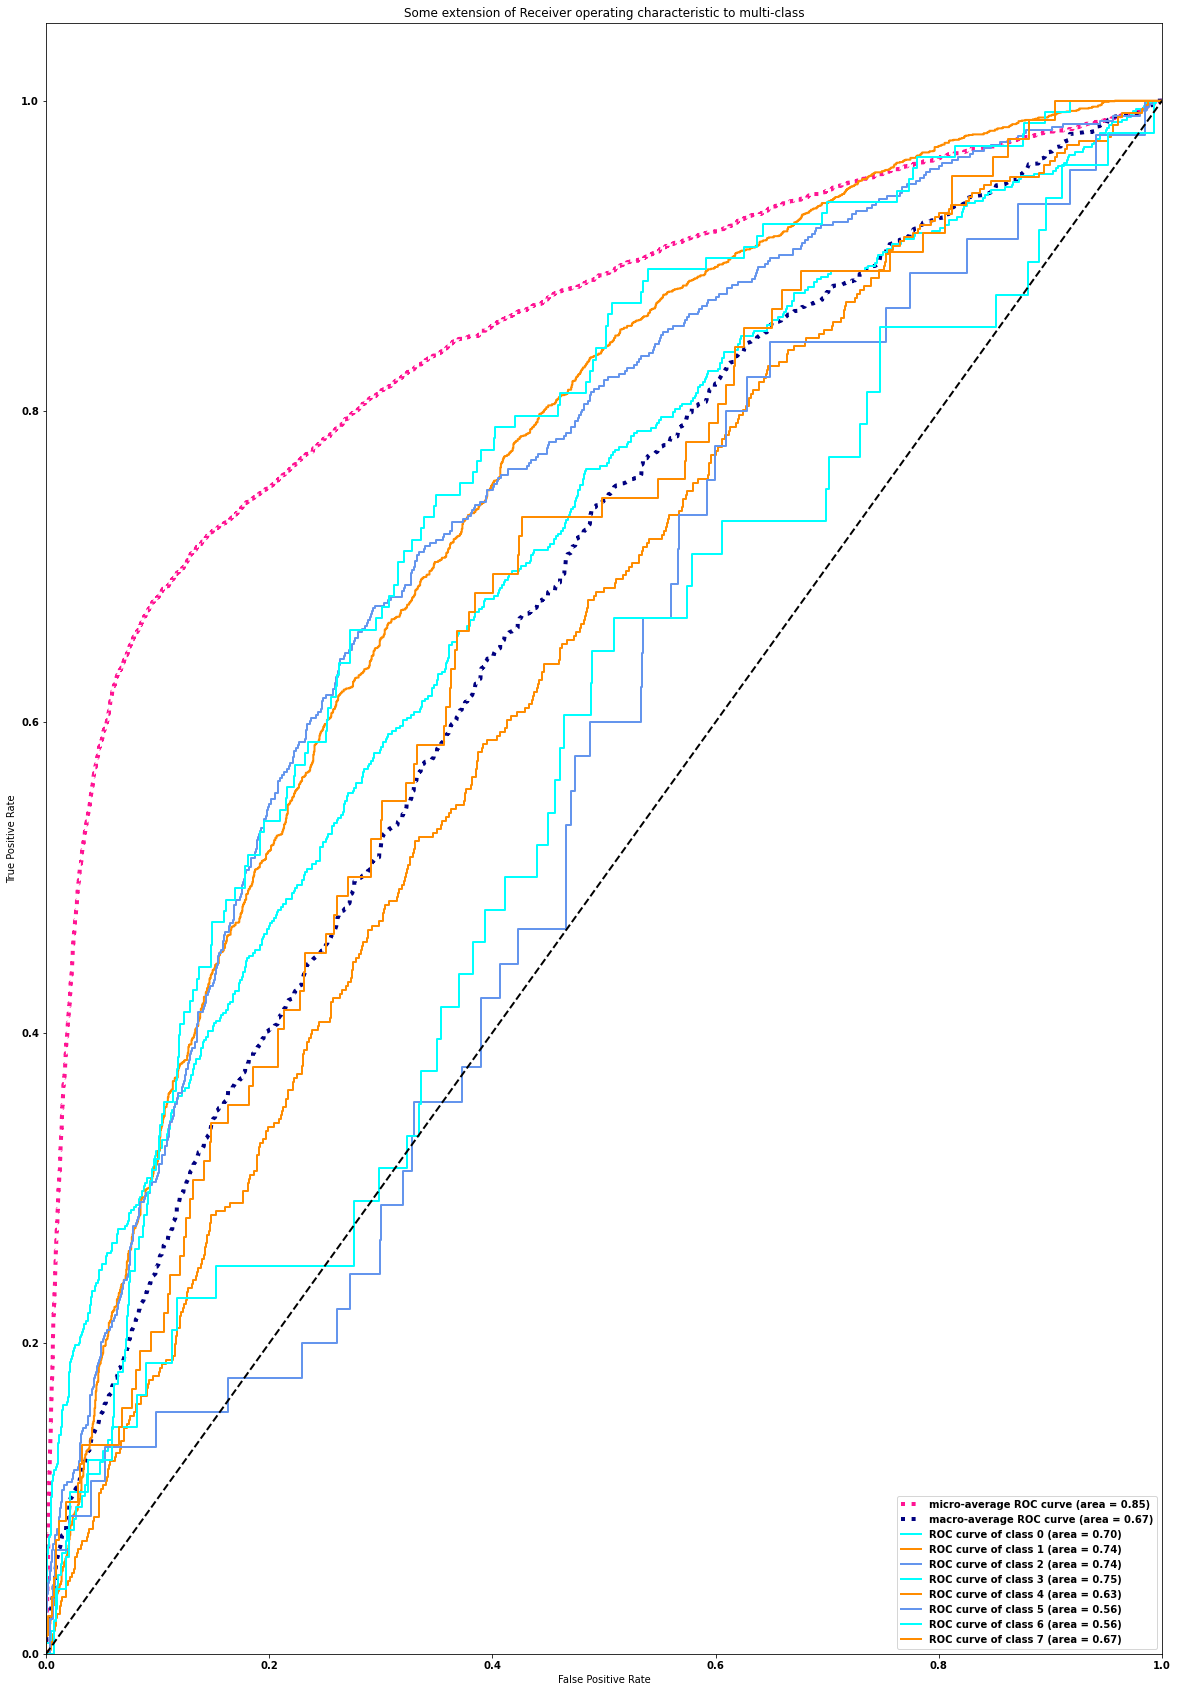

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
y_test = np.copy(test_labels[correct_model_predictions_idx])
y_score = np.copy(p0[correct_model_predictions_idx])
n_classes =  8
lw =2
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (20, 30))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [44]:
sclasses = list(gnd_truth.columns[1:-1])

In [45]:
sclasses

Index(['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC'], dtype='object')

Class #0


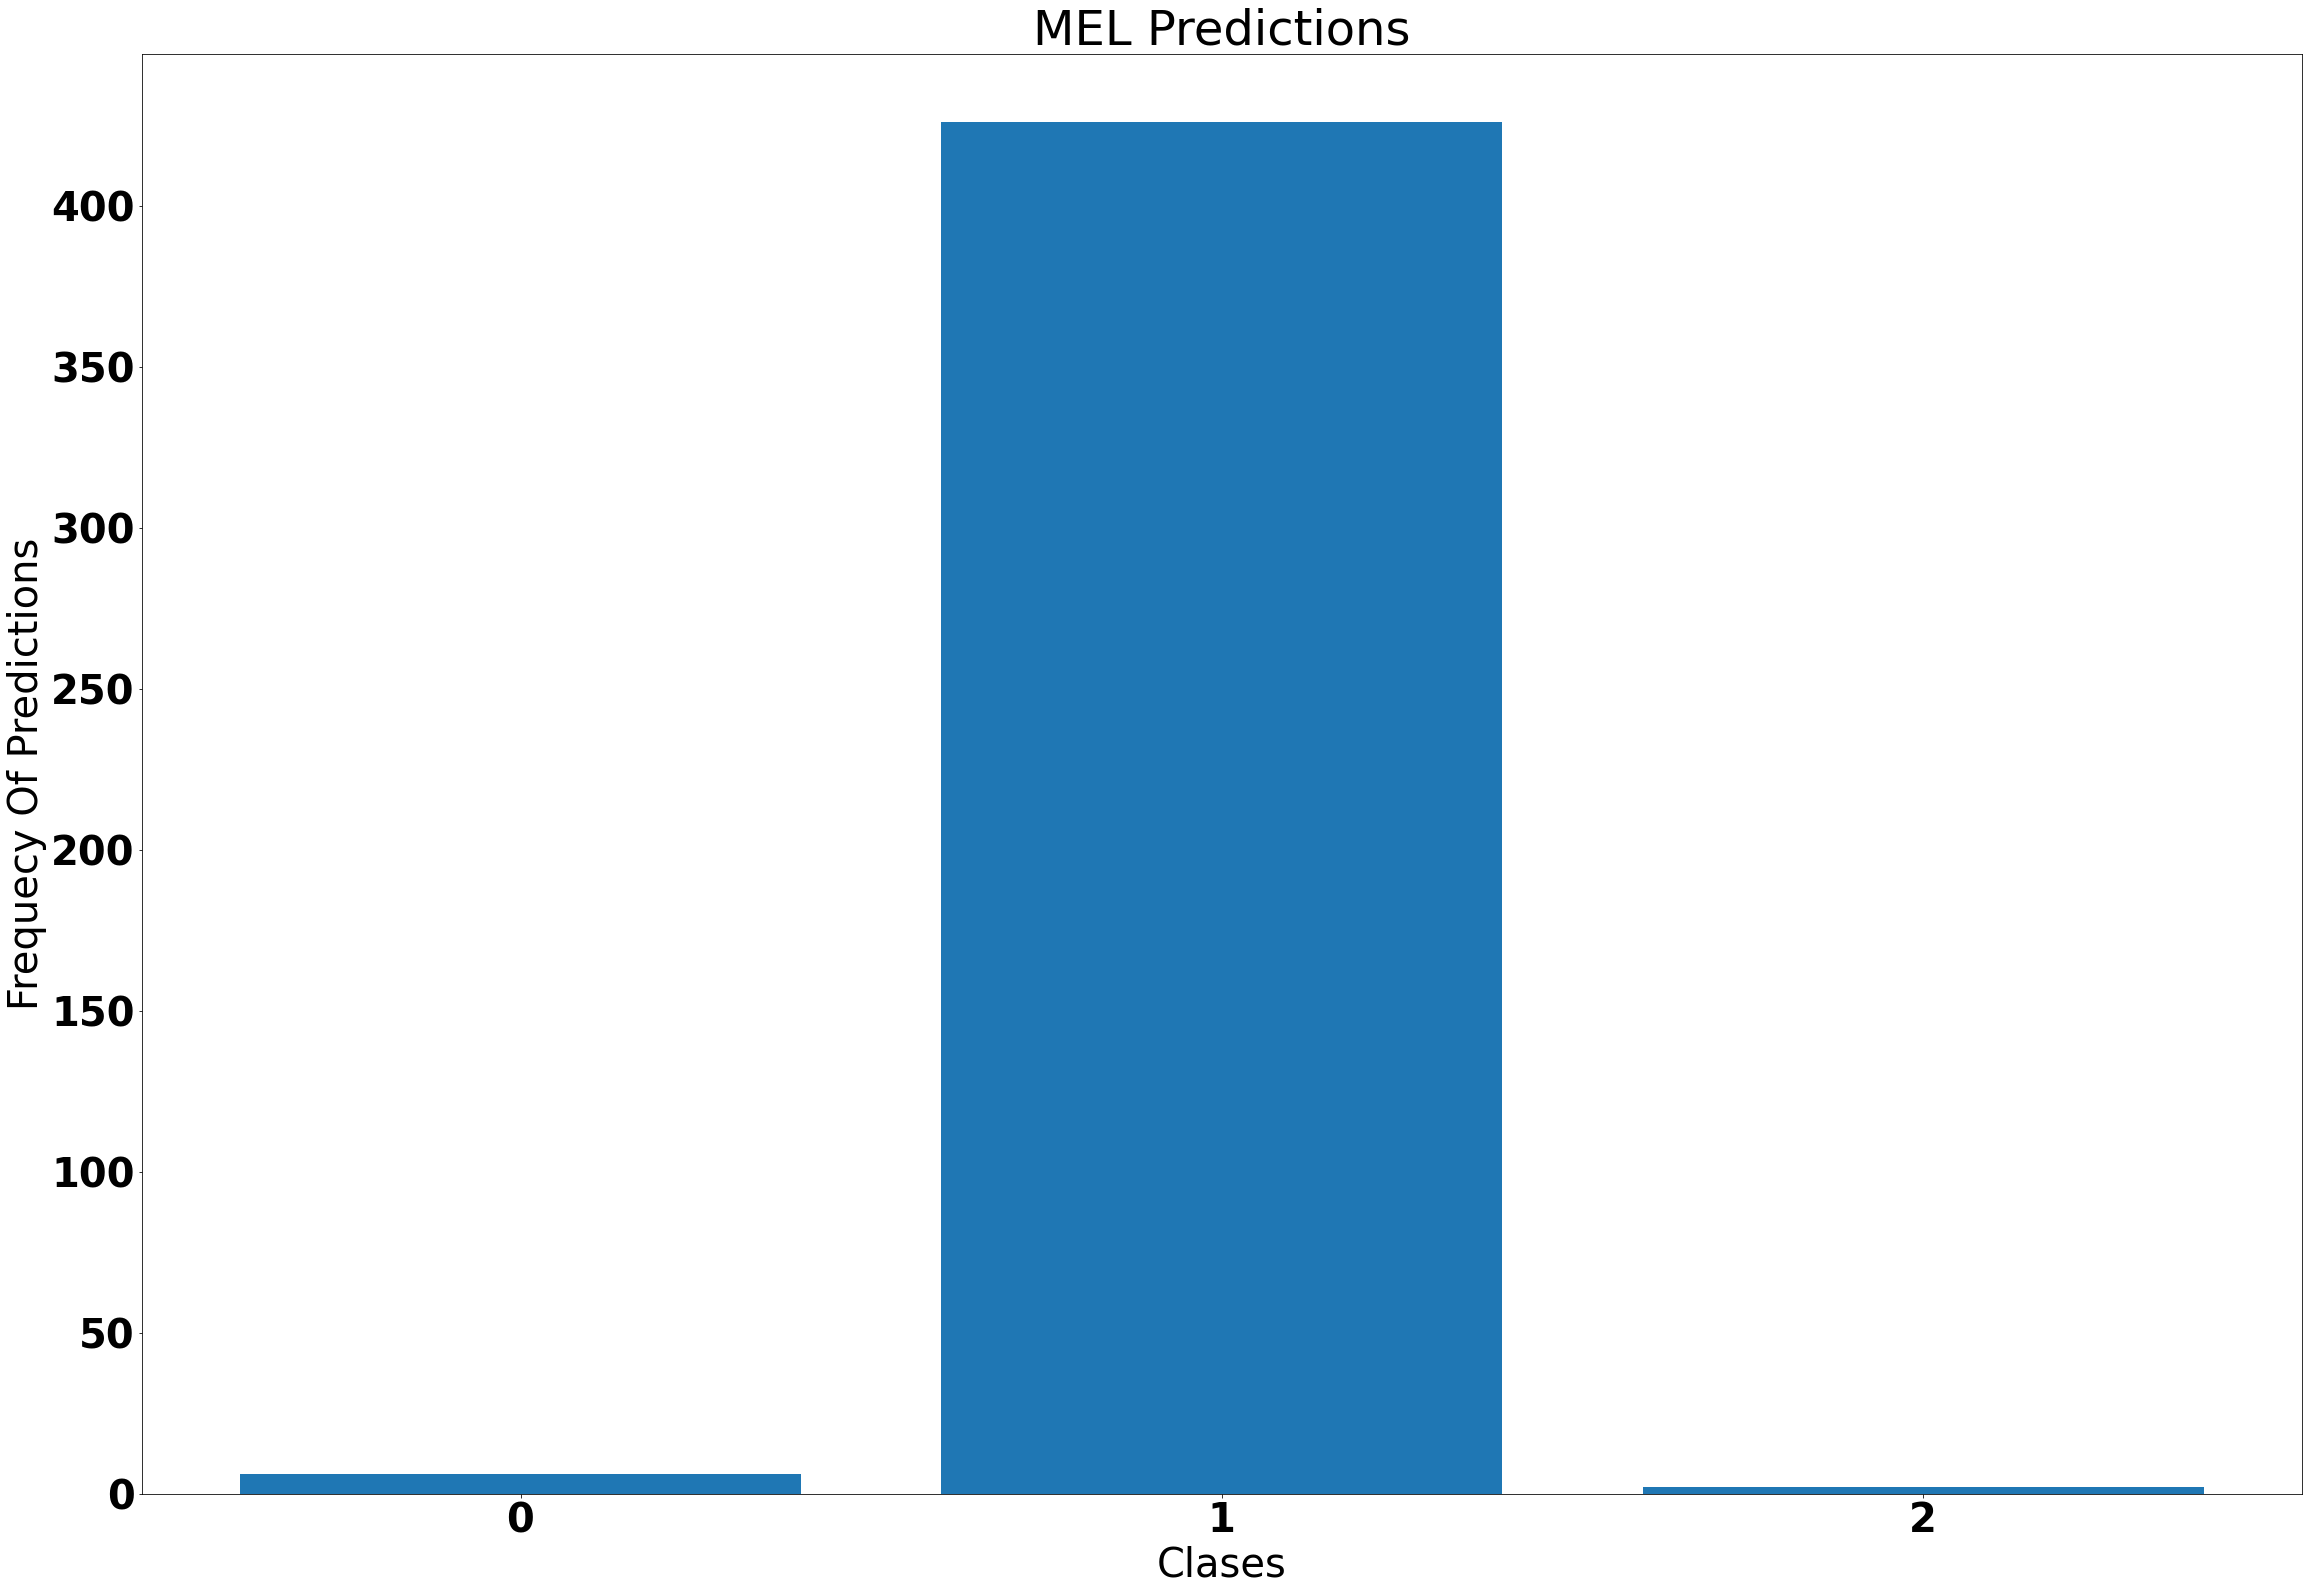

In [46]:
idx = 0
c = returnClassIndex(testY[correct_model_predictions_idx],idx)
plot_class_predictions(pidx[c], idx,sclasses)

Class #1


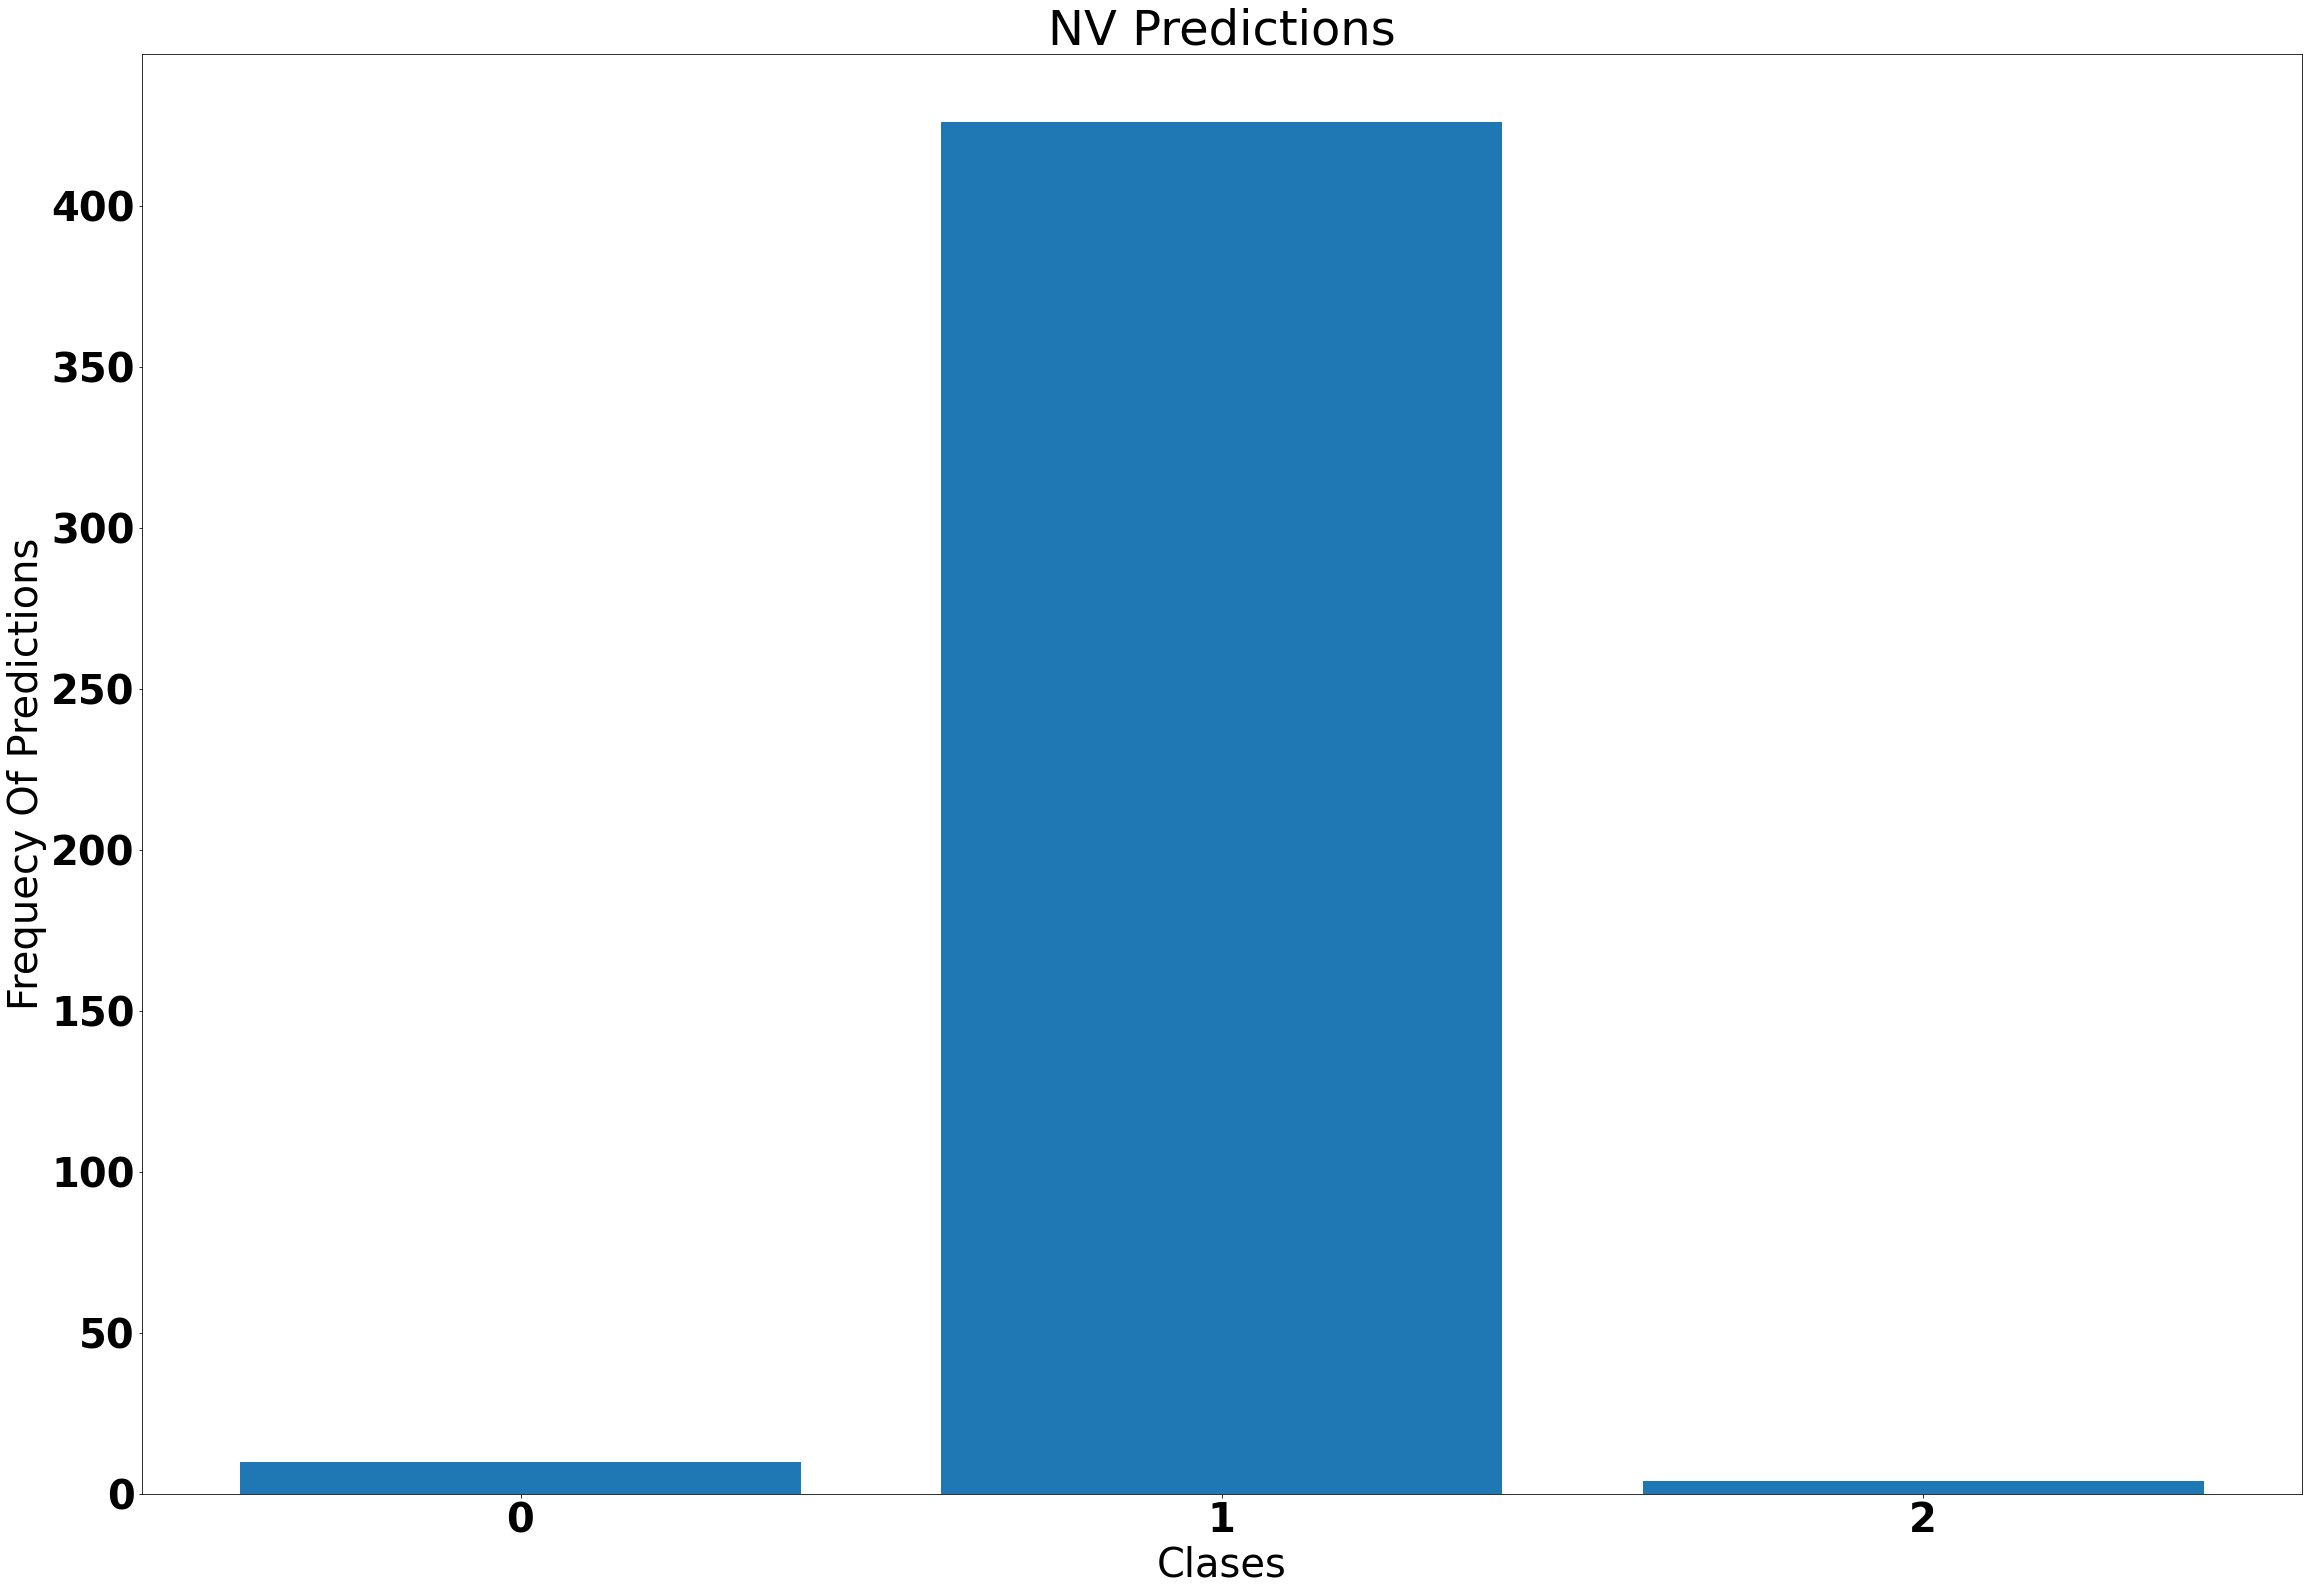

In [47]:
idx = 1
c = returnClassIndex(testY[correct_model_predictions_idx],idx)
plot_class_predictions(pidx[c], idx,sclasses)

Class #2


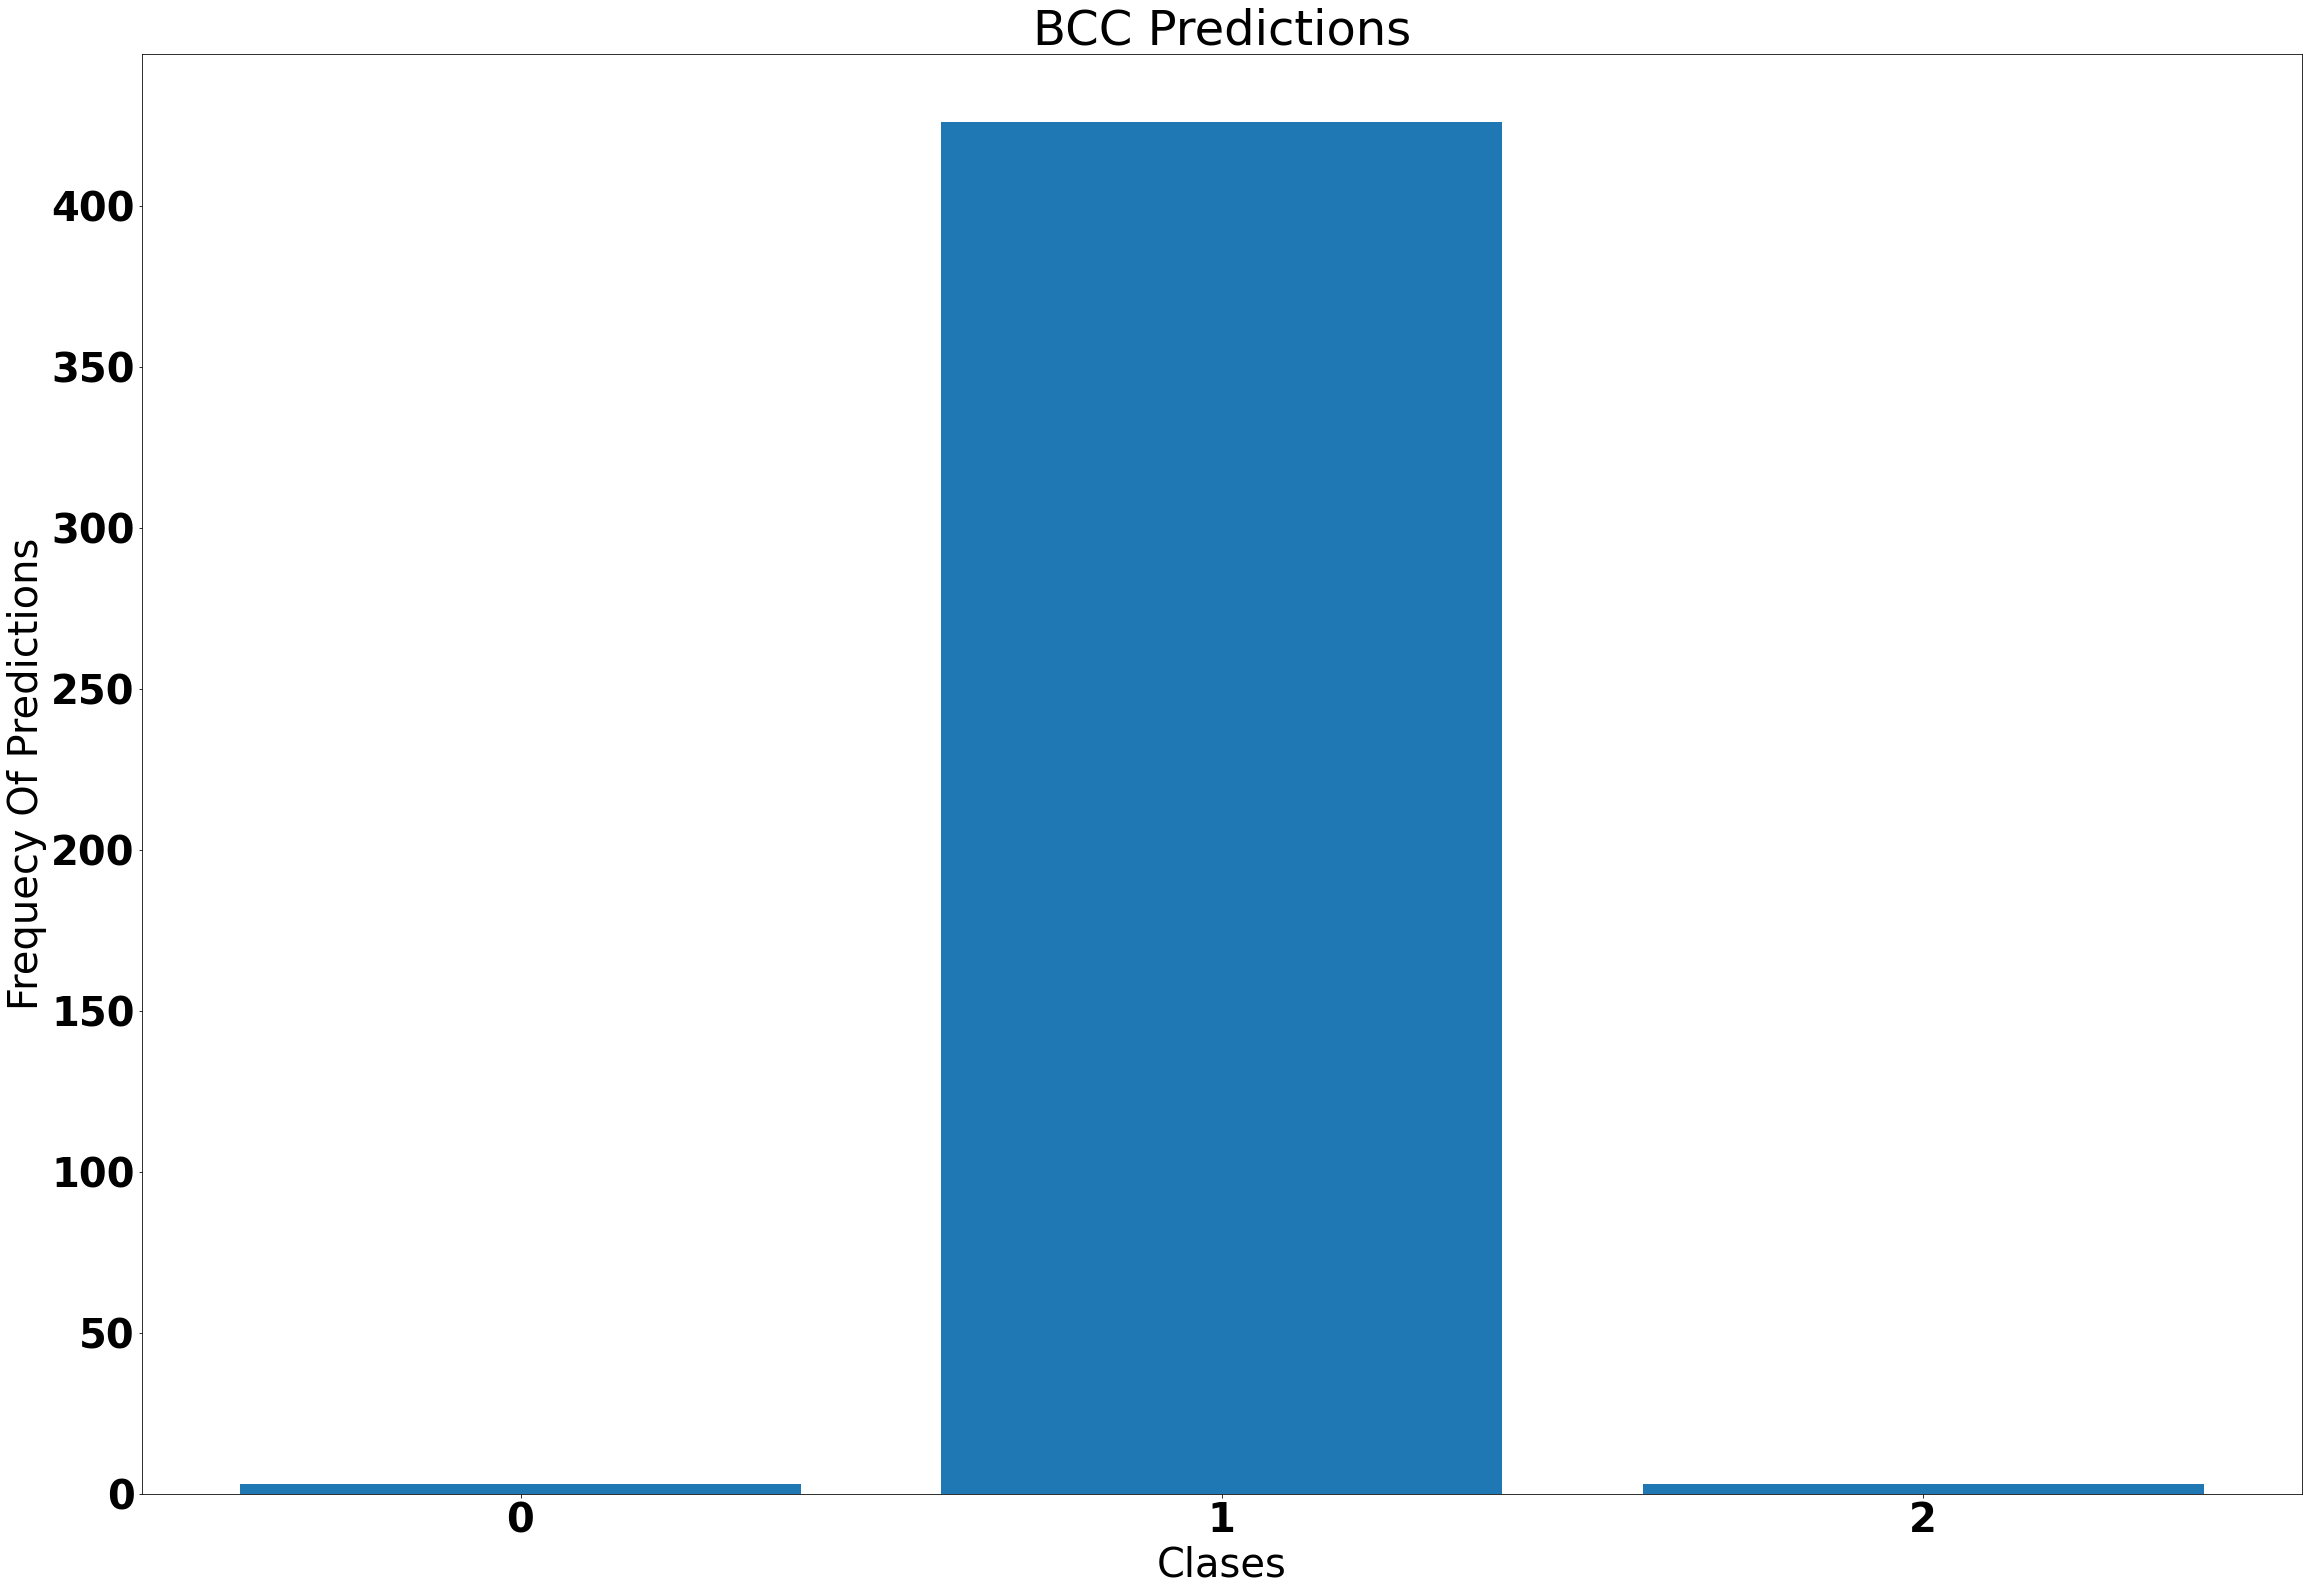

In [48]:
idx = 2
c = returnClassIndex(testY[correct_model_predictions_idx],idx)
plot_class_predictions(pidx[c], idx,sclasses)

Class #3


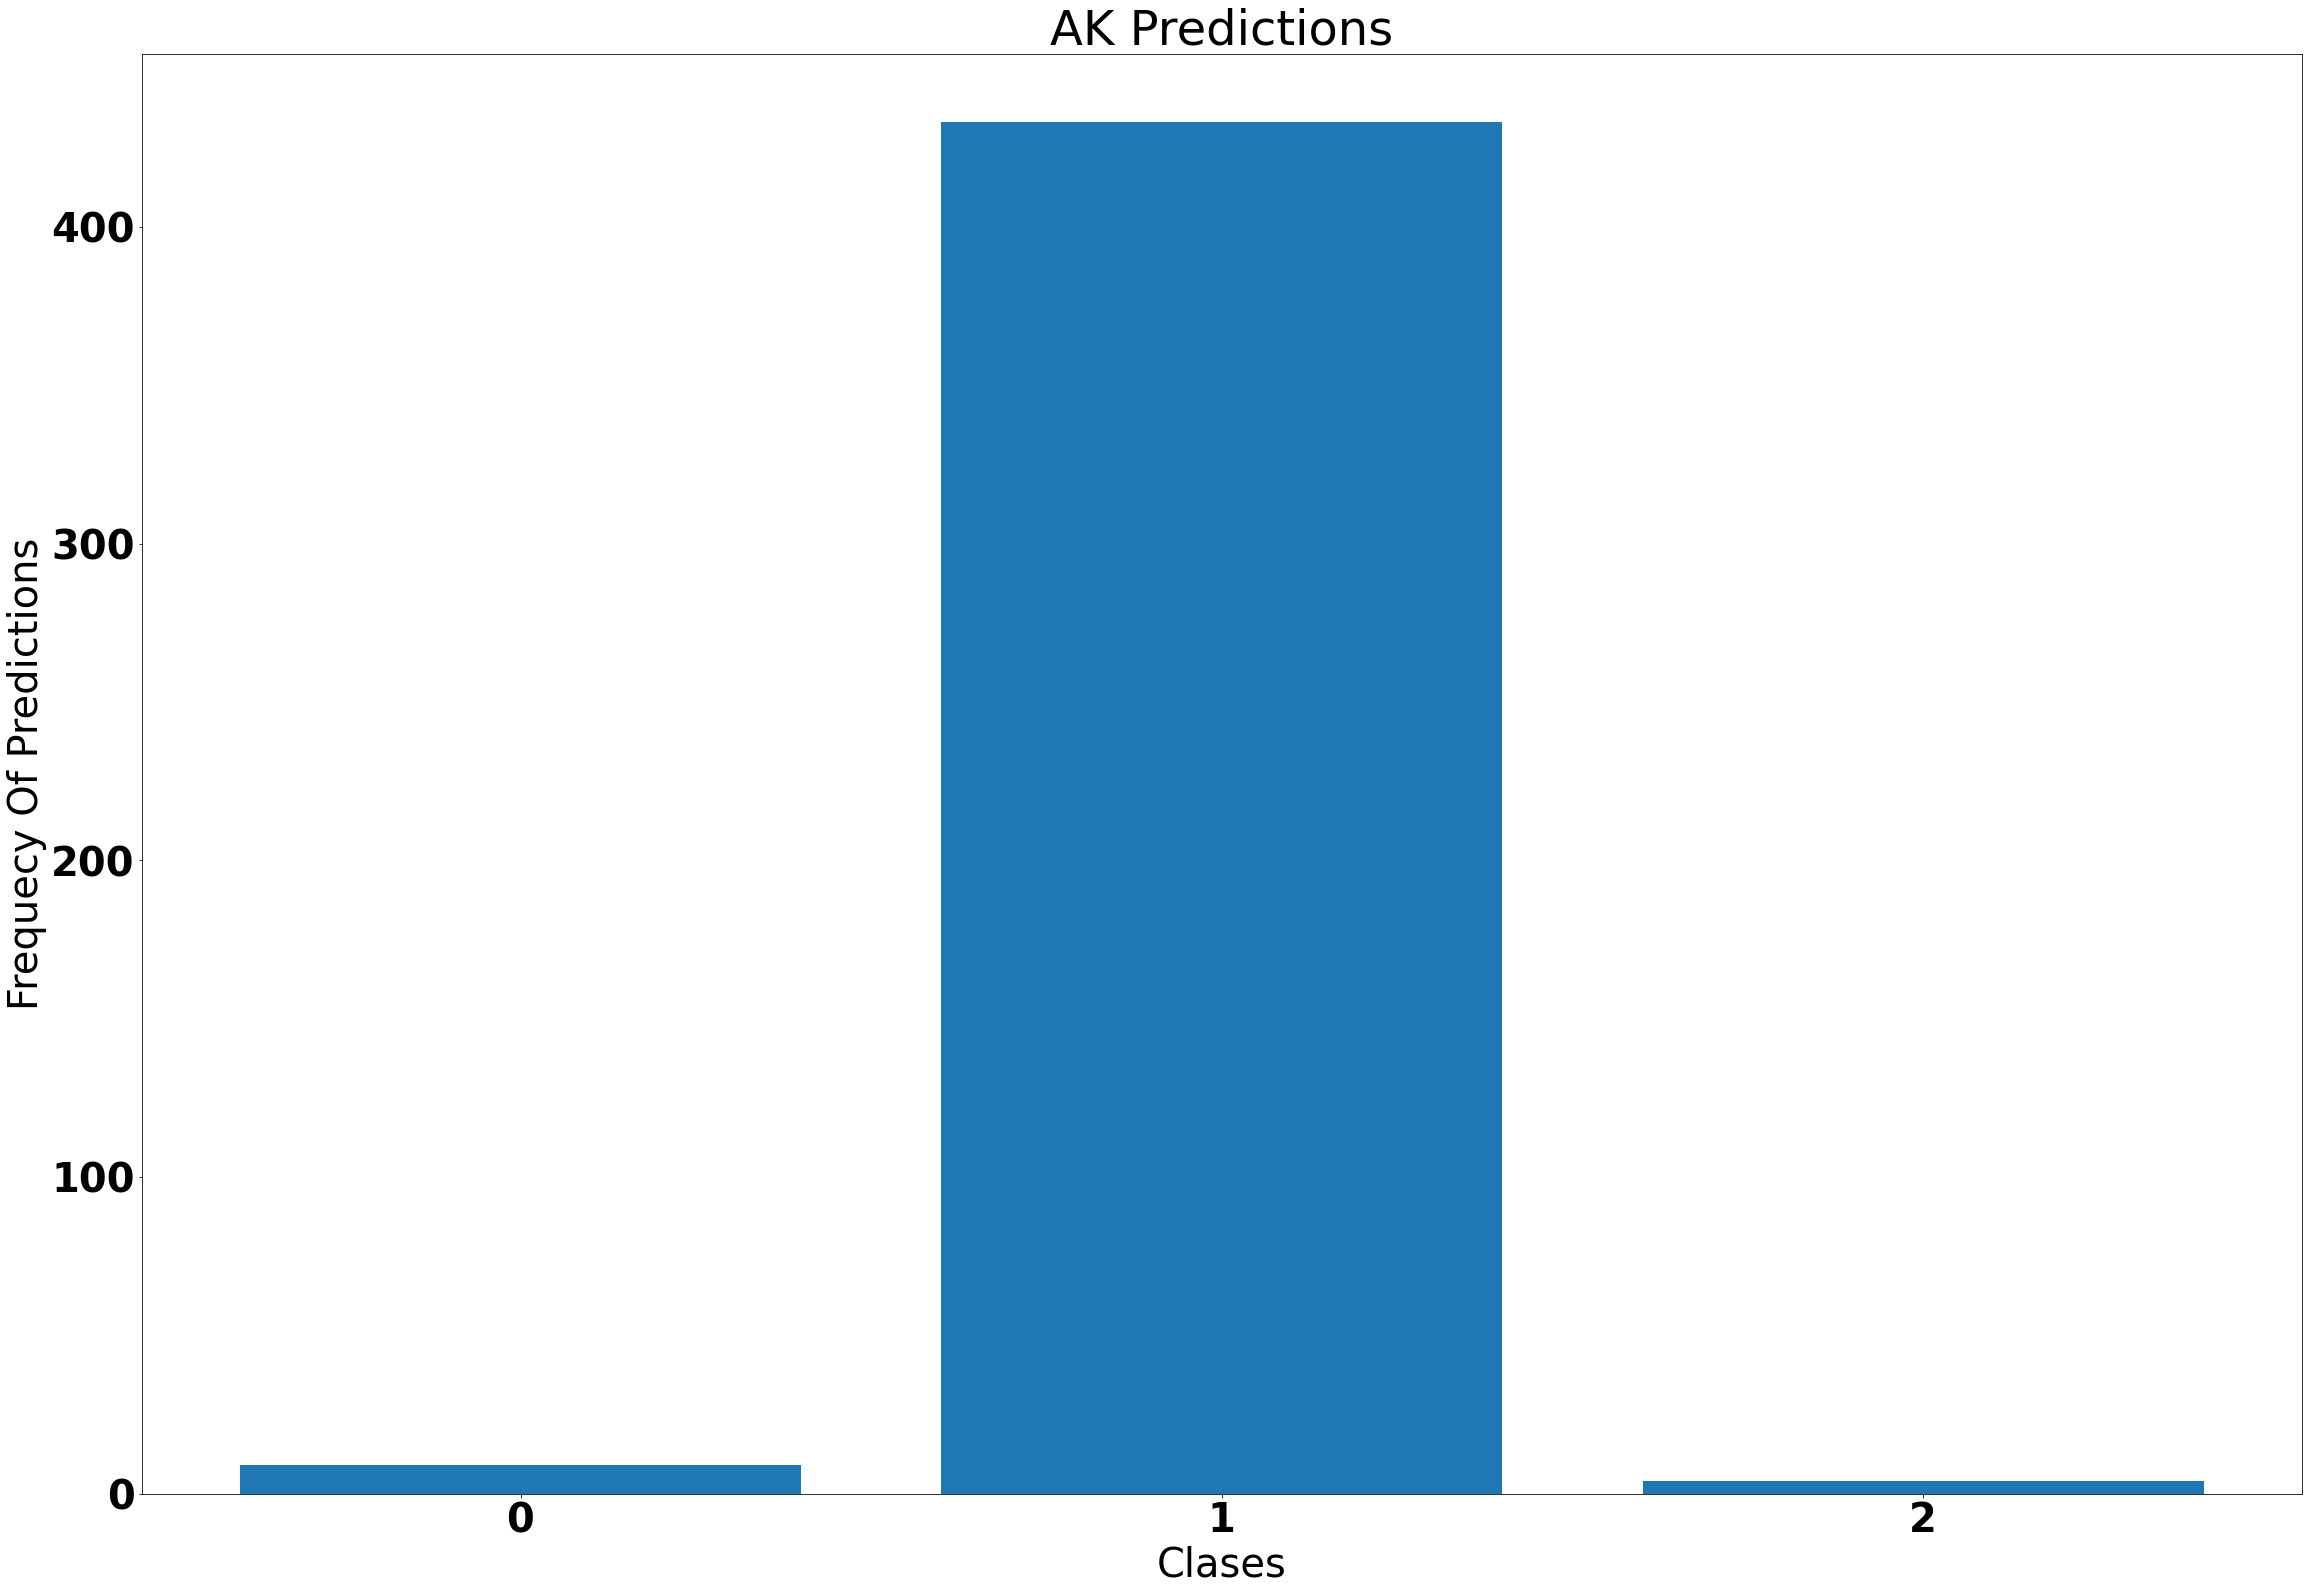

In [49]:
idx = 3
c = returnClassIndex(testY[correct_model_predictions_idx],idx)
plot_class_predictions(pidx[c], idx,sclasses)

Class #4


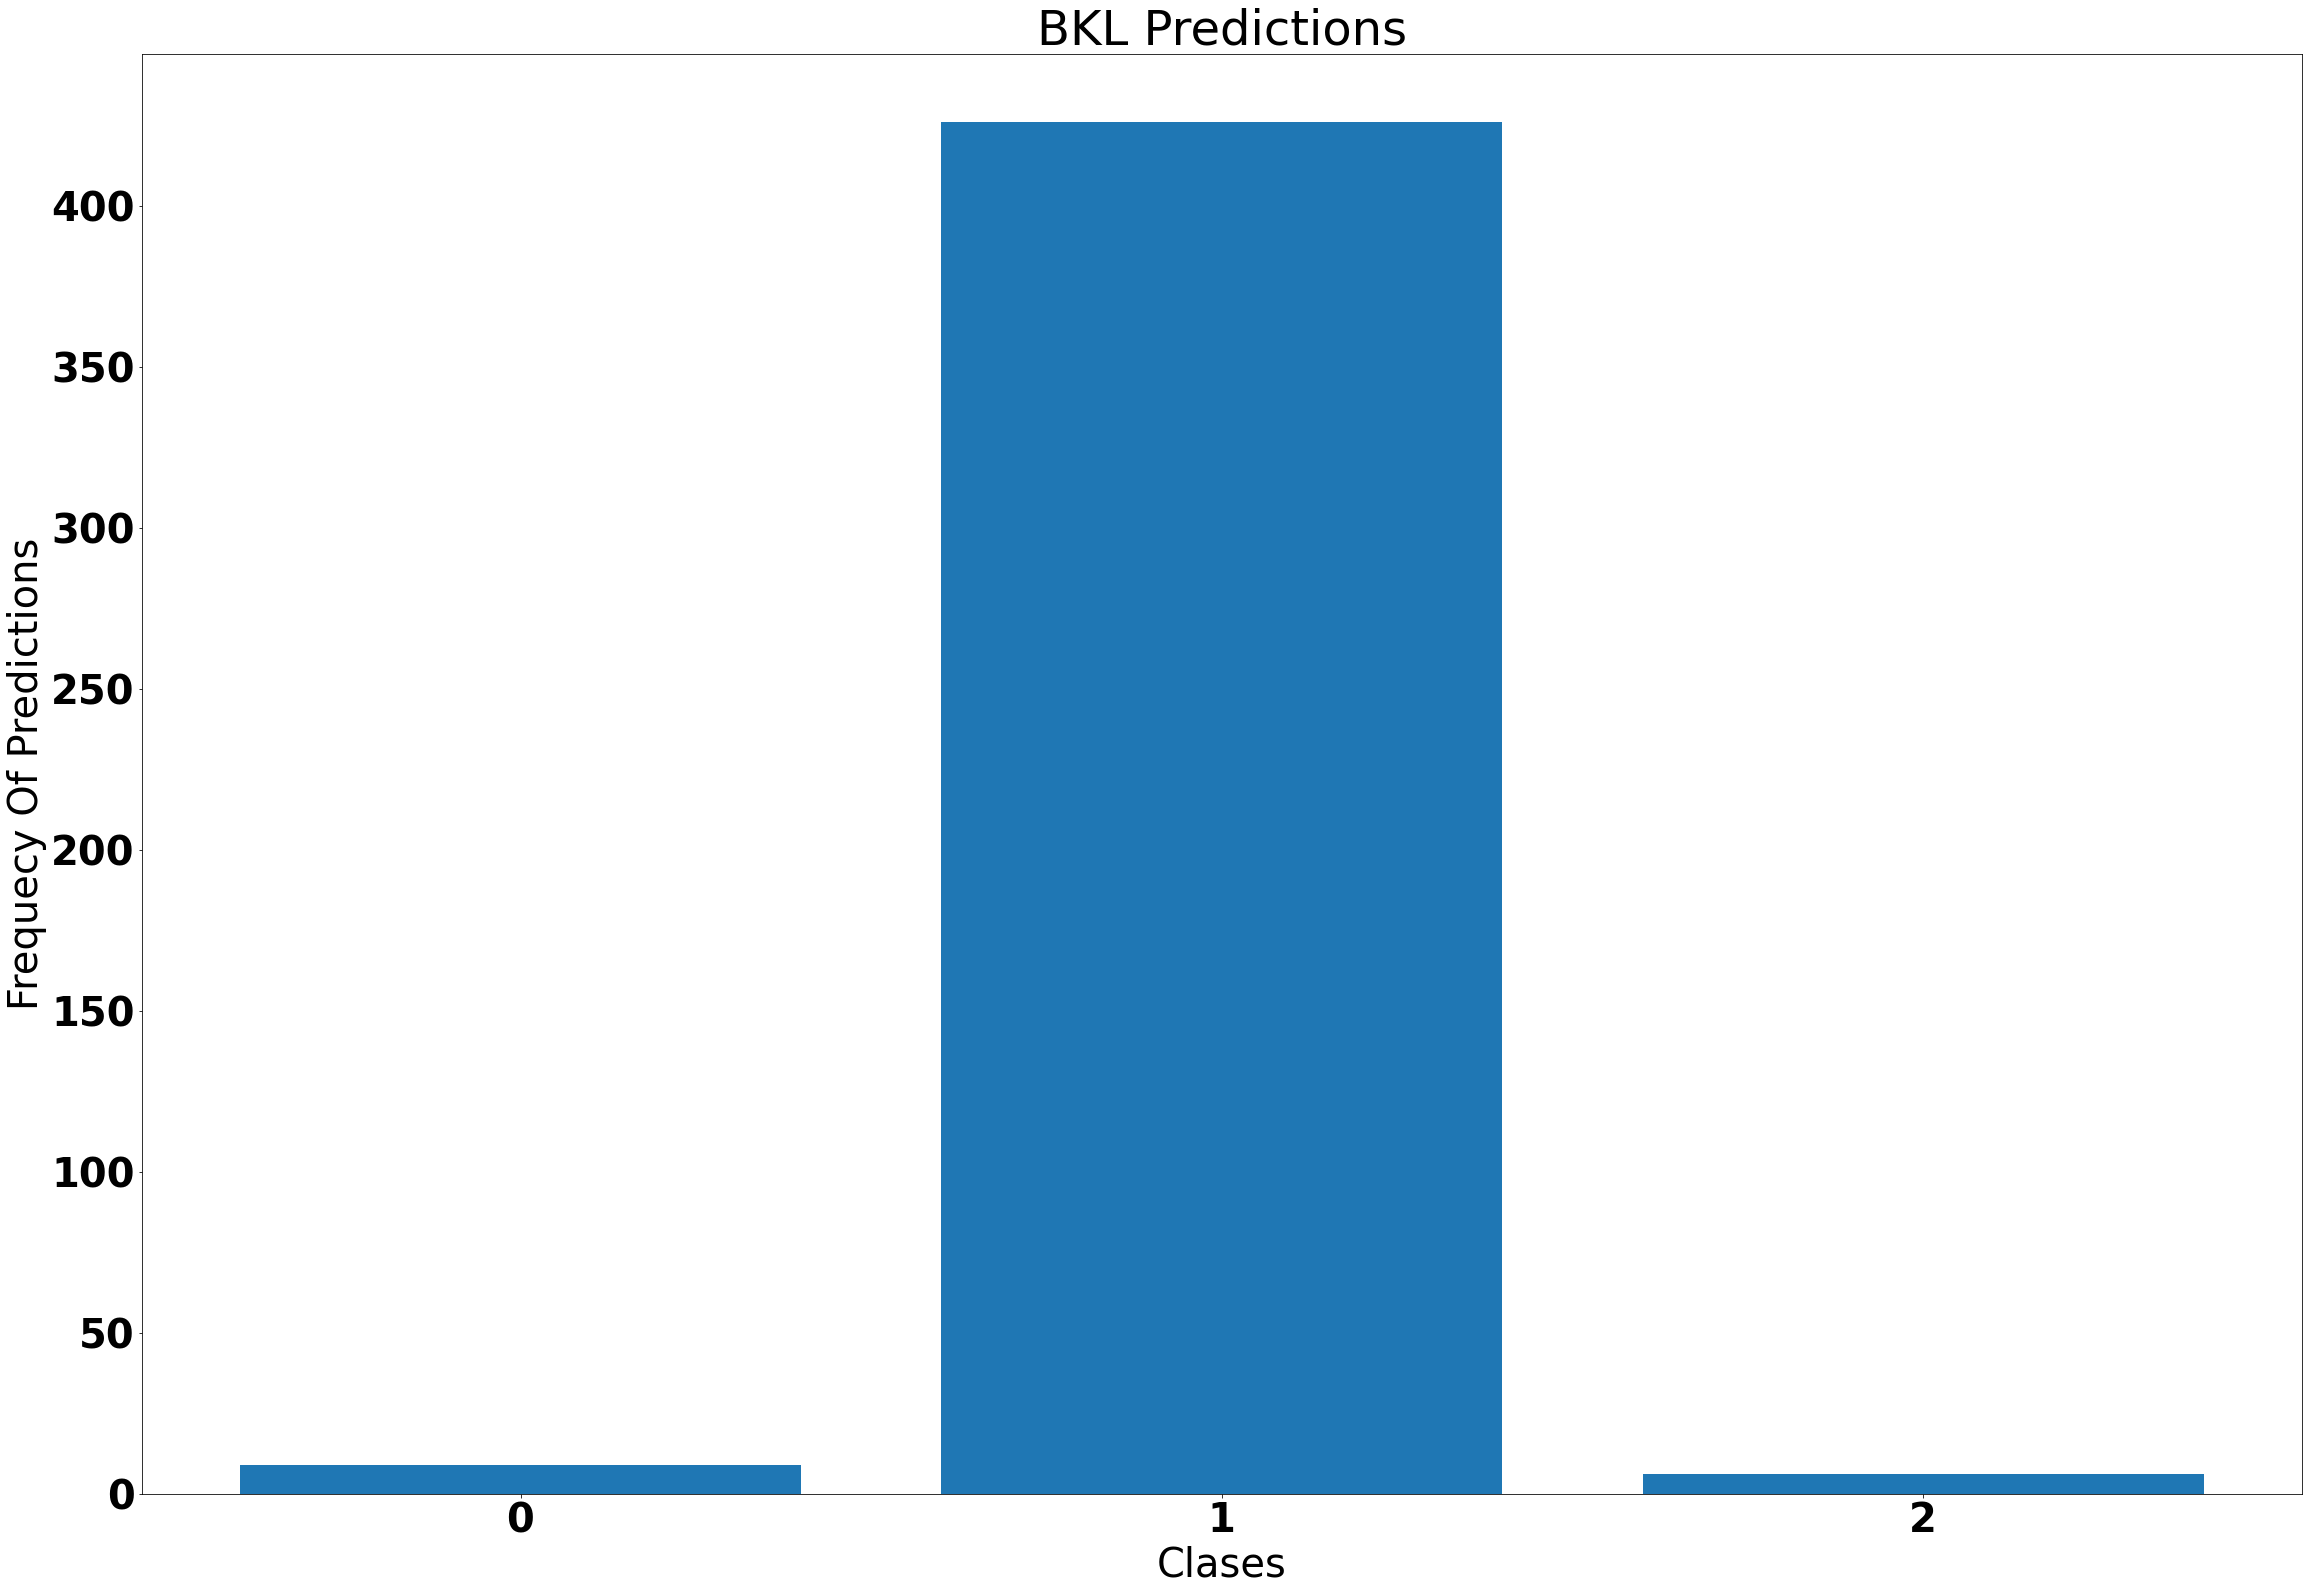

In [50]:
idx = 4
c = returnClassIndex(testY[correct_model_predictions_idx],idx)
plot_class_predictions(pidx[c], idx,sclasses)

Class #5


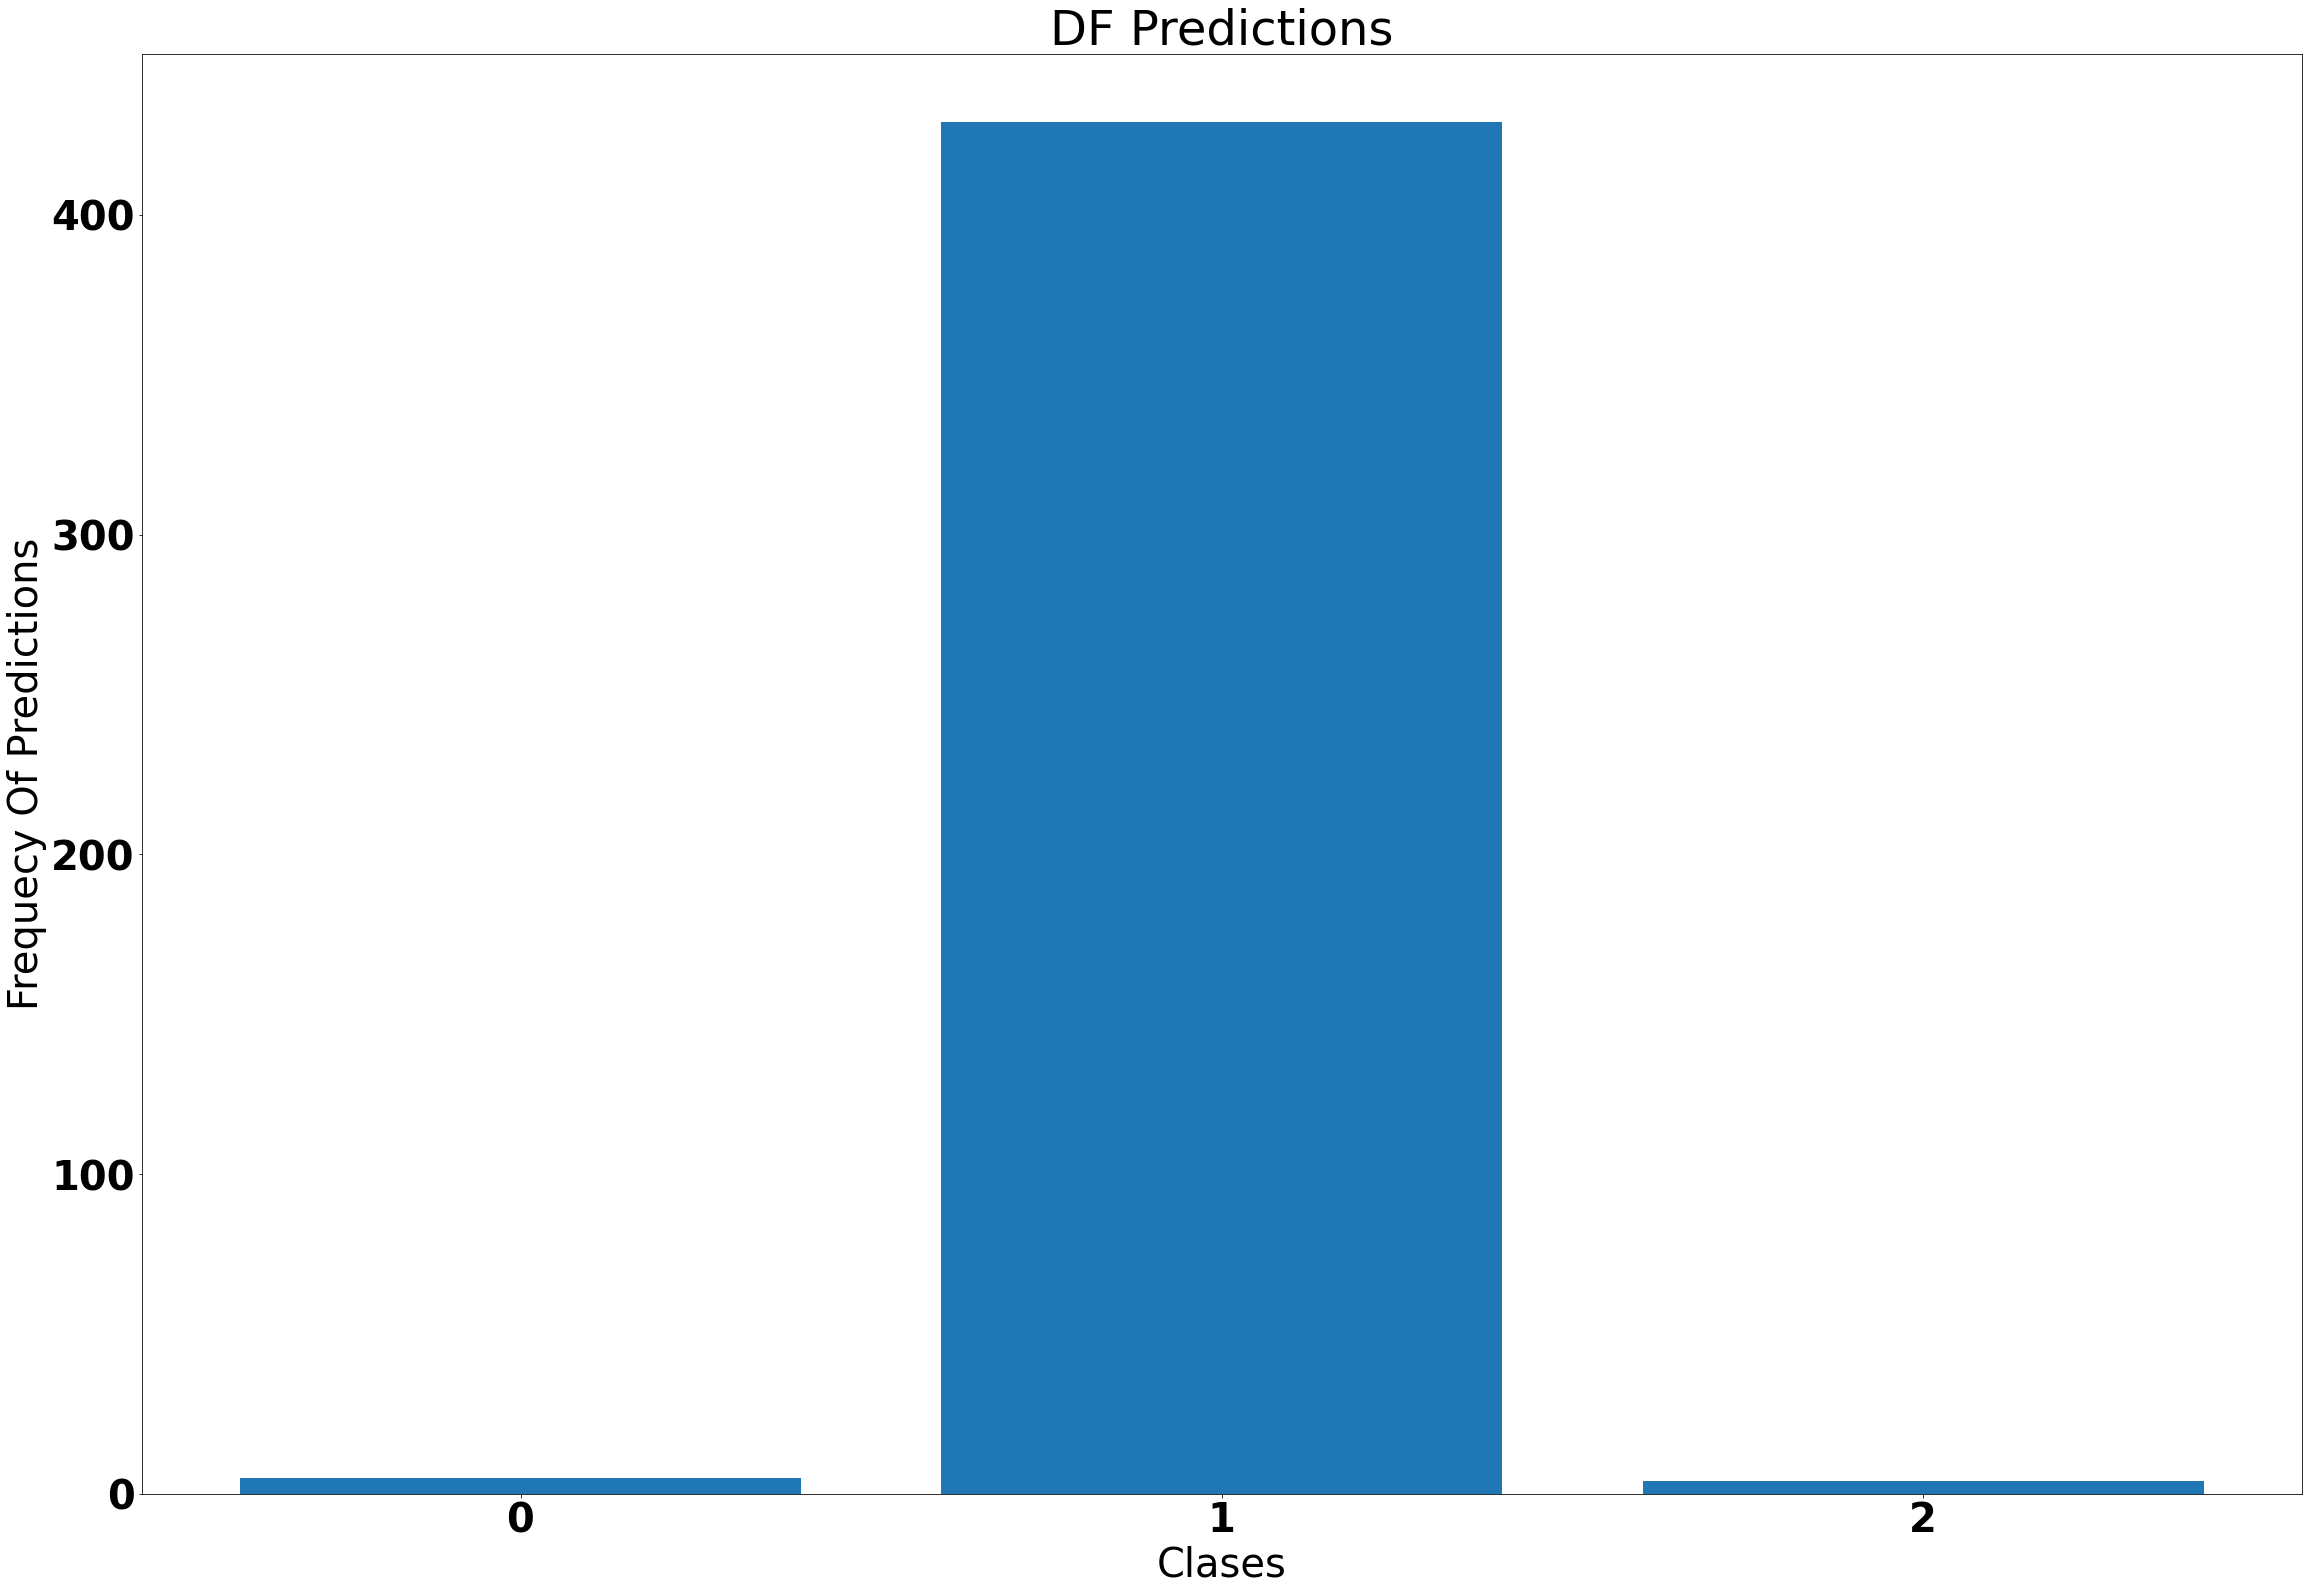

In [51]:
idx = 5
c = returnClassIndex(testY[correct_model_predictions_idx],idx)
plot_class_predictions(pidx[c], idx,sclasses)

Class #6


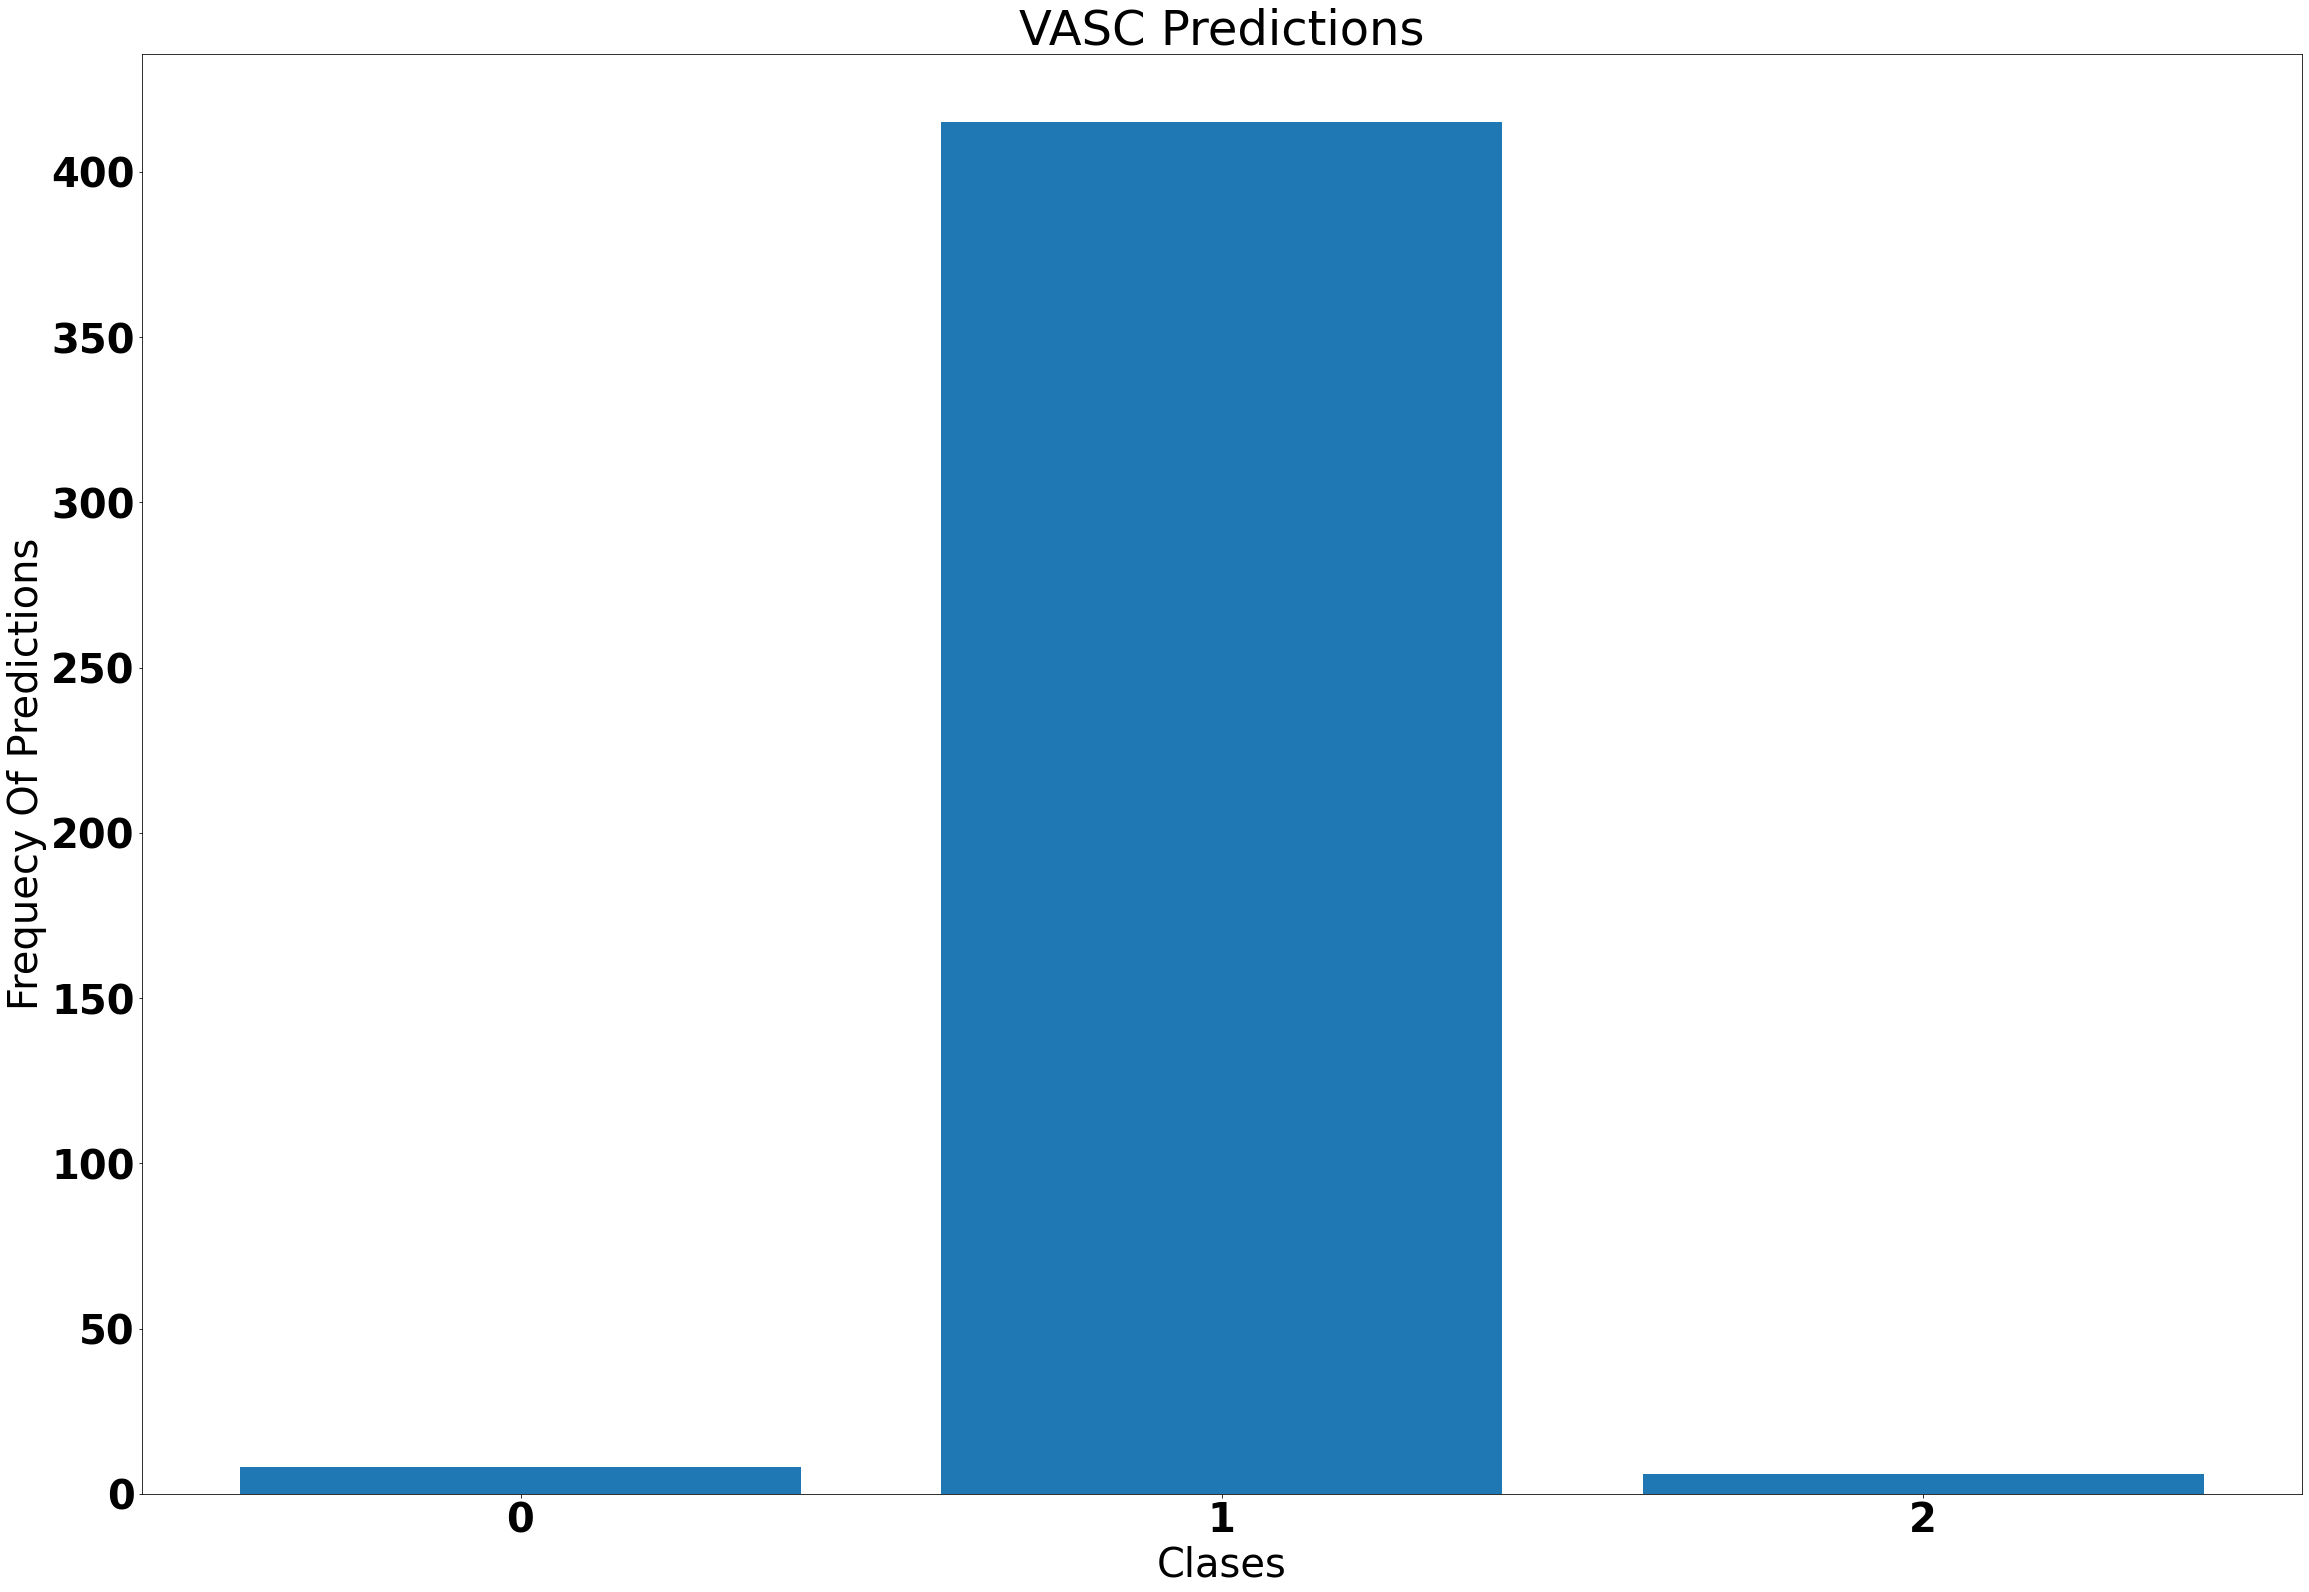

In [52]:
idx = 6
c = returnClassIndex(testY[correct_model_predictions_idx],idx)
plot_class_predictions(pidx[c], idx,sclasses)

Class #7


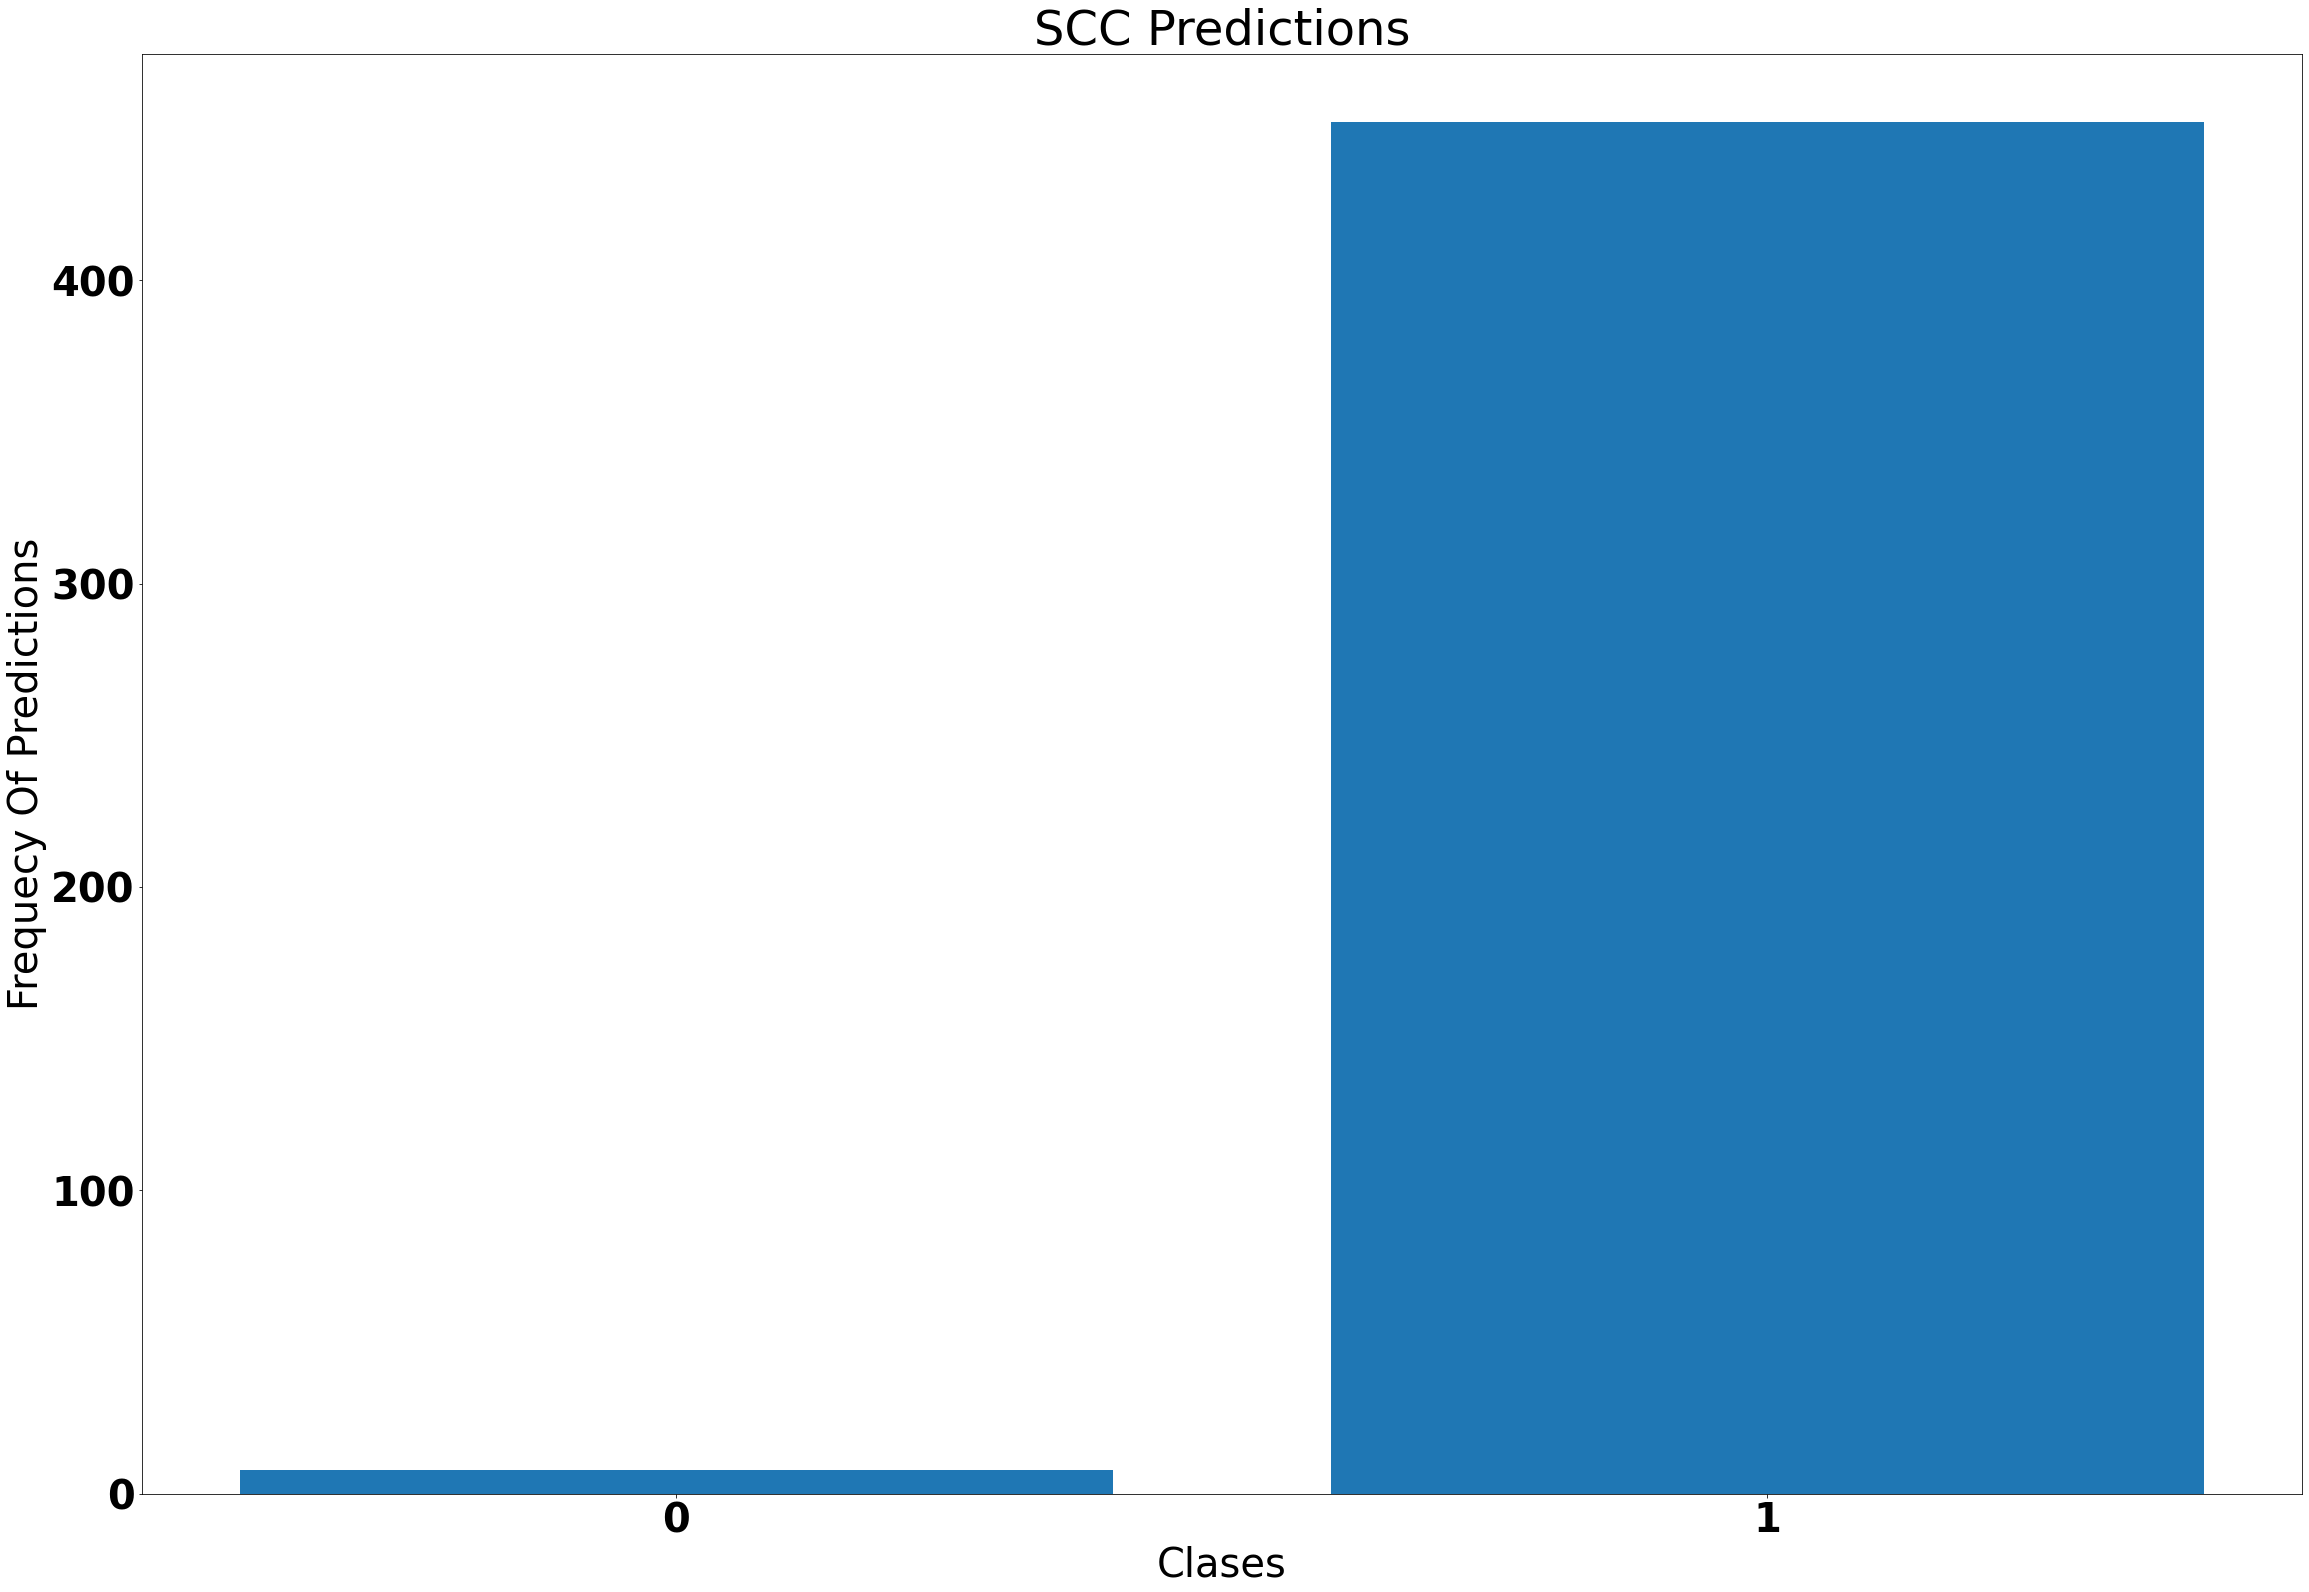

In [53]:
idx = 7
c = returnClassIndex(testY[correct_model_predictions_idx],idx)
plot_class_predictions(pidx[c], idx,sclasses)